# Fase 1 - Business Understanding

El banco Monopoly, con una larga trayectoria en el mercado chileno, ha sido recientemente adquirido por la entidad financiera internacional Dormammu. Ante este cambio, Dormammu ha encomendado a su equipo de ingenieros de datos la tarea de analizar exhaustivamente la base de clientes de Monopoly. El objetivo principal es comprender los hábitos financieros de esta nueva clientela y diseñar estrategias personalizadas que permitan una integración exitosa al ecosistema de Dormammu. Para ello, se ha puesto a disposición de los ingenieros una base de datos que abarca un año de información transaccional de una muestra representativa de clientes de Monopoly. La labor del equipo consiste en limpiar y analizar estos datos, identificando patrones de consumo, preferencias y necesidades financieras. Con esta información, se busca generar insights valiosos que permitan a Dormammu diseñar una oferta de productos y servicios a medida, optimizando así la experiencia del cliente y maximizando la rentabilidad.

Para esto, como equipo analista de datos vamos a darle respuesta a las siguientes incognitas:

- ¿Cuáles son los 3 meses de mayor uso de tarjetas de crédito a nivel nacional e internacional?
- ¿Existen diferentes grupos de clientes basados en su comportamiento financiero, como el uso de tarjetas de crédito, nivel de deuda y productos contratados?
- ¿Cuál es la probabilidad de que los clientes con ciertas características demográficas o comportamiento histórico caigan en mora?
- ¿Los clientes con mayor antigüedad o que usan múltiples productos son más fieles al banco?
- ¿Los clientes con dualidad (dos o más tarjetas de crédito) son más propensos a utilizar servicios adicionales como avances en cuotas o compras internacionales?

Con lo expuesto anteriormente, se espera responder satisfactoriamente a estas preguntas para que el nuevo dueño del banco pueda tener información sólida y conocer a mayor profundidad las interacciones económicas de sus clientes.

# Fase 2 - Data Understanding

### A continuación se importarán las librerías necesarias para trabajar en esta metodología.




In [98]:
#Importación de librerias

%pip install pyarrow
%pip install tpot
%pip install --upgrade setuptools
%pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
%pip install ipywidgets
%pip install imbalanced-learn

import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, classification_report, r2_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.
Default

# AUTOMATIZACIÓN *
### Se realiza conversión del archivo "Base_clientes_Monopoly.xlsx", al formato de archivo '.parquet' en caso de no existir en las rutas predefinidas, para una mayor eficiencia en la carga y análisis de los datos. MODIFICAR la ruta de salida para el archivo '.parquet' si este no existe en el sistema en el que se ejecuta este Notebook.

In [2]:
# Definir las posibles rutas de salida para el archivo Parquet
ruta_parquet_1 = "/Users/herna/Desktop/Duoc_UC/6to SEMESTRE/Machine_Learning/ET/Base_clientes_Monopoly.parquet"
ruta_parquet_2 = "/Users/new11/Documents/DUOC - Ing. Informática/2024/2024-2/Machine Learning/Base_clientes_Monopoly.parquet"
ruta_parquet_3 = "/Users/abrahamrubilaralbarran/Desktop/DataSet Monopoly /Base_clientes_Monopoly.parquet"

# Verificar si el archivo Parquet ya existe en alguna de las rutas de salida
if os.path.exists(ruta_parquet_1):
    ruta_parquet = ruta_parquet_1
    print(f"Archivo .parquet encontrado en {ruta_parquet}. Cargando directamente.")
elif os.path.exists(ruta_parquet_2):
    ruta_parquet = ruta_parquet_2
    print(f"Archivo .parquet encontrado en {ruta_parquet}. Cargando directamente.")
elif os.path.exists(ruta_parquet_3):
    ruta_parquet = ruta_parquet_3
    print(f"Archivo .parquet encontrado en {ruta_parquet}. Cargando directamente.")
else:
    # Si no existe el archivo .parquet, procede con la carga y conversión desde el archivo Excel
    print("'Base_clientes_Monopoly.parquet' no encontrado. Procediendo a cargar y convertir desde el 'Base_clientes_Monopoly.xlsx'.")
    
    # Definir las rutas de entrada del archivo Excel
    ruta_excel_1 = "/Users/herna/Desktop/Duoc_UC/6to SEMESTRE/Machine_Learning/ET/Base_clientes_Monopoly.xlsx"
    ruta_excel_2 = "/Users/new11/Documents/DUOC - Ing. Informática/2024/2024-2/Machine Learning/Dataset Monopoly.xlsx"
    ruta_excel_3 = "/Users/abrahamrubilaralbarran/Desktop/DataSet Monopoly /Base_clientes_Monopoly.xlsx"
    
    # Verificar cuál de las rutas del archivo Excel existe para cargar el archivo
    if os.path.exists(ruta_excel_1):
        ruta_excel = ruta_excel_1
        print(f"Cargando archivo Excel desde {ruta_excel}")
    elif os.path.exists(ruta_excel_2):
        ruta_excel = ruta_excel_2
        print(f"Cargando archivo Excel desde {ruta_excel}")
    elif os.path.exists(ruta_excel_3):
        ruta_excel = ruta_excel_3
        print(f"Cargando archivo Excel desde {ruta_excel}")
    else:
        raise FileNotFoundError("Ninguna de las rutas de archivo Excel existe.")
    
    # Cargar el archivo Excel
    df = pd.read_excel(ruta_excel, engine="openpyxl")
    df.columns = df.iloc[0]  # Configurar la primera fila como encabezado
    df1 = df.iloc[1:].reset_index(drop=True)  # Eliminar la primera fila de encabezados redundantes
    
    # Asignar la ruta de salida predeterminada para el archivo Parquet
    ruta_parquet = ruta_parquet_1
    
    # Convertir y guardar en formato parquet
    df1.to_parquet(ruta_parquet, engine="pyarrow")
    print(f"Archivo convertido y guardado en {ruta_parquet}")

# Cargar el archivo Parquet (ya sea existente o recién creado) para verificar su contenido
df = pd.read_parquet(ruta_parquet, engine="pyarrow")
print(df.head(10))

Archivo .parquet encontrado en /Users/herna/Desktop/Duoc_UC/6to SEMESTRE/Machine_Learning/ET/Base_clientes_Monopoly.parquet. Cargando directamente.
0  Id  Subsegmento Sexo  Region  Edad      Renta  Antiguedad  Internauta  \
0   1          160    M    13.0    43        NaN         130           1   
1   2          160    H    13.0    46   143640.0          69           1   
2   3          170    H    13.0    45   929106.0          24           1   
3   4          151    H    13.0    46   172447.0         134           0   
4   5          170    H    13.0    46   805250.0         116           0   
5   6          170    H    13.0    47   707664.0          67           1   
6   7          811    H    13.0    48  1022833.0          21           1   
7   8          170    H    13.0    46        NaN          69           0   
8   9          170    H    13.0    49  1171066.0          33           0   
9  10          170    M    13.0    44   964387.0          23           1   

0  Adicional  D

### Como podemos ver en el head() anterior, tenemos la última columna repleta de valores NaN, por lo que vamos a borrar esa columna por completo.

In [3]:
df.drop(df.columns[-1], axis=1, inplace=True)
df.head(5)

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,...,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0
1,2,160,H,13.0,46,143640.0,69,1,0,0,...,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0
2,3,170,H,13.0,45,929106.0,24,1,1,0,...,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0
3,4,151,H,13.0,46,172447.0,134,0,1,0,...,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0
4,5,170,H,13.0,46,805250.0,116,0,1,1,...,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0


### Para poder proceder al análisis exploratorio del Dataframe, seleccionaremos las columnas más relevantes para encontrar respuesta a las preguntas expuestas en la primera fase.
### Para esto, crearemos un Array el cual va a contener todos los nombres de las columnas que se utilizarán para el análisis, se establece un nuevo Dataframe con las columnas seleccionadas.

In [4]:
# Creamos el Array y se insertan el nombre de las columnas seleccionadas
columnas_permitidas = ['Id', 'Edad', 'Renta', 'Region', 'Sexo', 'TC', 'Cuentas', 'Hipotecario', 'Consumo', 'Debito', 
              'Ctacte', 'Antiguedad', 'Dualidad','FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 
              'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 
              'FacCN_T12', 'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 
              'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12', 'TxsCN_T01', 
              'TxsCN_T02', 'TxsCN_T03', 'TxsCN_T04', 'TxsCN_T05', 'TxsCN_T06', 'TxsCN_T07', 'TxsCN_T08', 
              'TxsCN_T09', 'TxsCN_T10', 'TxsCN_T11', 'TxsCN_T12', 'TxsCI_T01', 'TxsCI_T02', 'TxsCI_T03', 
              'TxsCI_T04', 'TxsCI_T05', 'TxsCI_T06', 'TxsCI_T07', 'TxsCI_T08', 'TxsCI_T09', 'TxsCI_T10', 
              'TxsCI_T11', 'TxsCI_T12', 'UsoL1_T01','UsoL1_T02', 'UsoL1_T03', 'UsoL1_T04', 'UsoL1_T05', 
              'UsoL1_T06', 'UsoL1_T07', 'UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10', 'UsoL1_T11', 'UsoL1_T12', 
              'UsoLI_T01', 'UsoLI_T02', 'UsoLI_T03', 'UsoLI_T04', 'UsoLI_T05', 'UsoLI_T06', 'UsoLI_T07', 
              'UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10', 'UsoLI_T11', 'UsoLI_T12', 'CUPO_L1', 'CUPO_MX', 
              'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 
              'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12', 
              'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 
              'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12', 
              'FlgAct_T01', 'FlgAct_T02', 'FlgAct_T03', 'FlgAct_T04', 'FlgAct_T05', 'FlgAct_T06', 'FlgAct_T07', 
              'FlgAct_T08', 'FlgAct_T09', 'FlgAct_T10', 'FlgAct_T11', 'FlgAct_T12', 'FacAN_T01', 'FacAN_T02', 
              'FacAN_T03', 'FacAN_T04', 'FacAN_T05', 'FacAN_T06', 'FacAN_T07', 'FacAN_T08', 'FacAN_T09', 
              'FacAN_T10', 'FacAN_T11', 'FacAN_T12', 'FacAI_T01', 'FacAI_T02', 'FacAI_T03', 'FacAI_T04', 
              'FacAI_T05', 'FacAI_T06', 'FacAI_T07', 'FacAI_T08', 'FacAI_T09', 'FacAI_T10', 'FacAI_T11', 
              'FacAI_T12', 'target','IndRev_T12','IndRev_T11','IndRev_T10','IndRev_T09','IndRev_T08',
              'IndRev_T07','IndRev_T06','IndRev_T05','IndRev_T04','IndRev_T03','IndRev_T02','IndRev_T01']

# Se establece el nuevo nombre del Dataframe que contiene las columnas seleccionadas
df_acotado = df[columnas_permitidas]

# Iniciamos con el primer paso de la exploración de los datos
df_acotado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51124 entries, 0 to 51123
Columns: 160 entries, Id to IndRev_T01
dtypes: float64(127), int64(20), object(13)
memory usage: 62.4+ MB


### En la celda ejecutada anteriormente, se aprecian todos los tipos de datos del Dataframe. Ahora revisamos cuáles son los valores únicos dentro de estos datos.

In [5]:
for i in df_acotado:
    print(f"{i} = {df_acotado[i].unique()} \n")

Id = [    1     2     3 ... 51122 51123 51124] 

Edad = [ 43  46  45  47  48  49  44  38  36  33  51  37  50  41  39  35  42  40
  32  34  31  52  53  67  30  69  54  87  55  26  29  59  56  64  62  73
  60  27  28  63  58  78  57  25  61  72  83  86  80  93  79  82  81  84
  97  89  88  74  91  68  90  75  77  95  76  24  70  23  65  22  71  21
  20  19 104  66   9  85  94] 

Renta = [    nan 143640. 929106. ... 625376. 806220. 840878.] 

Region = [13.  9. 10.  8.  7.  6.  5. 12. 11.  4.  1.  2.  3. nan] 

Sexo = ['M' 'H' None] 

TC = [ 3  1  2  4  5  6  7  8 12 10  9 11] 

Cuentas = [1 2 3 4 5] 

Hipotecario = [0 1] 

Consumo = [0 1] 

Debito = [1 0] 

Ctacte = [1 0] 

Antiguedad = [130  69  24 134 116  67  21  33  23  38  59  80  29  13   7  22  72  94
  43  18 184  63  49  14 109  11 160  31 105  27  78  60 152  10  36  28
  19  26  75  70  58  48  74  15  30 125  64   6  61 149   8  87  35 145
  16  47  20  39   9  25 154  84  73  55 108  66  92  50  65  34  32  17
  82  86  99  9

### En el resultado de la celda anterior, nos pudimos percatar que al mostrar los valores únicos, hay filas que no tienen valor asignado (NaN), por lo que ahora vamos a sumar todas las filas que tienen al menos una entrada de este tipo.

In [6]:
df_acotado.isna().any(axis=1).sum()

19862

# ⬆⬆⬆
### Esto nos indica que hay 19.862 filas que tienen al menos un valor en alguna de las columnas como NaN.

### La siguiente celda nos permite revisar cómo están compuestos los datos de cada columna, nos entrega información relevante como el promedio, valor mínimo, máximo, cuartiles y el tipo de dato. 

In [7]:
for i in df_acotado:
  print(f"{i} = {df_acotado[i].describe()} \n")

Id = count    51124.000000
mean     25562.500000
std      14758.371918
min          1.000000
25%      12781.750000
50%      25562.500000
75%      38343.250000
max      51124.000000
Name: Id, dtype: float64 

Edad = count    51124.000000
mean        38.702879
std         13.302573
min          9.000000
25%         28.000000
50%         35.000000
75%         46.000000
max        104.000000
Name: Edad, dtype: float64 

Renta = count    3.775900e+04
mean     6.630771e+05
std      4.092795e+05
min      1.000000e+00
25%      4.199990e+05
50%      5.670120e+05
75%      8.149035e+05
max      1.308933e+07
Name: Renta, dtype: float64 

Region = count    51071.000000
mean        10.828220
std          3.392703
min          1.000000
25%          9.000000
50%         13.000000
75%         13.000000
max         13.000000
Name: Region, dtype: float64 

Sexo = count     51123
unique        2
top           H
freq      27410
Name: Sexo, dtype: object 

TC = count    51124.000000
mean         1.732376
st

### A continuación vamos a ramificar el Dataframe original para poder hacer un estudio con gráficos, ya que, se deben separar los valores numéricos y categoricos. Para esto vamos a hacer un Array para contener las columnas categóricas encontradas en el Dataframe.

In [8]:
# Creación del Array
columnas_a_seleccionar = []

# Ciclo for para iterar sobre los nombres de las columnas que empiezan con "IndRev_"
for columna in df_acotado.columns:
    if columna.startswith('IndRev_'):
        columnas_a_seleccionar.append(columna)

# Seleccionar las columnas "IndRev_" en un nuevo Dataframe
df_categorico = df_acotado[columnas_a_seleccionar]

# Creamos un segundo Dataframe con las siguientes columnas
df_categorico2 = df_acotado[['Sexo', 'target']]

# Y concatenamos los Dataframe en unos solo
df_concatenado_categorico = pd.concat([df_categorico2, df_categorico], axis=1)
df_concatenado_categorico

,Sexo,target,IndRev_T12,IndRev_T11,IndRev_T10,IndRev_T09,IndRev_T08,IndRev_T07,IndRev_T06,IndRev_T05,IndRev_T04,IndRev_T03,IndRev_T02,IndRev_T01
0,M,0,R,R,R,R,R,R,R,R,R,R,R,R
1,H,0,R,R,R,R,R,R,R,R,R,R,R,R
2,H,0,T,R,T,T,T,T,T,T,T,T,T,T
3,H,0,R,R,R,R,R,R,R,R,R,R,R,R
4,H,0,T,T,T,T,T,T,T,T,T,R,T,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,H,0,R,R,R,R,R,R,R,R,R,R,R,R
51120,H,0,R,T,T,T,T,T,R,R,R,R,R,R
51121,H,0,R,R,R,P,P,T,R,R,R,R,R,R
51122,M,0,None,None,T,T,R,R,T,T,T,T,R,R


### Sustraemos todas las columnas categóricas del Dataframe original para renombrarlo como un nuevo Dataframe de sólo columnas numéricas.

In [9]:
df_acotado_numericas = df_acotado.drop(['Sexo','target','IndRev_T12','IndRev_T11','IndRev_T10','IndRev_T09','IndRev_T08','IndRev_T07','IndRev_T06','IndRev_T05','IndRev_T04','IndRev_T03','IndRev_T02','IndRev_T01'], axis=1)
df_acotado_numericas

,Id,Edad,Renta,Region,TC,Cuentas,Hipotecario,Consumo,Debito,Ctacte,...,FacAI_T03,FacAI_T04,FacAI_T05,FacAI_T06,FacAI_T07,FacAI_T08,FacAI_T09,FacAI_T10,FacAI_T11,FacAI_T12
0,1,43,NaN,13.0,3,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,46,143640.0,13.0,1,1,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,45,929106.0,13.0,2,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,46,172447.0,13.0,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,46,805250.0,13.0,3,2,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,51,364978.0,13.0,3,2,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51120,51121,51,625376.0,13.0,1,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51121,51122,47,806220.0,13.0,2,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51122,51123,47,NaN,13.0,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


### Revisamos el data frame de las variables numéricas.

In [10]:
for i in df_acotado_numericas:
  print(f"{i} = {df_acotado_numericas[i].describe()} \n")

Id = count    51124.000000
mean     25562.500000
std      14758.371918
min          1.000000
25%      12781.750000
50%      25562.500000
75%      38343.250000
max      51124.000000
Name: Id, dtype: float64 

Edad = count    51124.000000
mean        38.702879
std         13.302573
min          9.000000
25%         28.000000
50%         35.000000
75%         46.000000
max        104.000000
Name: Edad, dtype: float64 

Renta = count    3.775900e+04
mean     6.630771e+05
std      4.092795e+05
min      1.000000e+00
25%      4.199990e+05
50%      5.670120e+05
75%      8.149035e+05
max      1.308933e+07
Name: Renta, dtype: float64 

Region = count    51071.000000
mean        10.828220
std          3.392703
min          1.000000
25%          9.000000
50%         13.000000
75%         13.000000
max         13.000000
Name: Region, dtype: float64 

TC = count    51124.000000
mean         1.732376
std          0.877470
min          1.000000
25%          1.000000
50%          2.000000
75%          

### Revisamos las correlaciones que tienen las variables numéricas en nuestro nuevo Dataframe.

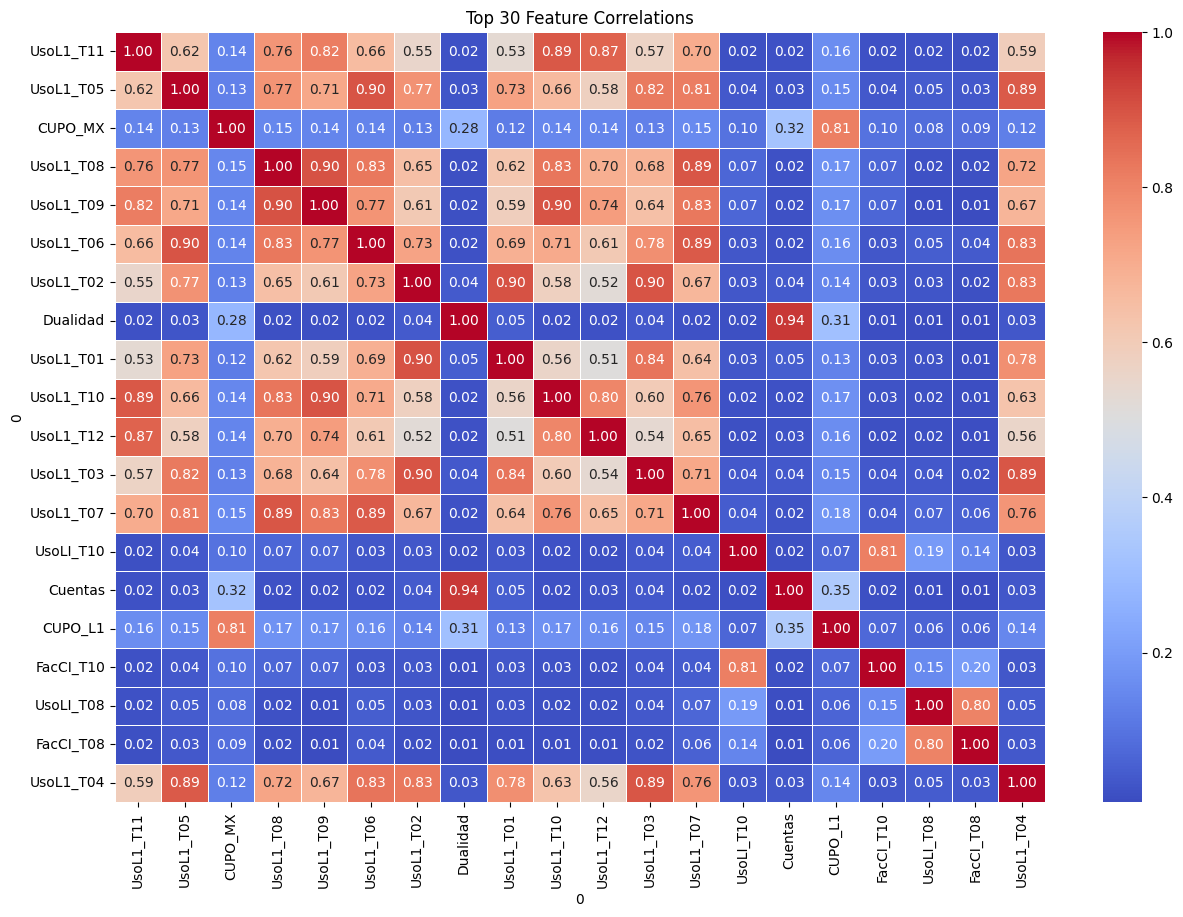

In [11]:
def plot_top_correlations(dataframe, top_n=30):
    # Calcular la matriz de correlación
    corr_matrix = dataframe.corr().abs()
    
    # Extraer las correlaciones superiores a la diagonal
    triangulo_matriz = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Encontrar las correlaciones más altas
    top_corr_pairs = (
        triangulo_matriz.unstack()
        .dropna()
        .sort_values(ascending=False)
        .head(top_n)
    )
    
    # Obtener las columnas de las correlaciones más altas
    top_columnas = list(set([index[0] for index in top_corr_pairs.index] + [index[1] for index in top_corr_pairs.index]))
    
    # Crear un nuevo dataframe con solo las columnas seleccionadas
    top_corr_dataframe = dataframe[top_columnas]
    
    # Calcular la matriz de correlación del nuevo dataframe
    top_corr_matriz = top_corr_dataframe.corr()
    
    # Dibujar el mapa de calor
    plt.figure(figsize=(15, 10))
    sb.heatmap(top_corr_matriz, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Top {} Feature Correlations'.format(top_n))
    plt.show()

# Uso de la función
# Asegúrate de reemplazar 'your_dataframe' con el nombre de tu dataframe
plot_top_correlations(df_acotado_numericas)


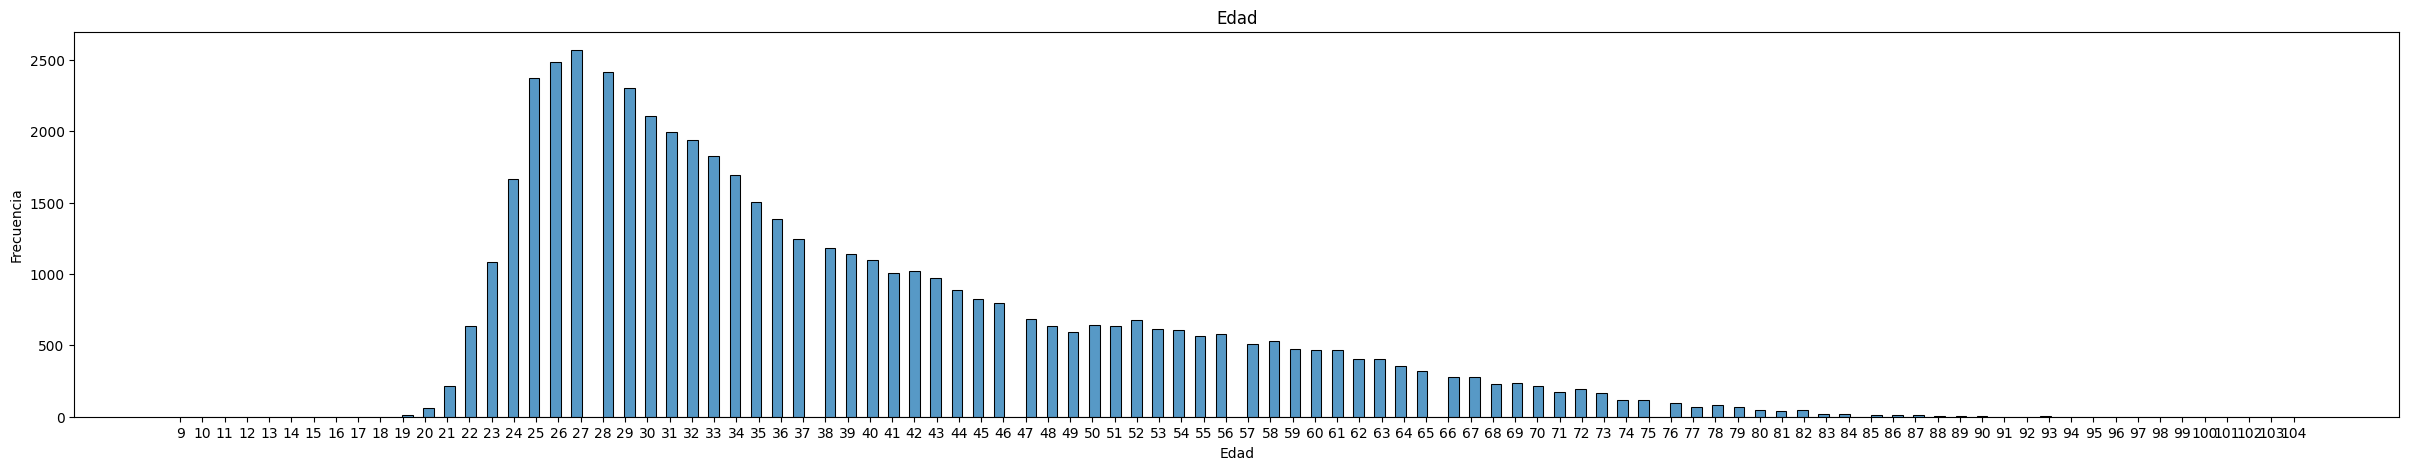

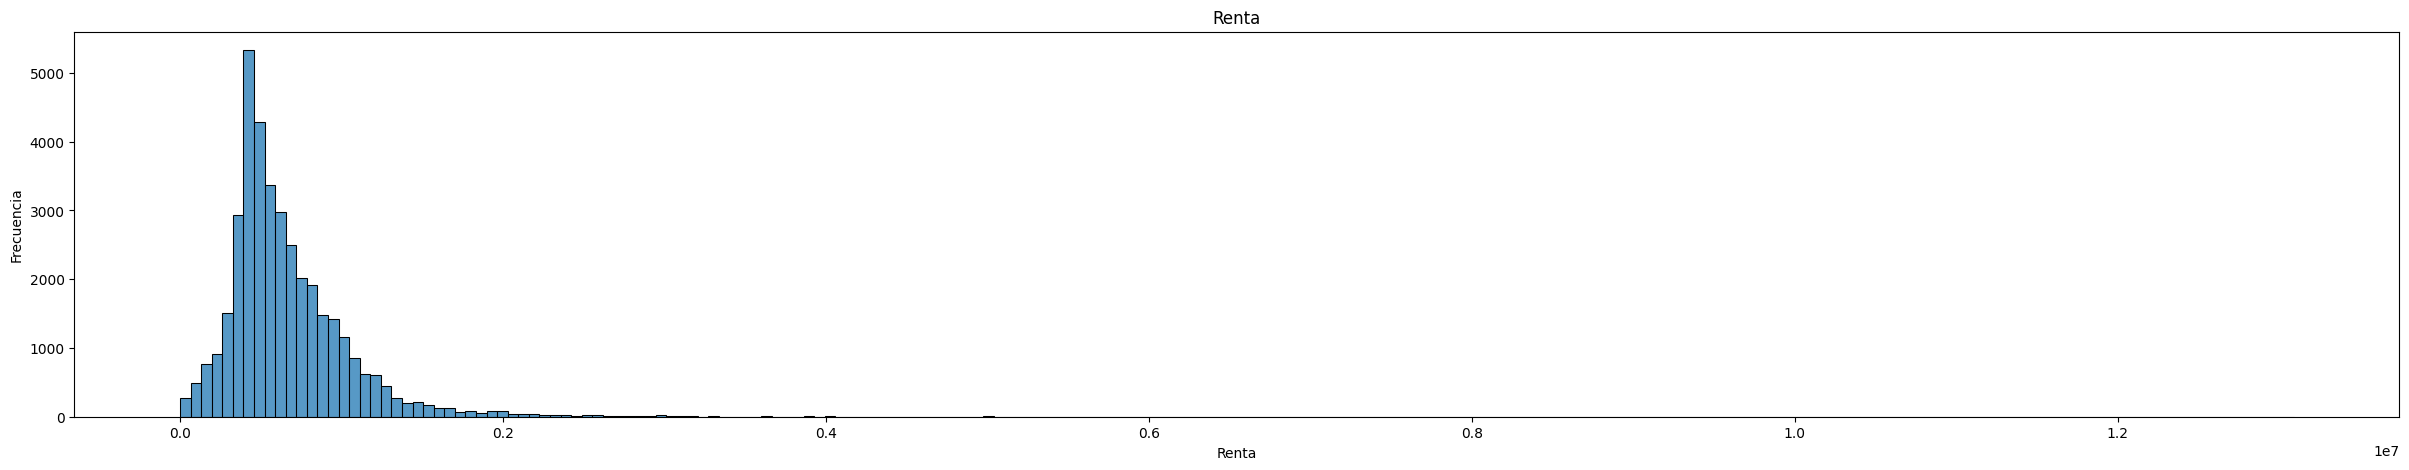

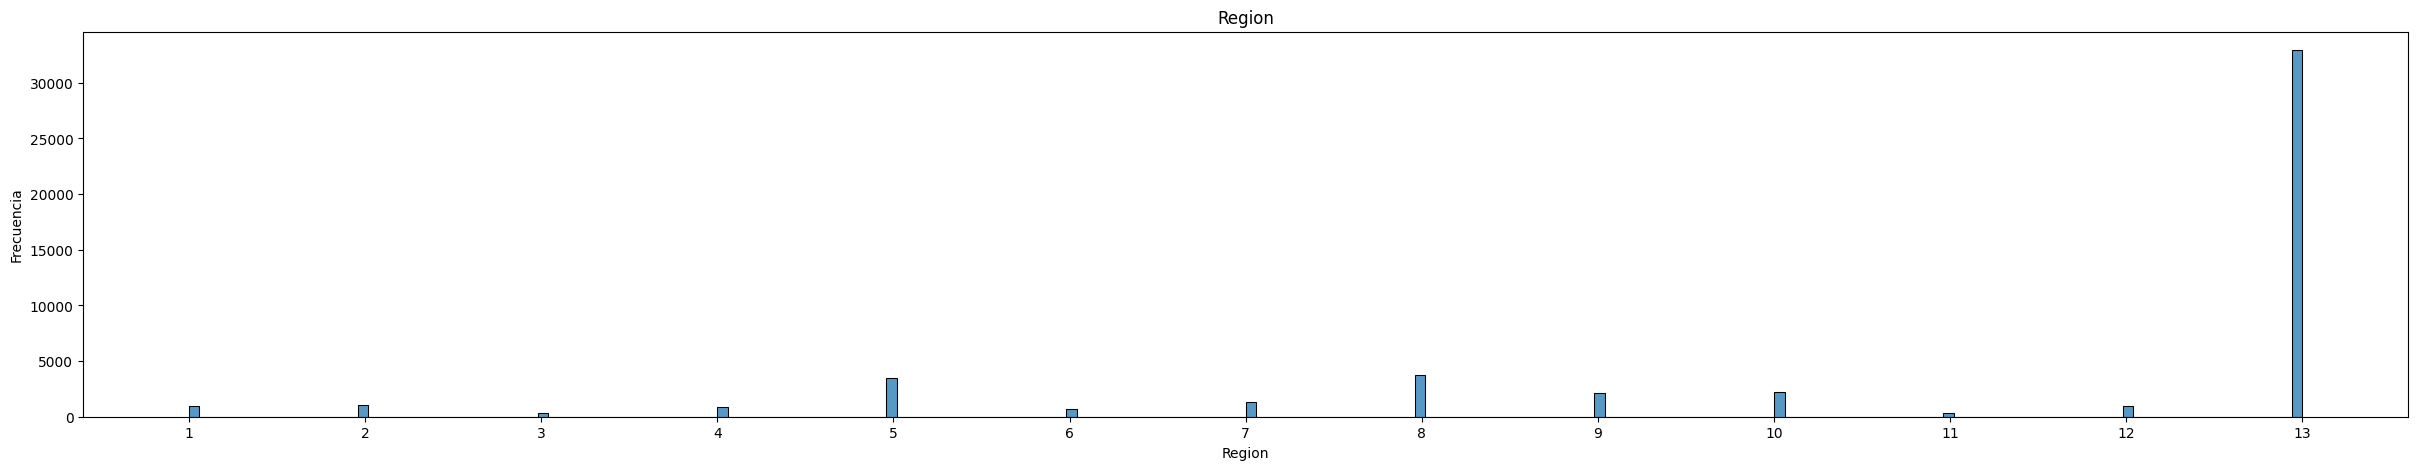

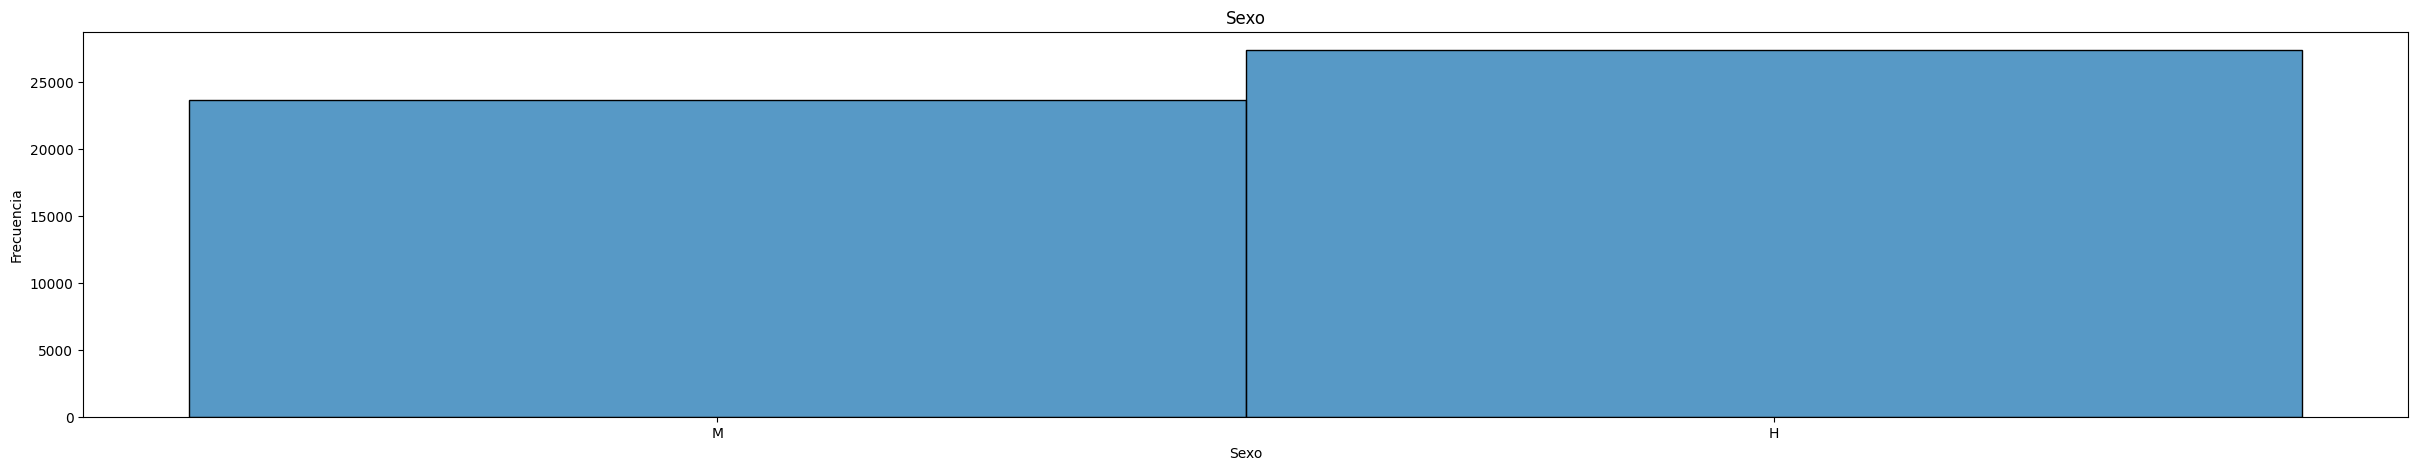

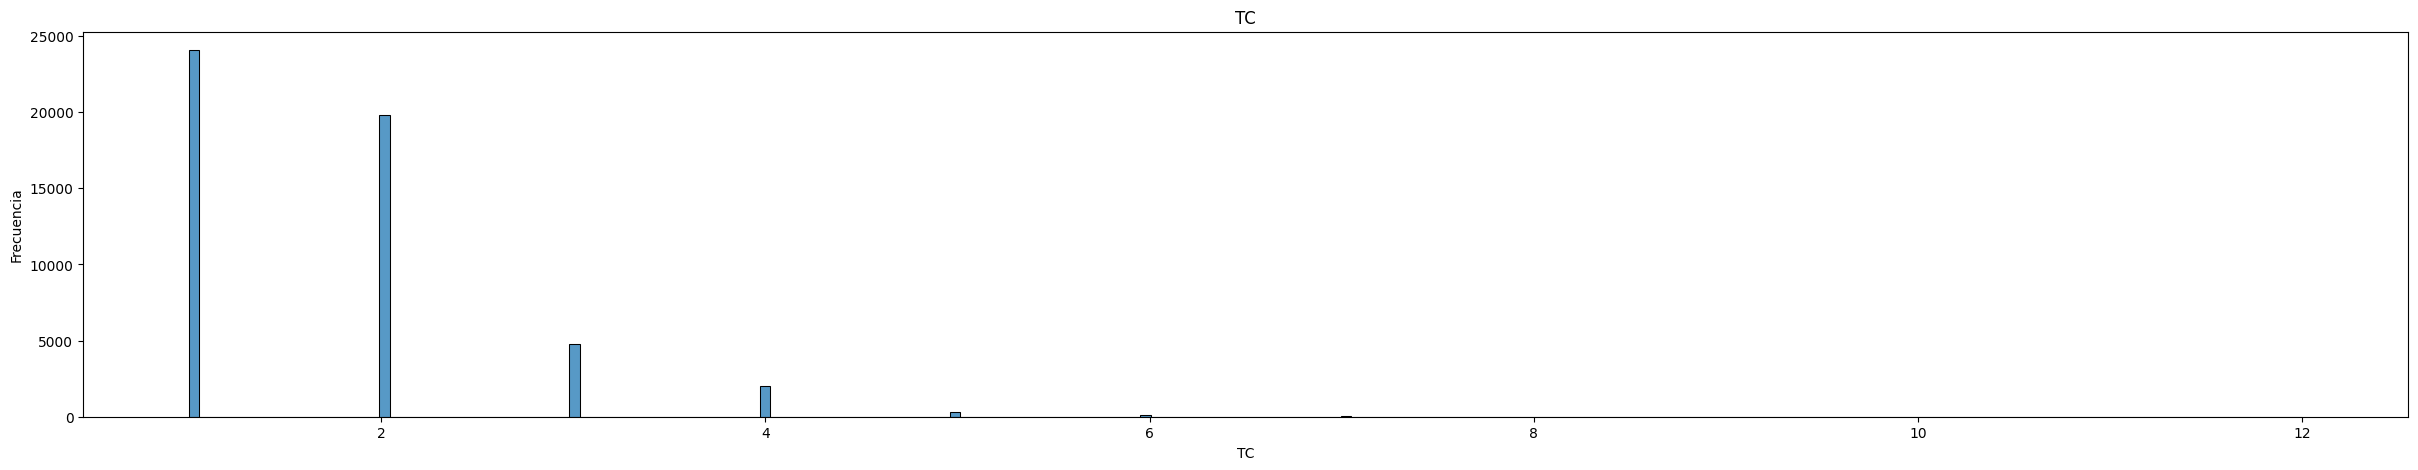

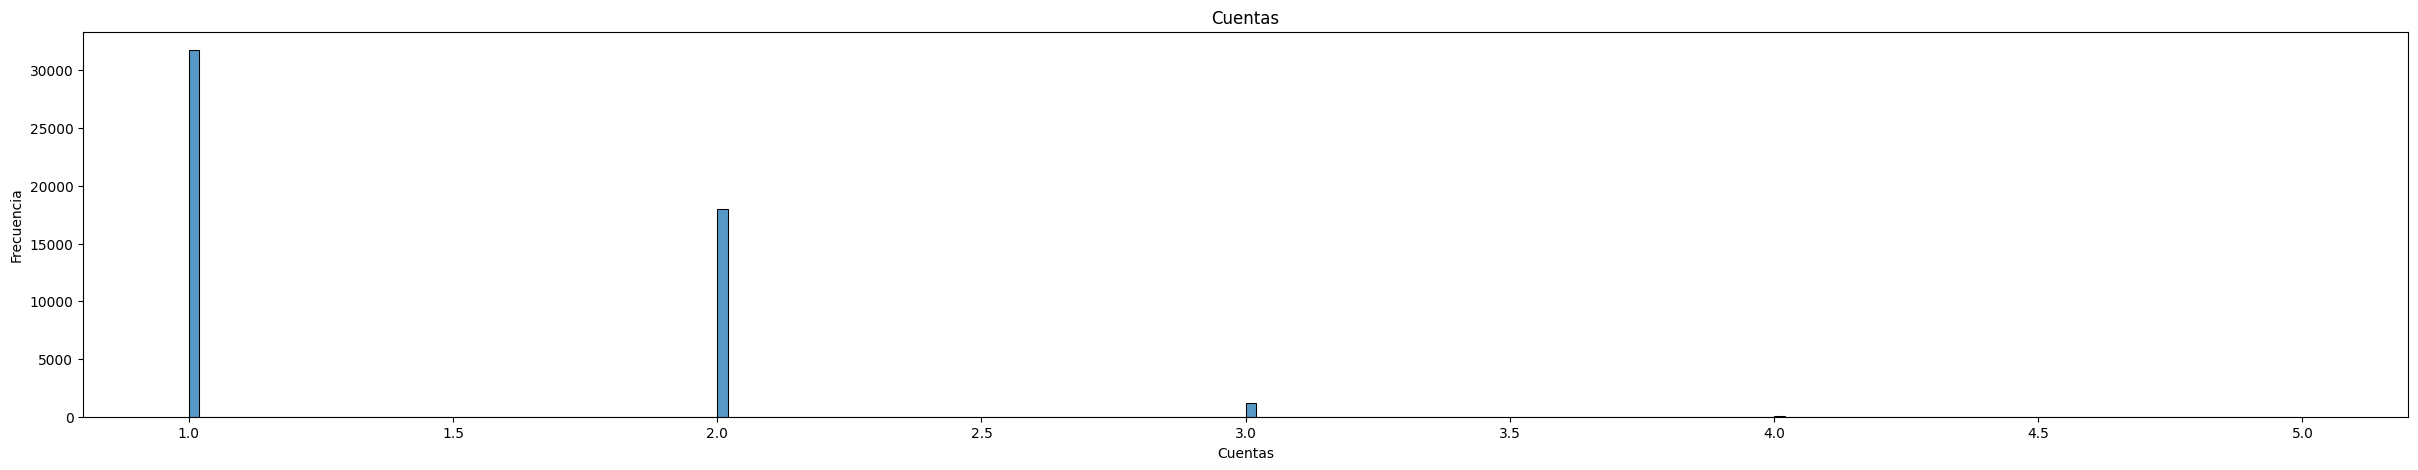

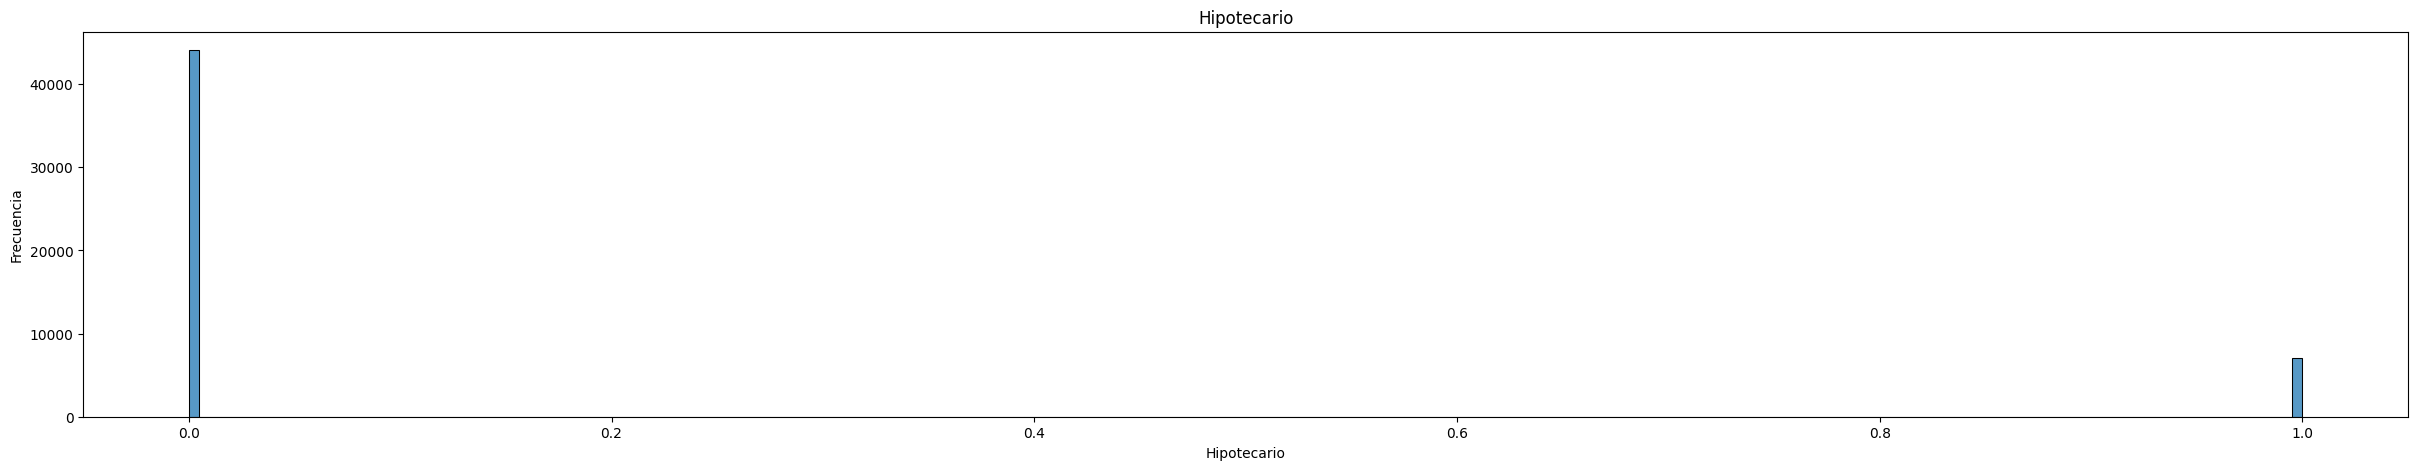

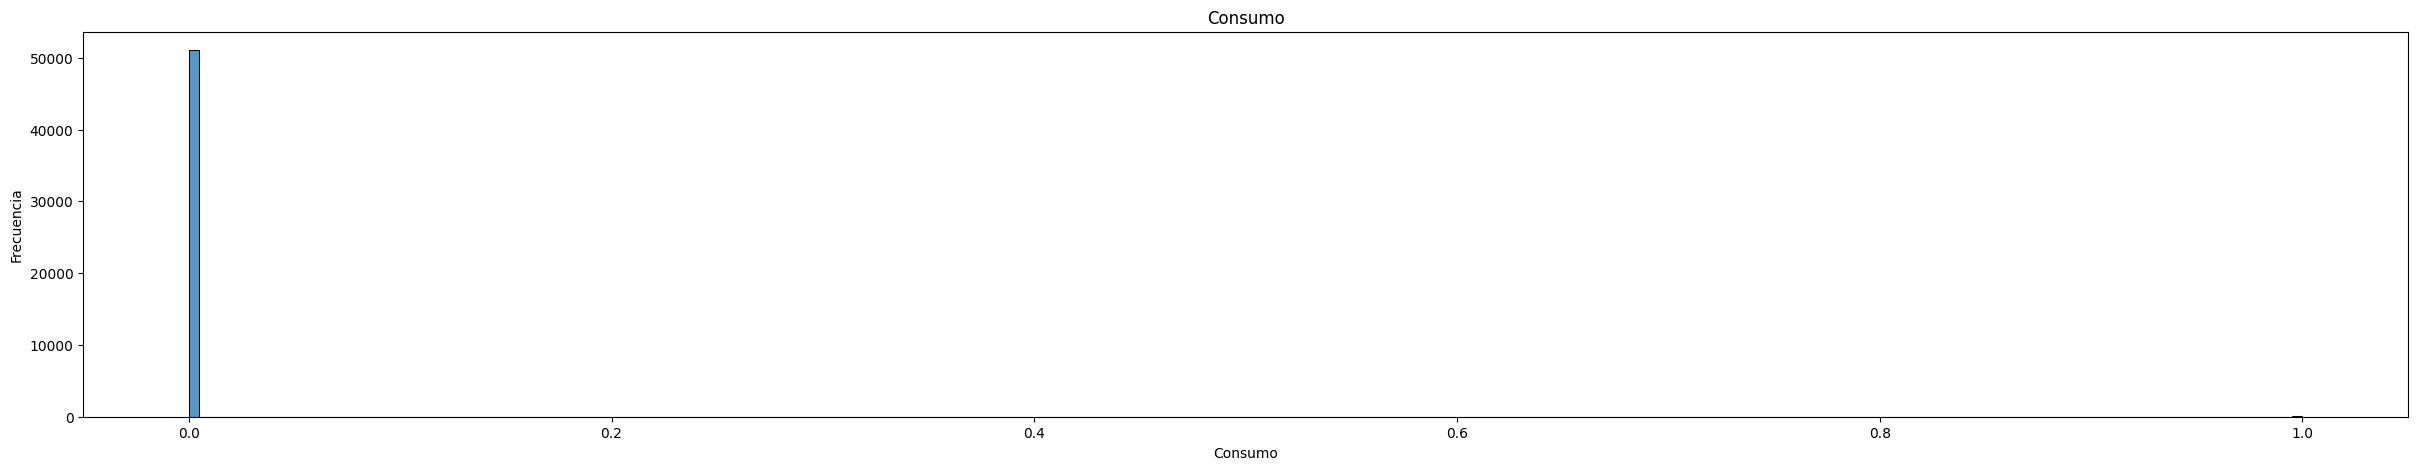

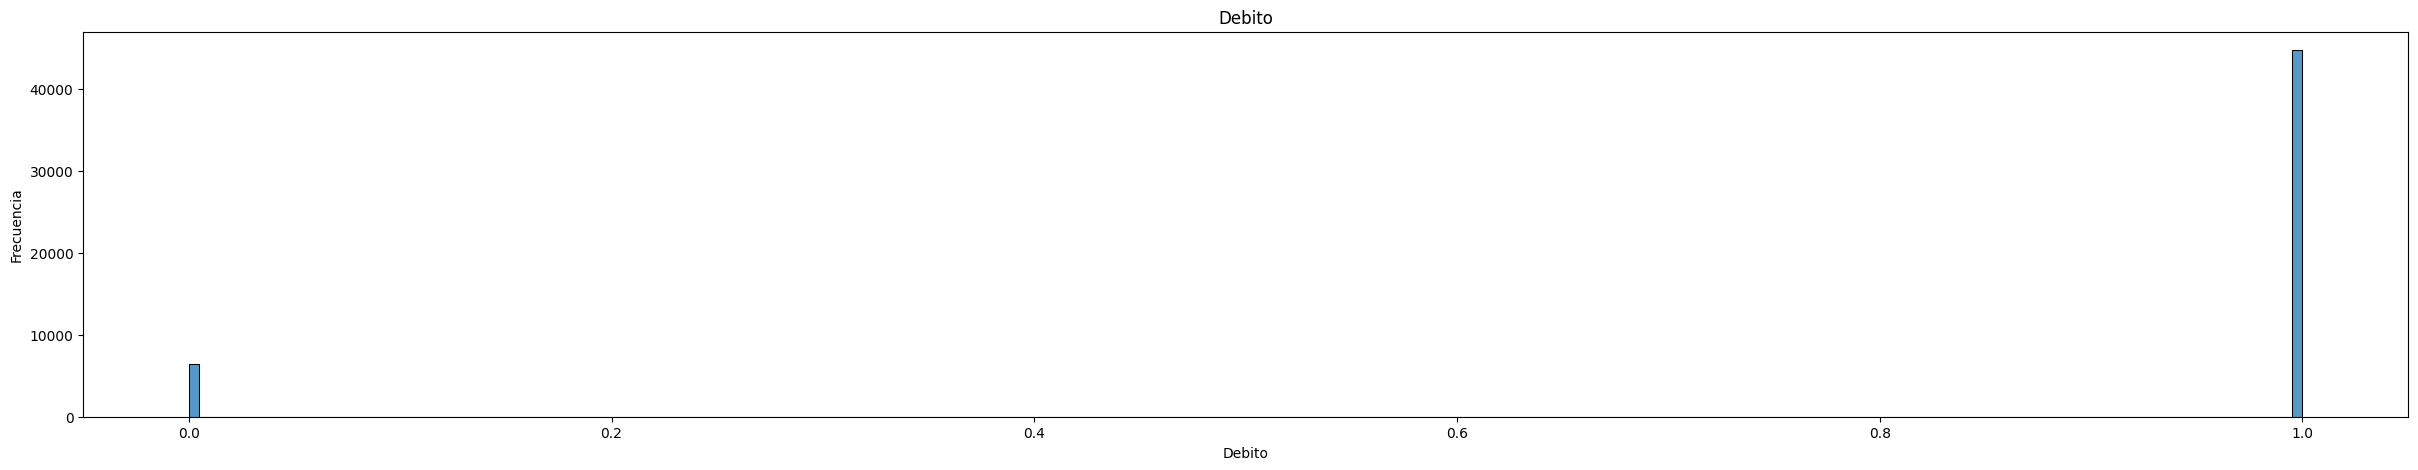

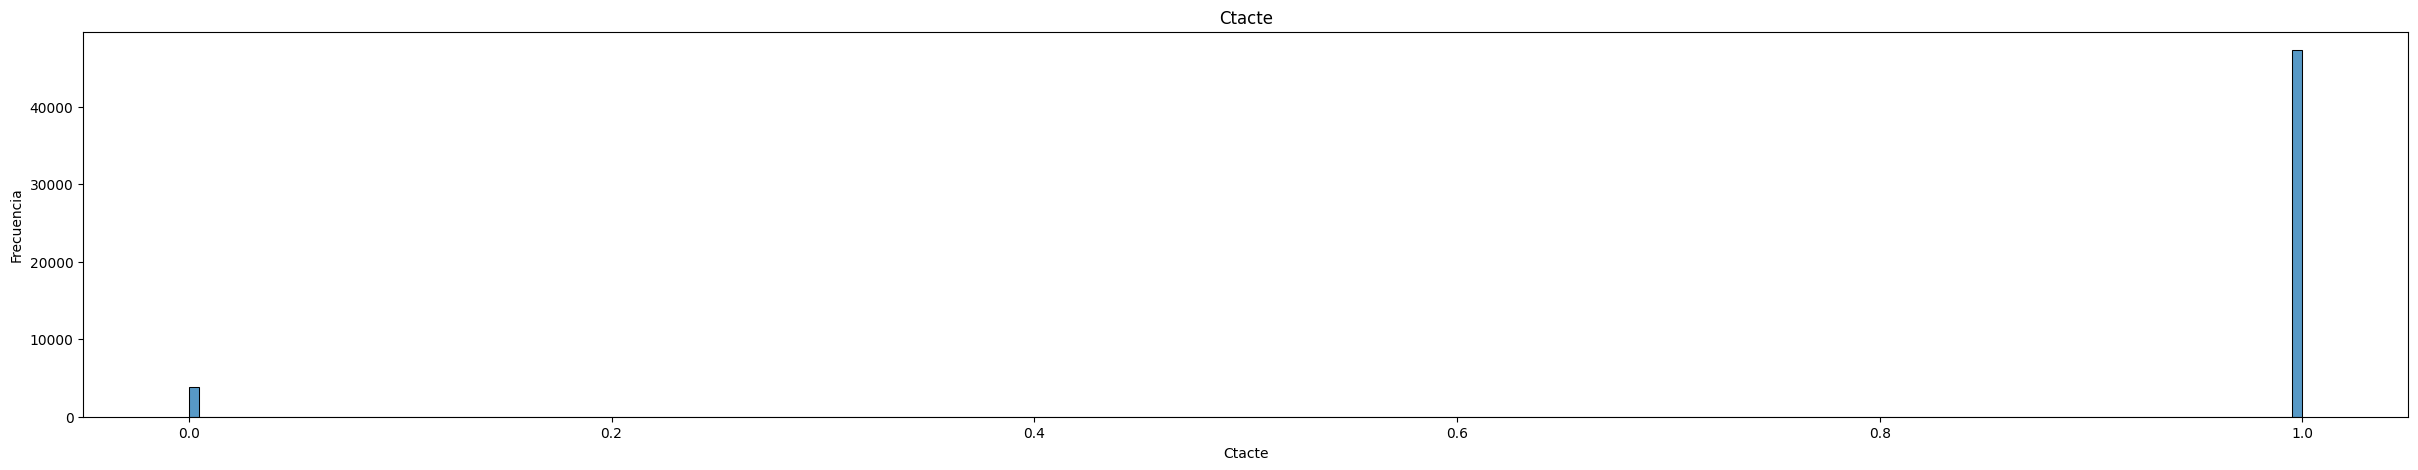

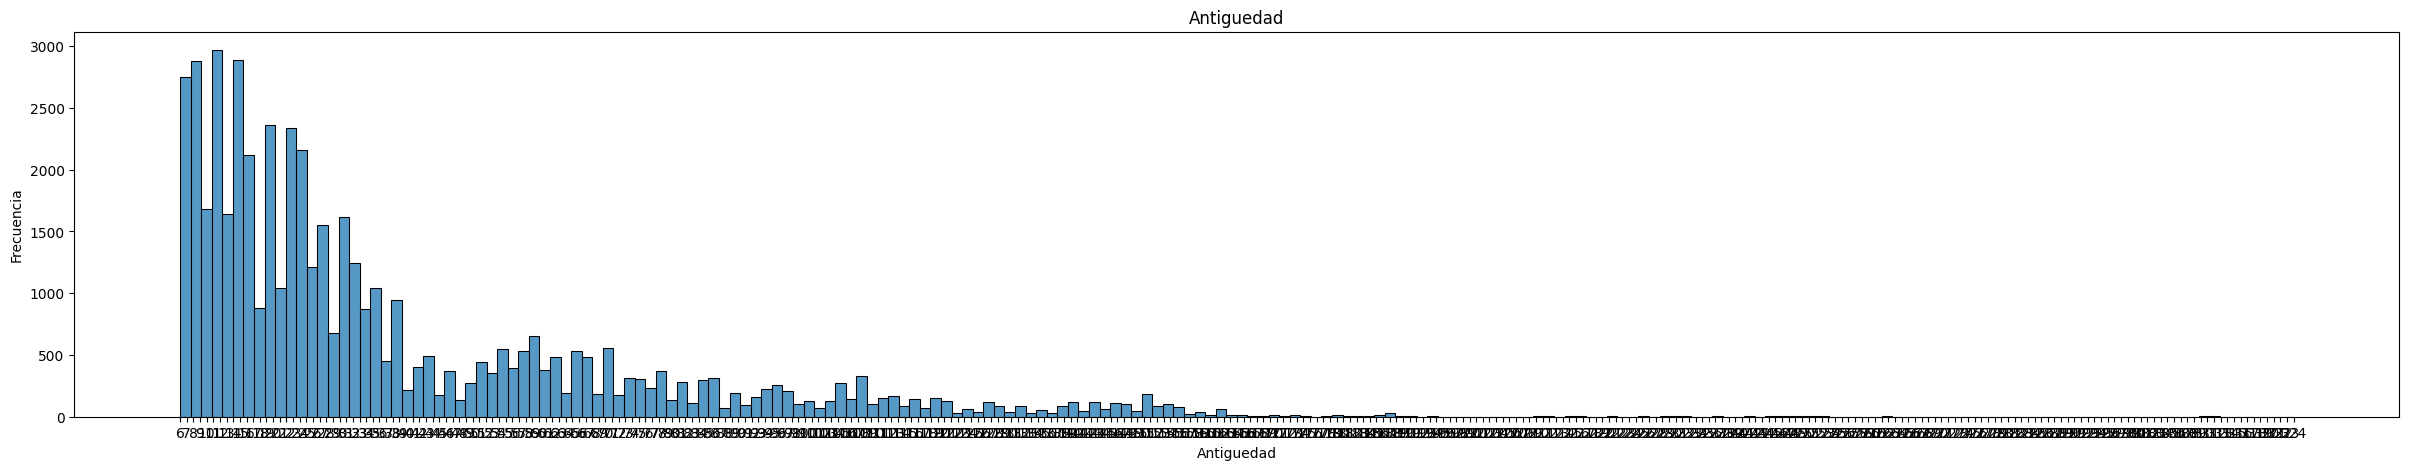

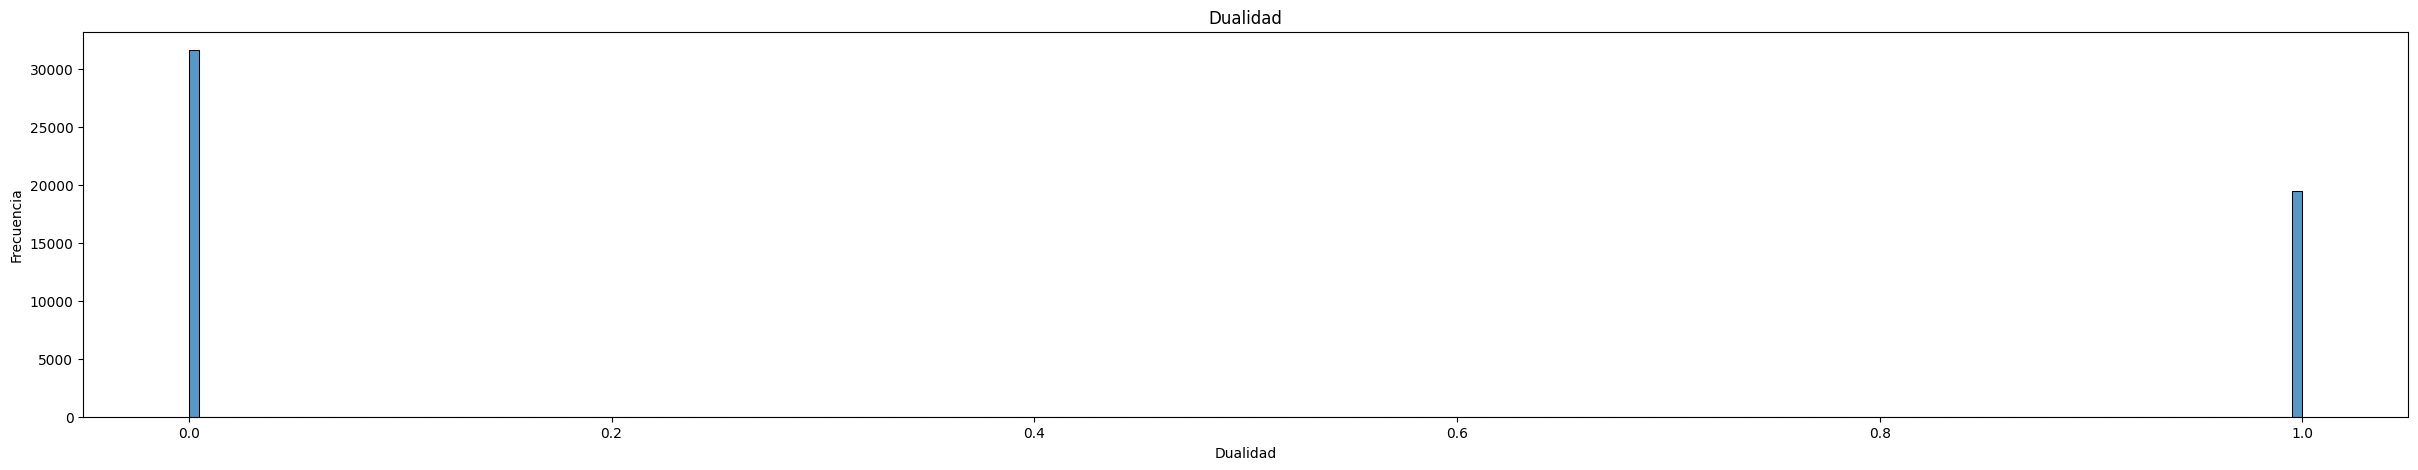

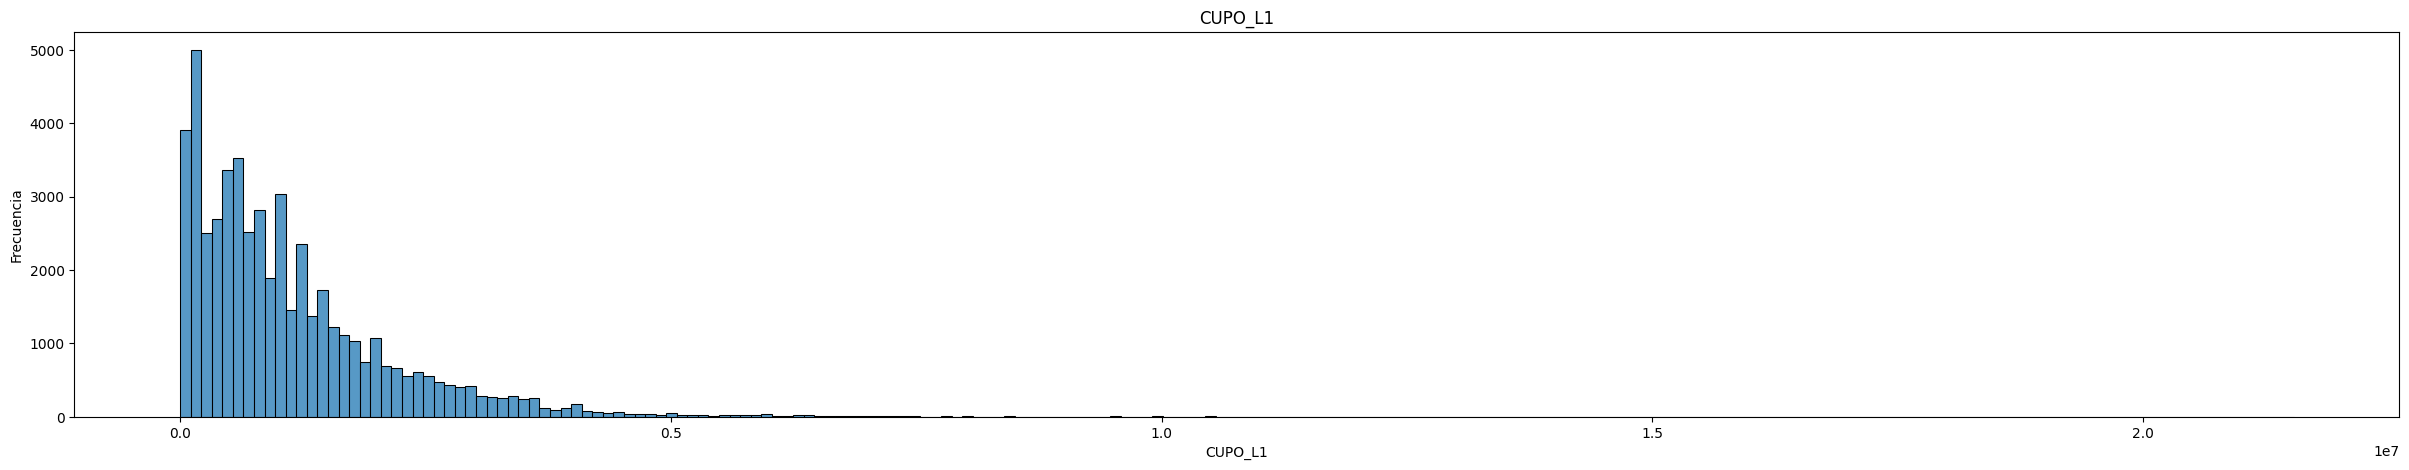

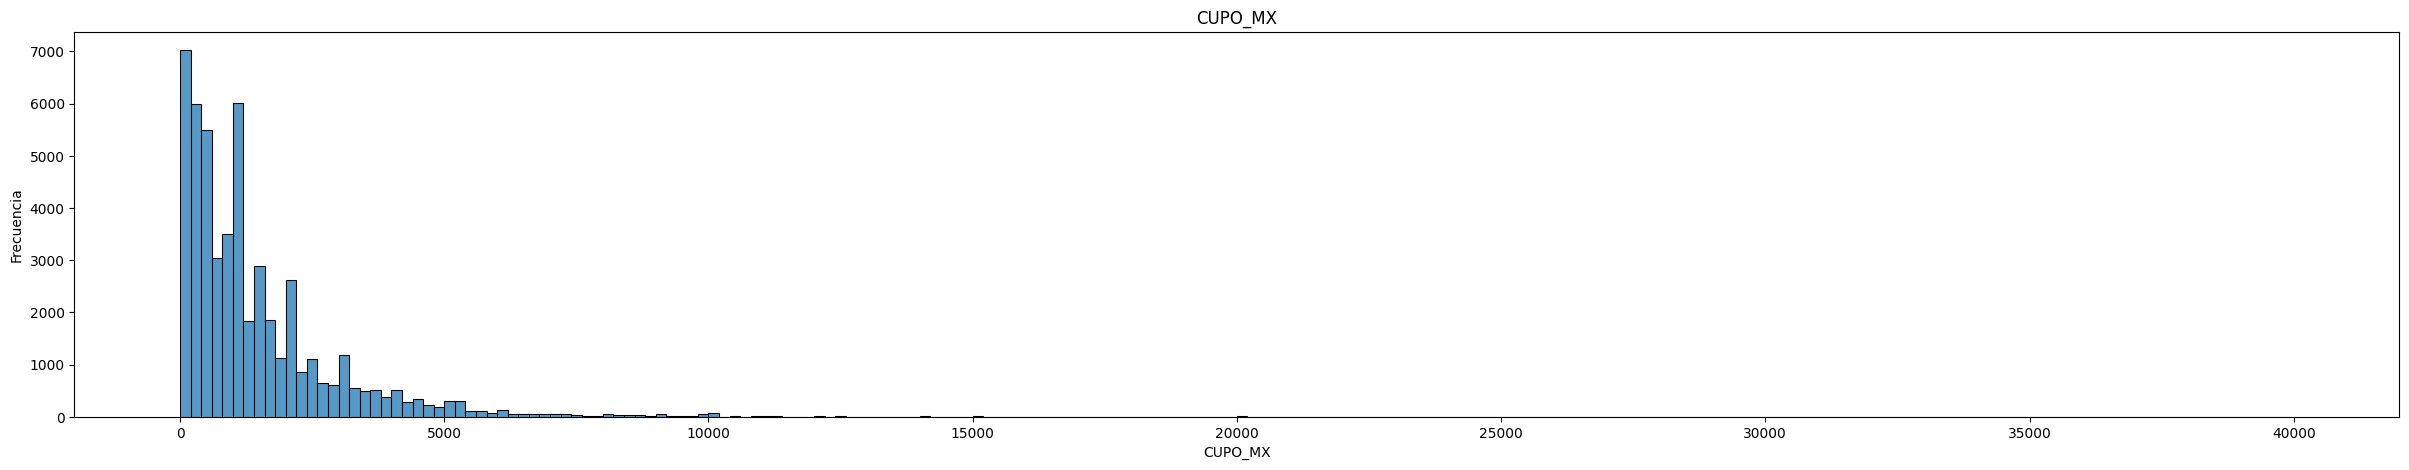

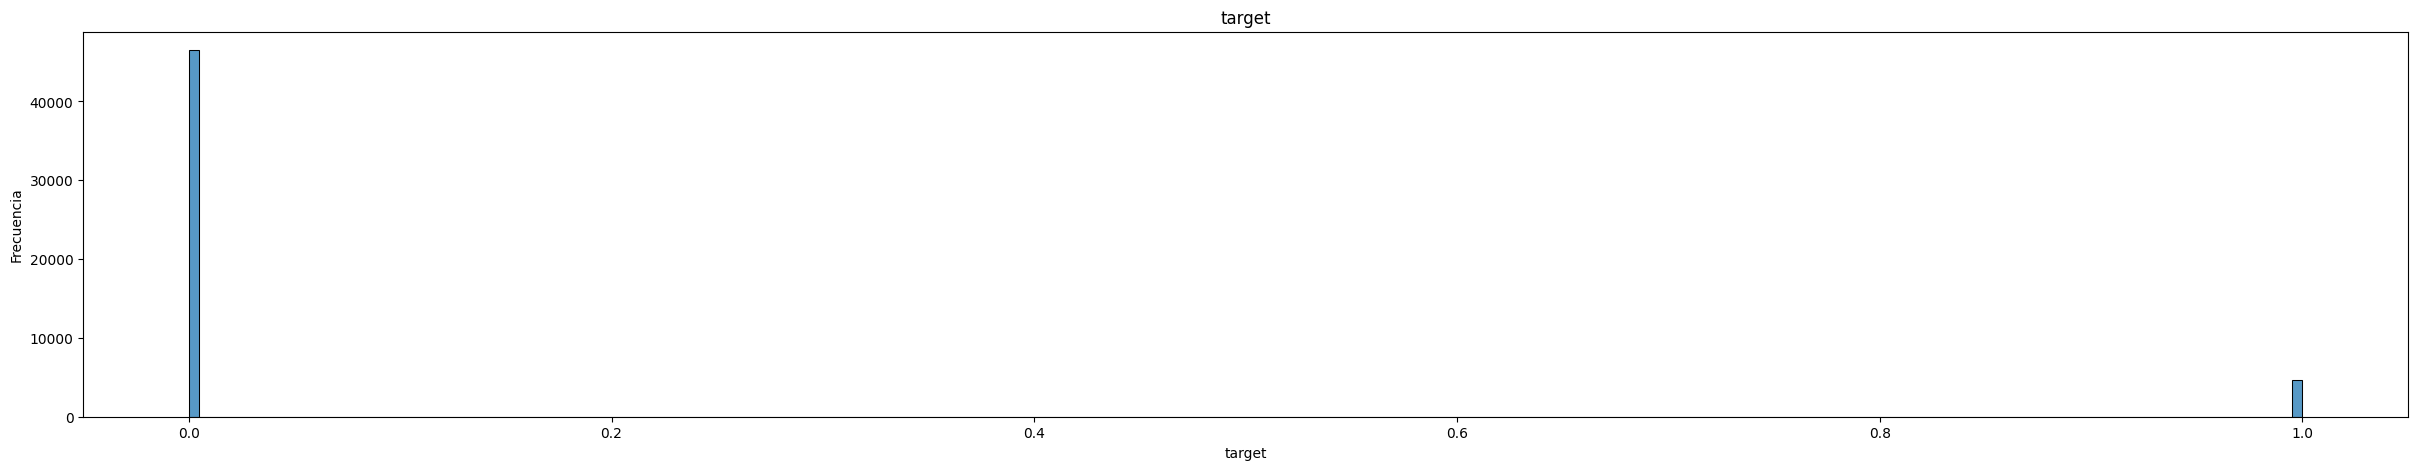

In [12]:
# Definimos las columnas que queremos analizar en detalle
columnas_para_filtrar = ['Edad', 'Region', 'Antiguedad']

# Iteramos sobre cada columna del DataFrame, excluyendo un gran conjunto de columnas
for columna in df_acotado.drop(df_acotado[['Id','FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 
              'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 
              'FacCN_T12', 'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 
              'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12', 'TxsCN_T01', 
              'TxsCN_T02', 'TxsCN_T03', 'TxsCN_T04', 'TxsCN_T05', 'TxsCN_T06', 'TxsCN_T07', 'TxsCN_T08', 
              'TxsCN_T09', 'TxsCN_T10', 'TxsCN_T11', 'TxsCN_T12', 'TxsCI_T01', 'TxsCI_T02', 'TxsCI_T03', 
              'TxsCI_T04', 'TxsCI_T05', 'TxsCI_T06', 'TxsCI_T07', 'TxsCI_T08', 'TxsCI_T09', 'TxsCI_T10', 
              'TxsCI_T11', 'TxsCI_T12', 'UsoL1_T01','UsoL1_T02', 'UsoL1_T03', 'UsoL1_T04', 'UsoL1_T05', 
              'UsoL1_T06', 'UsoL1_T07', 'UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10', 'UsoL1_T11', 'UsoL1_T12', 
              'UsoLI_T01', 'UsoLI_T02', 'UsoLI_T03', 'UsoLI_T04', 'UsoLI_T05', 'UsoLI_T06', 'UsoLI_T07', 
              'UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10', 'UsoLI_T11', 'UsoLI_T12', 
              'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 
              'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12', 
              'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 
              'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12', 
              'FlgAct_T01', 'FlgAct_T02', 'FlgAct_T03', 'FlgAct_T04', 'FlgAct_T05', 'FlgAct_T06', 'FlgAct_T07', 
              'FlgAct_T08', 'FlgAct_T09', 'FlgAct_T10', 'FlgAct_T11', 'FlgAct_T12', 'FacAN_T01', 'FacAN_T02', 
              'FacAN_T03', 'FacAN_T04', 'FacAN_T05', 'FacAN_T06', 'FacAN_T07', 'FacAN_T08', 'FacAN_T09', 
              'FacAN_T10', 'FacAN_T11', 'FacAN_T12', 'FacAI_T01', 'FacAI_T02', 'FacAI_T03', 'FacAI_T04', 
              'FacAI_T05', 'FacAI_T06', 'FacAI_T07', 'FacAI_T08', 'FacAI_T09', 'FacAI_T10', 'FacAI_T11', 
              'FacAI_T12', 'IndRev_T12','IndRev_T11','IndRev_T10','IndRev_T09','IndRev_T08',
              'IndRev_T07','IndRev_T06','IndRev_T05','IndRev_T04','IndRev_T03','IndRev_T02','IndRev_T01']], axis=1):
    plt.figure(figsize=(30, 5))
    sb.histplot(df_acotado[columna], bins=200)
    plt.title(columna)
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

    # Si la columna está en la lista de columnas a filtrar, ajustamos los límites de los ejes x
    if columna in columnas_para_filtrar:
        valor_max = df_acotado[columna].max()
        valor_min = df_acotado[columna].min()
        plt.xticks(np.arange(valor_min, valor_max + 1, step=1))
        plt.show()

### Una vez visto los gráficos, ahora veremos la distribución de los datos, destacando los cuartiles, los valores extremos (outliers) y algunas estadísticas básicas que podremos ver de forma gráfica de tres características posiblemente importantes.

C:\Users\herna\AppData\Local\Temp\ipykernel_21452\1179865995.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=df_acotado[columna], palette='Set2')


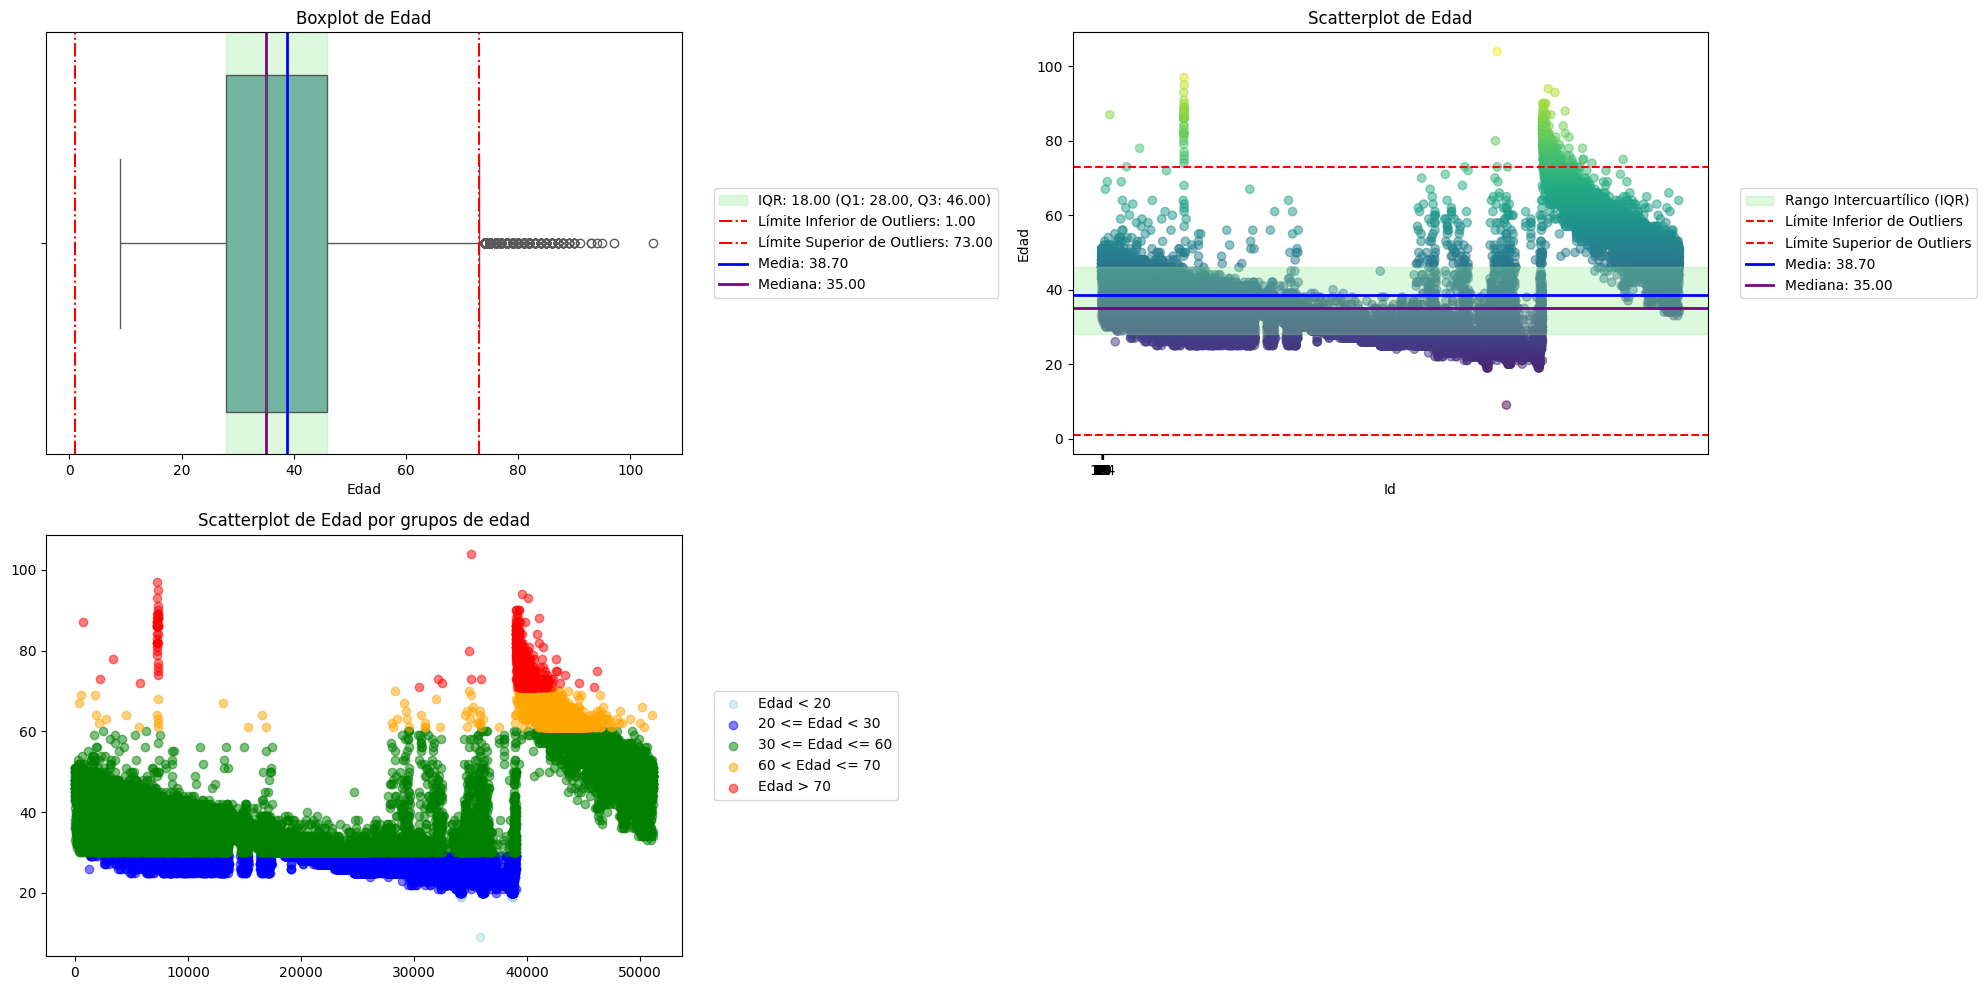

C:\Users\herna\AppData\Local\Temp\ipykernel_21452\1179865995.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=df_acotado[columna], palette='Set2')
C:\Users\herna\AppData\Local\Temp\ipykernel_21452\1179865995.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acotado['Region'] = df_acotado['Region'].fillna(0)  # Llenar NaN con 0 temporalmente


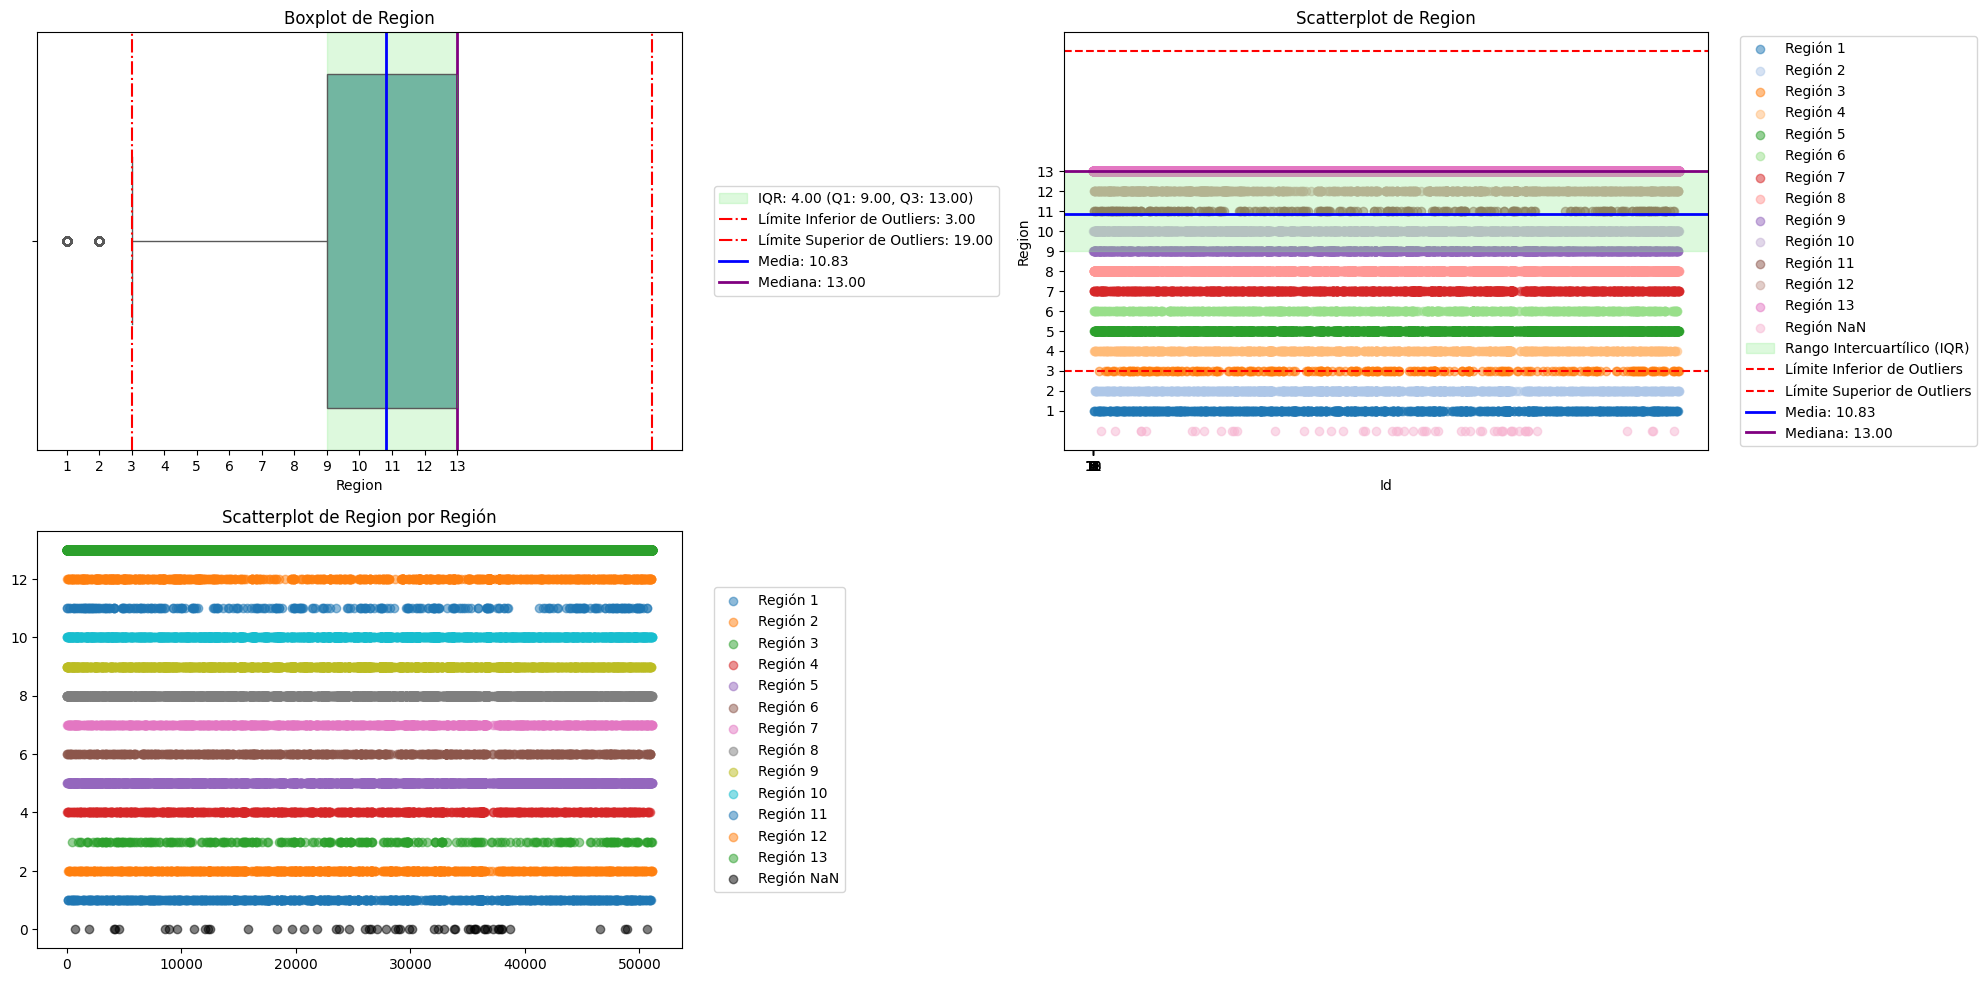

C:\Users\herna\AppData\Local\Temp\ipykernel_21452\1179865995.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=df_acotado[columna], palette='Set2')


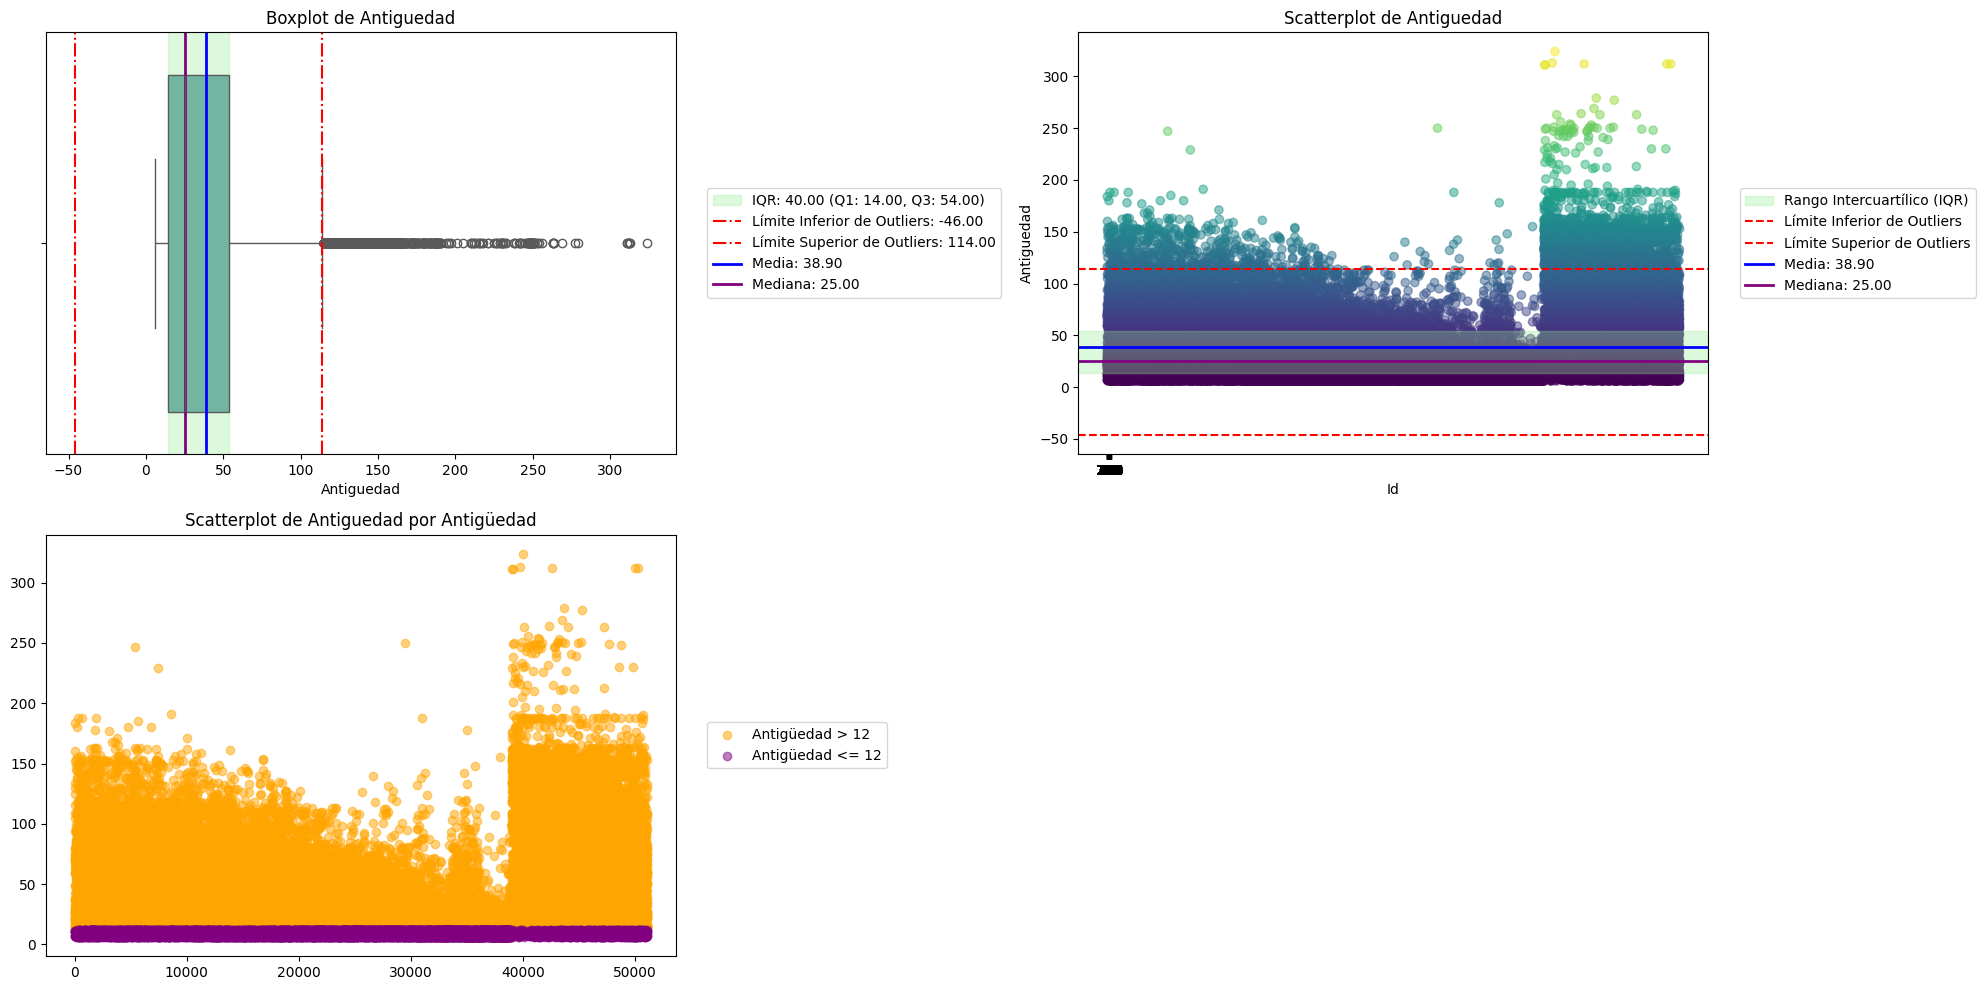

In [13]:
# Lista de columnas a analizar
columnas_a_analizar = ['Edad', 'Region', 'Antiguedad']

# Definir subconjuntos de edad en más rangos
df_sub_edad_menor_20 = df_acotado[df_acotado['Edad'] < 20]
df_sub_edad_joven = df_acotado[(df_acotado['Edad'] >= 20) & (df_acotado['Edad'] < 30)]
df_sub_edad_adulto = df_acotado[(df_acotado['Edad'] >= 30) & (df_acotado['Edad'] <= 60)]
df_sub_edad_mayor = df_acotado[(df_acotado['Edad'] > 60) & (df_acotado['Edad'] <= 70)]
df_sub_edad_mayor_70 = df_acotado[df_acotado['Edad'] > 70]

# Transparencia para los scatterplots
alpha_value = 0.5

# Contar el número de regiones únicas, incluyendo NaN
num_regiones = df_acotado['Region'].nunique()

# Mapa de colores personalizado para las regiones, incluyendo NaN
colores_regiones = sb.color_palette("tab20", num_regiones + 1)  # Incluye un color para NaN

for columna in columnas_a_analizar:
    plt.figure(figsize=(20, 10))
    
    # Cálculo de la media y mediana
    media = df_acotado[columna].mean()
    mediana = df_acotado[columna].median()

    # Cálculo del rango intercuartílico (IQR)
    Q1 = df_acotado[columna].quantile(0.25)
    Q3 = df_acotado[columna].quantile(0.75)
    IQR = Q3 - Q1
    lim_inferior = Q1 - 1.5 * IQR
    lim_superior = Q3 + 1.5 * IQR
    
    # Boxplot con IQR destacado
    plt.subplot(2, 2, 1)
    sb.boxplot(x=df_acotado[columna], palette='Set2')

    # Resaltar el IQR en el boxplot
    plt.axvspan(Q1, Q3, color='lightgreen', alpha=0.3, label=f'IQR: {IQR:.2f} (Q1: {Q1:.2f}, Q3: {Q3:.2f})')
    
    # Líneas para los límites de los outliers
    plt.axvline(lim_inferior, color='red', linestyle='dashdot', label=f'Límite Inferior de Outliers: {lim_inferior:.2f}')
    plt.axvline(lim_superior, color='red', linestyle='dashdot', label=f'Límite Superior de Outliers: {lim_superior:.2f}')
    
    # Líneas para la media y mediana
    plt.axvline(media, color='blue', linestyle='-', label=f'Media: {media:.2f}', linewidth=2)
    plt.axvline(mediana, color='purple', linestyle='-', label=f'Mediana: {mediana:.2f}', linewidth=2)

    # Asegurarse de que los ticks en el eje X sean enteros (solo para la columna Región)
    if columna == 'Region':
        plt.xticks(np.arange(1, num_regiones + 1, step=1), [str(i) for i in range(1, num_regiones + 1)])
    
    plt.title(f'Boxplot de {columna}')
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico
    
    # Scatterplot con transparencia y coloración por valores (Regiones ordenadas)
    plt.subplot(2, 2, 2)
    
    if columna == 'Region':
        # Ordenar las regiones y asignar colores
        df_acotado['Region'] = df_acotado['Region'].fillna(0)  # Llenar NaN con 0 temporalmente
        regiones_ordenadas = np.sort(df_acotado['Region'].unique())  # Ordenar las regiones numéricamente, NaN quedará en 0

        # Separar la etiqueta para Región NaN
        regiones_ordenadas = regiones_ordenadas[regiones_ordenadas != 0]  # Excluir temporalmente Región 0 (NaN)
        regiones_ordenadas = np.append(regiones_ordenadas, 0)  # Añadir Región 0 (NaN) al final

        for idx, region in enumerate(regiones_ordenadas):
            if region == 0:
                label = 'Región NaN'  # Etiqueta para NaN
            else:
                label = f'Región {int(region)}'  # Etiquetas para las regiones numéricas
            
            df_region = df_acotado[df_acotado['Region'] == region]
            plt.scatter(df_region['Id'], df_region['Region'], alpha=alpha_value, label=label, c=[colores_regiones[idx]])

        # Ajustar el eje Y para que muestre los números enteros del 1 al 13
        plt.yticks(np.arange(1, 14, step=1), [str(i) for i in range(1, 14)])
        plt.xticks(np.arange(0, df_acotado['Id'].max(), step=10000))  # Asegura que las regiones se muestren adecuadamente
    else:
        plt.scatter(df_acotado['Id'], df_acotado[columna], alpha=alpha_value, c=df_acotado[columna], cmap='viridis')

    # Resaltar IQR en el scatterplot
    plt.axhspan(Q1, Q3, color='lightgreen', alpha=0.3, label='Rango Intercuartílico (IQR)')
    plt.axhline(lim_inferior, color='red', linestyle='--', label='Límite Inferior de Outliers')
    plt.axhline(lim_superior, color='red', linestyle='--', label='Límite Superior de Outliers')

    # Líneas para la media y mediana en el scatterplot
    plt.axhline(media, color='blue', linestyle='-', label=f'Media: {media:.2f}', linewidth=2)
    plt.axhline(mediana, color='purple', linestyle='-', label=f'Mediana: {mediana:.2f}', linewidth=2)
    
    plt.title(f'Scatterplot de {columna}')
    plt.xlabel('Id')
    plt.ylabel(columna)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico

    # Añadir más ticks en el eje X para columnas específicas
    if columna == 'Edad':
        plt.xticks(np.arange(df_acotado['Edad'].min(), df_acotado['Edad'].max() + 1, step=5))
    elif columna == 'Region':
        plt.xticks(np.arange(1, num_regiones + 1, step=1))  # Mostrar regiones del 1 a num_regiones
    elif columna == 'Antiguedad':
        plt.xticks(np.arange(df_acotado['Antiguedad'].min(), df_acotado['Antiguedad'].max() + 1, step=2))

    # Scatterplot con subconjuntos por grupos de edad, añadiendo nuevos rangos
    plt.subplot(2, 2, 3)
    if columna == 'Edad':
        plt.scatter(df_sub_edad_menor_20['Id'], df_sub_edad_menor_20[columna], alpha=alpha_value, label='Edad < 20', c='lightblue')
        plt.scatter(df_sub_edad_joven['Id'], df_sub_edad_joven[columna], alpha=alpha_value, label='20 <= Edad < 30', c='blue')
        plt.scatter(df_sub_edad_adulto['Id'], df_sub_edad_adulto[columna], alpha=alpha_value, label='30 <= Edad <= 60', c='green')
        plt.scatter(df_sub_edad_mayor['Id'], df_sub_edad_mayor[columna], alpha=alpha_value, label='60 < Edad <= 70', c='orange')
        plt.scatter(df_sub_edad_mayor_70['Id'], df_sub_edad_mayor_70[columna], alpha=alpha_value, label='Edad > 70', c='red')
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico
        plt.title(f'Scatterplot de {columna} por grupos de edad')

    elif columna == 'Region':
        # Scatterplot con valores NaN en negro
        for region in regiones_ordenadas:
            if region == 0:
                df_region_nan = df_acotado[df_acotado['Region'] == 0]  # Filtrar Región NaN
                plt.scatter(df_region_nan['Id'], df_region_nan['Region'], alpha=alpha_value, label='Región NaN', c='black')
            else:
                df_region = df_acotado[df_acotado['Region'] == region]
                plt.scatter(df_region['Id'], df_region[columna], alpha=alpha_value, label=f'Región {int(region)}')

        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico
        plt.title(f'Scatterplot de {columna} por Región')

    elif columna == 'Antiguedad':
        # Subconjuntos de antigüedad
        df_sub_antiguo = df_acotado[df_acotado['Antiguedad'] > 12]
        df_sub_nuevo = df_acotado[df_acotado['Antiguedad'] <= 12]
        plt.scatter(df_sub_antiguo['Id'], df_sub_antiguo[columna], alpha=alpha_value, label='Antigüedad > 12', c='orange')
        plt.scatter(df_sub_nuevo['Id'], df_sub_nuevo[columna], alpha=alpha_value, label='Antigüedad <= 12', c='purple')
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)  # Leyenda fuera del gráfico
        plt.title(f'Scatterplot de {columna} por Antigüedad')

    # Ajustar diseño para evitar solapamientos
    plt.tight_layout()  
    plt.show()

### A continuación revisaremos los datos de la columna Región para saber exactamente cómo se distribuyen los clientes a lo largo del país.

In [14]:
region = df_acotado['Region']
region.unique()

array([13.,  9., 10.,  8.,  7.,  6.,  5., 12., 11.,  4.,  1.,  2.,  3.,
        0.])

### Revisamos un poco de estadística básica.

In [15]:
# Eliminar los valores NaN en la columna 'Region'
df_acotado['Region'].dropna(inplace=True)

# Eliminar los valores 0 de la columna 'Region'
df_acotado = df_acotado[df_acotado['Region'] != 0]

# Mostrar las estadísticas descriptivas de la columna 'Region'
print(df_acotado['Region'].describe())

# Mostrar los valores únicos en la columna 'Region'
print(df_acotado['Region'].unique())


count    51071.000000
mean        10.828220
std          3.392703
min          1.000000
25%          9.000000
50%         13.000000
75%         13.000000
max         13.000000
Name: Region, dtype: float64
[13.  9. 10.  8.  7.  6.  5. 12. 11.  4.  1.  2.  3.]


C:\Users\herna\AppData\Local\Temp\ipykernel_21452\2994265869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acotado['Region'].dropna(inplace=True)


### Verificamos que estamos tratando el número de la región como un dato entero.

In [16]:
region = df_acotado['Region']
region = region.astype(int)
region.unique()

array([13,  9, 10,  8,  7,  6,  5, 12, 11,  4,  1,  2,  3])

### Y seleccionados los rangos que se mostrarán en el gráfico.

In [17]:
# Los gráficos de torta contarán el número datos entre los rangos y lo mostraremos en un gráfico.
n1 = region.loc[region == 1].count()
n2 = region.loc[region == 2].count()
n3 = region.loc[region == 3].count()
n4 = region.loc[region == 4].count()
n5 = region.loc[region == 5].count()
n6 = region.loc[region == 6].count()
n7 = region.loc[region == 7].count()
n8 = region.loc[region == 8].count()
n9 = region.loc[region == 9].count()
n10 = region.loc[region == 10].count()
n11 = region.loc[region == 11].count()
n12 = region.loc[region == 12].count()
n13 = region.loc[region == 13].count()
print(n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13)

979 1072 294 889 3489 718 1331 3768 2143 2177 291 985 32935


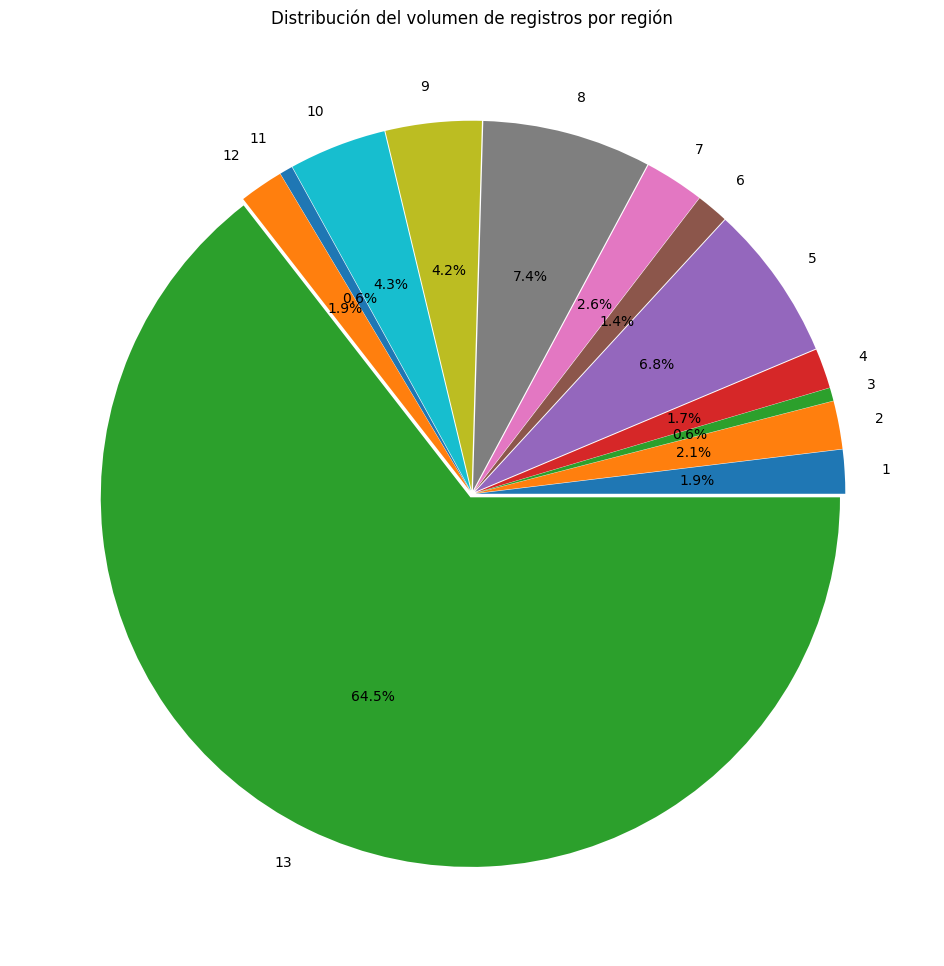

In [18]:
#Formato del grafico circular
datos = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13]

# Separación de cada trozo de la torta al centro 
exp = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

# Etiquetas de cada trozo
m = ["1","2","3","4","5","6","7","8","9","10","11","12","13"]

plt.figure(figsize=(12,12))

plt.title("Distribución del volumen de registros por región")
plt.pie(datos, labels = m, explode = exp, autopct='%2.1f%%')
plt.show()

# Fase 3 - Data Preparation

En la fase de Preparación de Datos consiste en transformar los datos crudos en un formato apto para análisis y modelado. Esto implica limpiar los datos (corrigiendo errores, completando valores faltantes), transformarlos (normalizando, estandarizando), construir muestras representativas y crear nuevas variables si es necesario.

Como pudimos apreciar anteriormente, todas las columnas poseen datos tipo object, por lo tanto, tenemos que transformar cada columna a su mejor tipo de dato. *IMPORTANTE* Por ahora vamos a trabajar solamente con algunas cuantas columnas que utilizaremos para hacer un tipo de testeo de imputación de datos, además de hacer un pequeño análisis antes de explorar todos los datos como conjunto.

In [19]:
# Crear una copia del DataFrame para modificar los tipos de datos
df_nuevos_dtype = df_acotado.copy()

# Columnas que deben ser enteros
columnas_enteros = [
    'Id', 'Edad', 'Region', 'TC', 'Cuentas', 'Hipotecario', 
    'Consumo', 'Debito', 'Ctacte', 'Antiguedad', 'Dualidad', 'target'
]
for col in columnas_enteros:
    df_nuevos_dtype[col] = df_nuevos_dtype[col].astype('int64')

# Convertir columnas de tipo float64
columnas_flotantes = [col for col in df_nuevos_dtype.columns if col not in columnas_enteros + ['Sexo', 'IndRev_T12', 'IndRev_T11', 'IndRev_T10', 'IndRev_T09', 'IndRev_T08', 'IndRev_T07', 'IndRev_T06', 'IndRev_T05', 'IndRev_T04', 'IndRev_T03', 'IndRev_T02', 'IndRev_T01']]
df_nuevos_dtype[columnas_flotantes] = df_nuevos_dtype[columnas_flotantes].astype('float64')

# Convertir columnas de tipo object
columnas_objeto = ['Sexo', 'IndRev_T12', 'IndRev_T11', 'IndRev_T10', 'IndRev_T09', 'IndRev_T08', 'IndRev_T07', 'IndRev_T06', 'IndRev_T05', 'IndRev_T04', 'IndRev_T03', 'IndRev_T02', 'IndRev_T01']
df_nuevos_dtype[columnas_objeto] = df_nuevos_dtype[columnas_objeto].astype('object')

# Verificar tipos de datos
for i in df_nuevos_dtype:
    print(f"{i} = {df_nuevos_dtype[i].dtype} \n")


Id = int64 

Edad = int64 

Renta = float64 

Region = int64 

Sexo = object 

TC = int64 

Cuentas = int64 

Hipotecario = int64 

Consumo = int64 

Debito = int64 

Ctacte = int64 

Antiguedad = int64 

Dualidad = int64 

FacCN_T01 = float64 

FacCN_T02 = float64 

FacCN_T03 = float64 

FacCN_T04 = float64 

FacCN_T05 = float64 

FacCN_T06 = float64 

FacCN_T07 = float64 

FacCN_T08 = float64 

FacCN_T09 = float64 

FacCN_T10 = float64 

FacCN_T11 = float64 

FacCN_T12 = float64 

FacCI_T01 = float64 

FacCI_T02 = float64 

FacCI_T03 = float64 

FacCI_T04 = float64 

FacCI_T05 = float64 

FacCI_T06 = float64 

FacCI_T07 = float64 

FacCI_T08 = float64 

FacCI_T09 = float64 

FacCI_T10 = float64 

FacCI_T11 = float64 

FacCI_T12 = float64 

TxsCN_T01 = float64 

TxsCN_T02 = float64 

TxsCN_T03 = float64 

TxsCN_T04 = float64 

TxsCN_T05 = float64 

TxsCN_T06 = float64 

TxsCN_T07 = float64 

TxsCN_T08 = float64 

TxsCN_T09 = float64 

TxsCN_T10 = float64 

TxsCN_T11 = float64 

TxsCN_

### [MODIFICAR] Ahora vamos a eliminar todas las filas que contengan valor nulo en la columna "Renta" y en la columna "Region", ya que según contexto, todos los clientes ingresados en el Dataset original, tienen alguna relación con la tenencia de tarjeta de crédito, la cual tiene como por prerrequisito, tener una renta mínima en el sistema.

### Tomaremos a la Región 13, ya que concentra la mayor cantidad de datos.

In [20]:
#df_limpio = df_nuevos_dtype.dropna(subset=['Renta'])
#df_limpio = df_nuevos_dtype['Renta'].dropna(inplace=True)

df_acotado_x_region = df_nuevos_dtype[df_nuevos_dtype['Region'] == 13]

In [21]:

for d in df_acotado_x_region:
    print(f"{d} = {df_acotado_x_region[d].info()} \n")
    print(f"{d} = {df_acotado_x_region[d].describe()} \n")

df_acotado_x_region.head(25)

<class 'pandas.core.series.Series'>
Index: 32935 entries, 0 to 51123
Series name: Id
Non-Null Count  Dtype
--------------  -----
32935 non-null  int64
dtypes: int64(1)
memory usage: 514.6 KB
Id = None 

Id = count    32935.000000
mean     25422.027478
std      14808.382727
min          1.000000
25%      12640.500000
50%      25031.000000
75%      38561.500000
max      51124.000000
Name: Id, dtype: float64 

<class 'pandas.core.series.Series'>
Index: 32935 entries, 0 to 51123
Series name: Edad
Non-Null Count  Dtype
--------------  -----
32935 non-null  int64
dtypes: int64(1)
memory usage: 514.6 KB
Edad = None 

Edad = count    32935.000000
mean        38.897161
std         13.204920
min         19.000000
25%         29.000000
50%         35.000000
75%         46.000000
max         97.000000
Name: Edad, dtype: float64 

<class 'pandas.core.series.Series'>
Index: 32935 entries, 0 to 51123
Series name: Renta
Non-Null Count  Dtype  
--------------  -----  
25163 non-null  float64
dtypes: fl

,Id,Edad,Renta,Region,Sexo,TC,Cuentas,Hipotecario,Consumo,Debito,...,IndRev_T10,IndRev_T09,IndRev_T08,IndRev_T07,IndRev_T06,IndRev_T05,IndRev_T04,IndRev_T03,IndRev_T02,IndRev_T01
0,1,43,NaN,13,M,3,1,0,0,1,...,R,R,R,R,R,R,R,R,R,R
1,2,46,143640.0,13,H,1,1,1,0,0,...,R,R,R,R,R,R,R,R,R,R
2,3,45,929106.0,13,H,2,1,1,0,1,...,T,T,T,T,T,T,T,T,T,T
3,4,46,172447.0,13,H,2,1,0,0,0,...,R,R,R,R,R,R,R,R,R,R
4,5,46,805250.0,13,H,3,2,1,0,0,...,T,T,T,T,T,T,T,R,T,R
5,6,47,707664.0,13,H,2,1,0,0,1,...,R,T,T,R,R,R,T,P,R,R
6,7,48,1022833.0,13,H,2,2,0,0,1,...,R,R,R,R,R,R,R,R,R,T
7,8,46,NaN,13,H,3,2,0,0,1,...,T,P,R,R,R,R,R,R,R,R
8,9,49,1171066.0,13,H,1,1,0,0,1,...,R,R,R,R,R,R,R,R,R,R
9,10,44,964387.0,13,M,3,1,1,0,1,...,R,R,R,R,R,R,R,R,R,R


### Vamos a dejar afuera algunas variables que no utilizaremos.

In [22]:
#cantidad_nan_renta = df_acotado_x_region['Renta'].isnull().sum()
##cantidad_nan_region = df_acotado_x_region['Region'].isnull().sum()
#print("Cantidad de NaN en Renta:", cantidad_nan_renta)
#print("Cantidad de NaN en Region:", cantidad_nan_renta)

df_acotado_parte2 = df_acotado_x_region[['FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 
                                         'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 
                                         'FacCN_T11', 'FacCN_T12', 'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 
                                         'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 
                                         'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12']]

df_acotado_x_region = df_acotado_x_region.drop(df_acotado_x_region[['Dualidad', 'Consumo', 'Ctacte', 'Debito', 'Hipotecario',
'TxsCN_T01', 'TxsCN_T02', 'TxsCN_T03', 'TxsCN_T04', 'TxsCN_T05', 'TxsCN_T06', 'TxsCN_T07', 'TxsCN_T08', 'TxsCN_T09', 'TxsCN_T10', 'TxsCN_T11', 'TxsCN_T12',
'TxsCI_T01', 'TxsCI_T02', 'TxsCI_T03', 'TxsCI_T04', 'TxsCI_T05', 'TxsCI_T06', 'TxsCI_T07', 'TxsCI_T08', 'TxsCI_T09', 'TxsCI_T10', 'TxsCI_T11', 'TxsCI_T12',
'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10','FacCN_T11', 'FacCN_T12', 
'FacCI_T01', 'FacCI_T02', 'FacCI_T03','FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
'UsoL1_T01','UsoL1_T02', 'UsoL1_T03', 'UsoL1_T04', 'UsoL1_T05', 'UsoL1_T06', 'UsoL1_T07', 'UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10', 'UsoL1_T11', 'UsoL1_T12', 
'UsoLI_T01', 'UsoLI_T02', 'UsoLI_T03', 'UsoLI_T04', 'UsoLI_T05', 'UsoLI_T06', 'UsoLI_T07', 'UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10', 'UsoLI_T11', 'UsoLI_T12', 
'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 
'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12', 
'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 
'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12', 
'FlgAct_T01', 'FlgAct_T02', 'FlgAct_T03', 'FlgAct_T04', 'FlgAct_T05', 'FlgAct_T06', 'FlgAct_T07', 
'FlgAct_T08', 'FlgAct_T09', 'FlgAct_T10', 'FlgAct_T11', 'FlgAct_T12', 'FacAN_T01', 'FacAN_T02', 
'FacAN_T03', 'FacAN_T04', 'FacAN_T05', 'FacAN_T06', 'FacAN_T07', 'FacAN_T08', 'FacAN_T09', 
'FacAN_T10', 'FacAN_T11', 'FacAN_T12', 'FacAI_T01', 'FacAI_T02', 'FacAI_T03', 'FacAI_T04', 
'FacAI_T05', 'FacAI_T06', 'FacAI_T07', 'FacAI_T08', 'FacAI_T09', 'FacAI_T10', 'FacAI_T11', 
'FacAI_T12', 'IndRev_T12','IndRev_T11','IndRev_T10','IndRev_T09','IndRev_T08',
'IndRev_T07','IndRev_T06','IndRev_T05','IndRev_T04','IndRev_T03','IndRev_T02','IndRev_T01']], axis=1)

# Concatenar df_acotado_x_region y df_acotado_parte2 horizontalmente
df_acotado_x_region = pd.concat([df_acotado_x_region, df_acotado_parte2], axis=1)

# Verificar los primeros registros para confirmar la unión
df_acotado_x_region.head(20)

,Id,Edad,Renta,Region,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,...,FacCI_T03,FacCI_T04,FacCI_T05,FacCI_T06,FacCI_T07,FacCI_T08,FacCI_T09,FacCI_T10,FacCI_T11,FacCI_T12
0,1,43,NaN,13,M,3,1,130,798000.0,1210.0,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
1,2,46,143640.0,13,H,1,1,69,750000.0,1000.0,...,0.0000,0.0,0.0,195714.1682,0.0,0.0,0.0,187225.2092,0.0,0.0
2,3,45,929106.0,13,H,2,1,24,1350000.0,1500.0,...,0.0000,0.0,0.0,0.0000,102577.0,0.0,0.0,0.0000,0.0,0.0
3,4,46,172447.0,13,H,2,1,134,1570800.0,0.0,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
4,5,46,805250.0,13,H,3,2,116,2762000.0,6430.0,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
5,6,47,707664.0,13,H,2,1,67,1312500.0,714.0,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
6,7,48,1022833.0,13,H,2,2,21,813000.0,600.0,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
7,8,46,NaN,13,H,3,2,69,1242000.0,1255.0,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
8,9,49,1171066.0,13,H,1,1,33,1996400.0,2000.0,...,68583.6496,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
9,10,44,964387.0,13,M,3,1,23,672000.0,1000.0,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0


In [23]:
# Función para calcular los promedios mensuales
def calcular_promedios_mensuales(df):
    # Calcular el promedio de las columnas FacCN_T01 a FacCN_T12
    df['FacCN_mensual'] = df[['FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 
                              'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 
                              'FacCN_T11', 'FacCN_T12']].mean(axis=1).round(0)
    
    # Calcular el promedio de las columnas FacCI_T01 a FacCI_T12
    df['FacCI_mensual'] = df[['FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 
                              'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 
                              'FacCI_T11', 'FacCI_T12']].mean(axis=1).round(0)
    
    return df

# Función para calcular el gasto anual
def calcular_gasto_anual(df):
    # Sumar los valores de las columnas FacCN_T01 a FacCN_T12 para obtener FacCN_anual
    df['FacCN_anual'] = df[['FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 
                            'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 
                            'FacCN_T11', 'FacCN_T12']].sum(axis=1).round(0)
    
    # Sumar los valores de las columnas FacCI_T01 a FacCI_T12 para obtener FacCI_anual
    df['FacCI_anual'] = df[['FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 
                            'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 
                            'FacCI_T11', 'FacCI_T12']].sum(axis=1).round(0)
    
    return df

# Aplicar ambas funciones para obtener el DataFrame con los promedios mensuales y gastos anuales
df_acotado_x_region = calcular_promedios_mensuales(df_acotado_x_region)
df_acotado_x_region = calcular_gasto_anual(df_acotado_x_region)

# Eliminar las columnas FacCN_T01 a FacCN_T12 y FacCI_T01 a FacCI_T12
df_acotado_x_region = df_acotado_x_region.drop(df_acotado_x_region[['FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 
                                         'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 
                                         'FacCN_T11', 'FacCN_T12', 'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 
                                         'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 
                                         'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12']], axis=1)

# Mostrar las primeras 50 filas del DataFrame resultante
df_acotado_x_region.head(50)

,Id,Edad,Renta,Region,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual
0,1,43,NaN,13,M,3,1,130,798000.0,1210.0,0,32185.0,0.0,386223.0,0.0
1,2,46,143640.0,13,H,1,1,69,750000.0,1000.0,0,81007.0,31912.0,972082.0,382939.0
2,3,45,929106.0,13,H,2,1,24,1350000.0,1500.0,0,140434.0,8548.0,1685212.0,102577.0
3,4,46,172447.0,13,H,2,1,134,1570800.0,0.0,0,34524.0,0.0,414286.0,0.0
4,5,46,805250.0,13,H,3,2,116,2762000.0,6430.0,0,293939.0,0.0,3527268.0,0.0
5,6,47,707664.0,13,H,2,1,67,1312500.0,714.0,0,60771.0,0.0,729254.0,0.0
6,7,48,1022833.0,13,H,2,2,21,813000.0,600.0,0,142519.0,0.0,1710229.0,0.0
7,8,46,NaN,13,H,3,2,69,1242000.0,1255.0,0,39668.0,0.0,476012.0,0.0
8,9,49,1171066.0,13,H,1,1,33,1996400.0,2000.0,1,21788.0,5715.0,261459.0,68584.0
9,10,44,964387.0,13,M,3,1,23,672000.0,1000.0,0,47572.0,0.0,570867.0,0.0


### Revisamos la cantidad de 0s en la columna Region.

In [24]:
# Contar los ceros en la columna Region
cantidad_ceros_region = (df_acotado_x_region['Region'] == 0).sum()

if cantidad_ceros_region > 0:
    print(f"Hay {cantidad_ceros_region} valores 0 en la columna Region.")
else:
    print("No hay valores 0 en la columna Region.")

No hay valores 0 en la columna Region.


### Hacemos una pequeña estadística de los datos por cada columna, para tener mejor idea de los datos con los que estamos trabajando.

In [25]:
for i in df_acotado_x_region:
  print(f"{i} = {df_acotado_x_region[i].describe()} \n")

Id = count    32935.000000
mean     25422.027478
std      14808.382727
min          1.000000
25%      12640.500000
50%      25031.000000
75%      38561.500000
max      51124.000000
Name: Id, dtype: float64 

Edad = count    32935.000000
mean        38.897161
std         13.204920
min         19.000000
25%         29.000000
50%         35.000000
75%         46.000000
max         97.000000
Name: Edad, dtype: float64 

Renta = count    2.516300e+04
mean     6.667516e+05
std      4.001187e+05
min      1.000000e+00
25%      4.209665e+05
50%      5.711190e+05
75%      8.188455e+05
max      8.870997e+06
Name: Renta, dtype: float64 

Region = count    32935.0
mean        13.0
std          0.0
min         13.0
25%         13.0
50%         13.0
75%         13.0
max         13.0
Name: Region, dtype: float64 

Sexo = count     32935
unique        2
top           H
freq      17490
Name: Sexo, dtype: object 

TC = count    32935.000000
mean         1.774677
std          0.902230
min          1.00000

### Revisamos los valor únicos que tiene cada columna.

In [26]:
for i in df_acotado_x_region:
    print(f"{i} = {df_acotado_x_region[i].unique()} \n")

Id = [    1     2     3 ... 51122 51123 51124] 

Edad = [43 46 45 47 48 49 44 38 36 51 37 50 41 39 42 40 32 34 35 33 31 52 53 30
 87 55 29 54 59 69 56 62 60 27 63 28 26 64 25 61 83 86 80 93 79 82 84 97
 88 91 68 89 90 75 57 77 95 67 65 24 22 58 23 71 21 20 19 70 85 73 81 78
 76 72 74 66 94] 

Renta = [    nan 143640. 929106. ... 625376. 806220. 840878.] 

Region = [13] 

Sexo = ['M' 'H'] 

TC = [ 3  1  2  4  5  6  8  7 12 10  9 11] 

Cuentas = [1 2 3 4 5] 

Antiguedad = [130  69  24 134 116  67  21  33  23  38  80  13   7  22  72  94  18 184
  49  14 109 105  27  78  60 152  10  28  19  26  75  70  48  74  15  30
  61  36   8  87  35 145  16  47  20  39   9  25  84  73  92  50  65  99
  96  83  64  59  32 180   6 117  68  93  82 107  79  31  63  53  56  11
  81  58  57  45 188 108  44  37  52  97 119 148  54  41 149  66  71 155
 113  34  29 143  43 110 106 120  85  98  12  51  40  42 140 150 131 101
 127  17  77 122  95  88 100 142 151  86 112  55 121 154 118 137 126  90
  62 133  46 1

In [27]:
for i in df_acotado_x_region.columns:
    try:
        unique_values = df_acotado_x_region[i].unique()
        print(f"{i} = {unique_values} \n")
    except AttributeError as e:
        print(f"Error en la columna '{i}': {e}")

Id = [    1     2     3 ... 51122 51123 51124] 

Edad = [43 46 45 47 48 49 44 38 36 51 37 50 41 39 42 40 32 34 35 33 31 52 53 30
 87 55 29 54 59 69 56 62 60 27 63 28 26 64 25 61 83 86 80 93 79 82 84 97
 88 91 68 89 90 75 57 77 95 67 65 24 22 58 23 71 21 20 19 70 85 73 81 78
 76 72 74 66 94] 

Renta = [    nan 143640. 929106. ... 625376. 806220. 840878.] 

Region = [13] 

Sexo = ['M' 'H'] 

TC = [ 3  1  2  4  5  6  8  7 12 10  9 11] 

Cuentas = [1 2 3 4 5] 

Antiguedad = [130  69  24 134 116  67  21  33  23  38  80  13   7  22  72  94  18 184
  49  14 109 105  27  78  60 152  10  28  19  26  75  70  48  74  15  30
  61  36   8  87  35 145  16  47  20  39   9  25  84  73  92  50  65  99
  96  83  64  59  32 180   6 117  68  93  82 107  79  31  63  53  56  11
  81  58  57  45 188 108  44  37  52  97 119 148  54  41 149  66  71 155
 113  34  29 143  43 110 106 120  85  98  12  51  40  42 140 150 131 101
 127  17  77 122  95  88 100 142 151  86 112  55 121 154 118 137 126  90
  62 133  46 1

## Identificación de Valores Faltantes
### En este paso, identificamos las columnas que contienen valores faltantes dentro del dataset. Esto es importante ya que los algoritmos de Machine Learning generalmente no funcionan bien con datos incompletos. Visualizamos estos valores faltantes usando un mapa de calor para identificar qué columnas requieren atención.

In [28]:
# Revisamos cuántos valores faltantes hay por columna
# Iterar por cada columna del DataFrame
for columna in df_acotado_x_region.columns:
    total_faltantes = df_acotado_x_region[columna].isna().sum()
    porcentaje_faltantes = (df_acotado_x_region[columna].isna().mean() * 100)
    tipo_dato = df_acotado_x_region[columna].dtype

    # Mostrar la información de la columna actual
    print(f"Columna: {columna}")
    print(f"  - Total Faltantes: {total_faltantes}")
    print(f"  - Porcentaje Faltantes: {porcentaje_faltantes:.2f}%")
    print(f"  - Tipo de Dato: {tipo_dato}")
    print("-" * 40)


Columna: Id
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Edad
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Renta
  - Total Faltantes: 7772
  - Porcentaje Faltantes: 23.60%
  - Tipo de Dato: float64
----------------------------------------
Columna: Region
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Sexo
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: object
----------------------------------------
Columna: TC
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Cuentas
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Antiguedad
  - Total Faltantes: 0
  - Porcen

### Eliminamos la columna Región.

In [29]:
df_acotado_x_region = df_acotado_x_region.drop('Region', axis=1)
#df_acotado_x_region = df_acotado_x_region.drop('Id', axis=1)
# df_acotado_x_region.to_csv('/Users/herna/Desktop/df_acotado_new.csv')

## Detección y Manejo de Outliers
### Los outliers pueden influir negativamente en los resultados del análisis y el modelado. Aquí, utilizamos el método del rango intercuartil (IQR) para identificar y eliminar los outliers en las variables numéricas, asegurando que no distorsionen las relaciones entre las variables.

Outliers detectados en 'Edad': 737


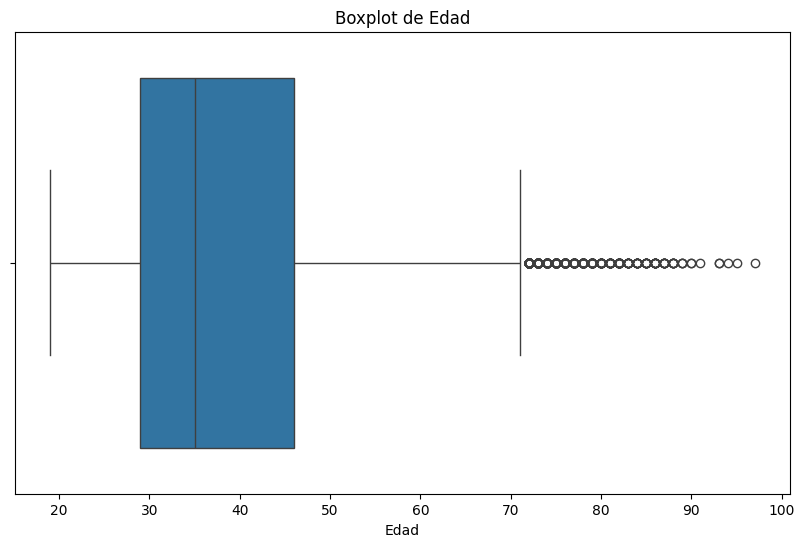

Outliers detectados en 'Renta': 999


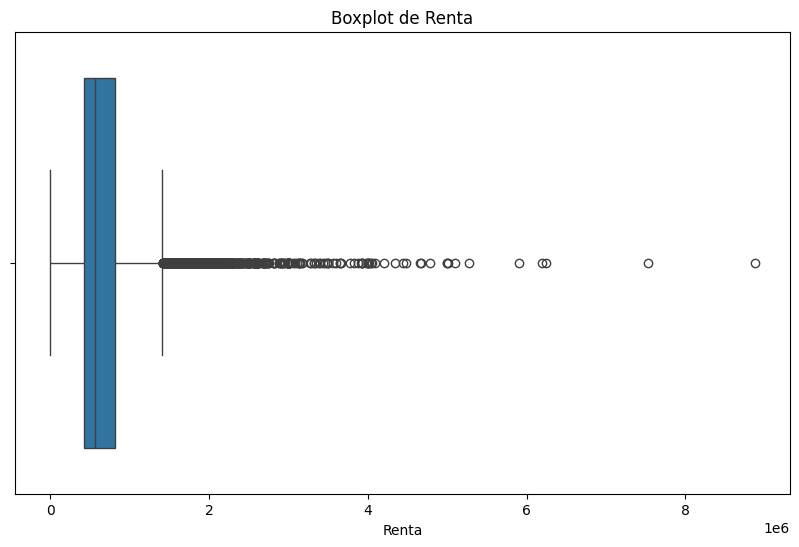

Outliers detectados en 'Antiguedad': 1528


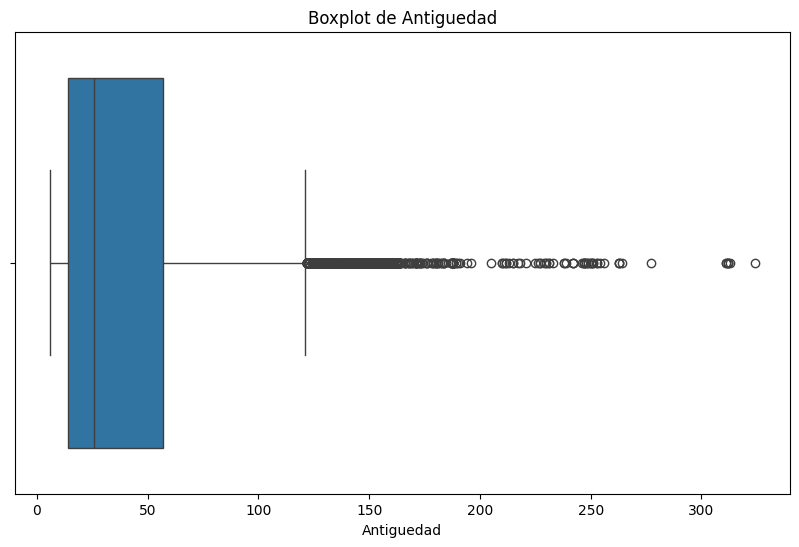

Outliers detectados en 'CUPO_L1': 1547


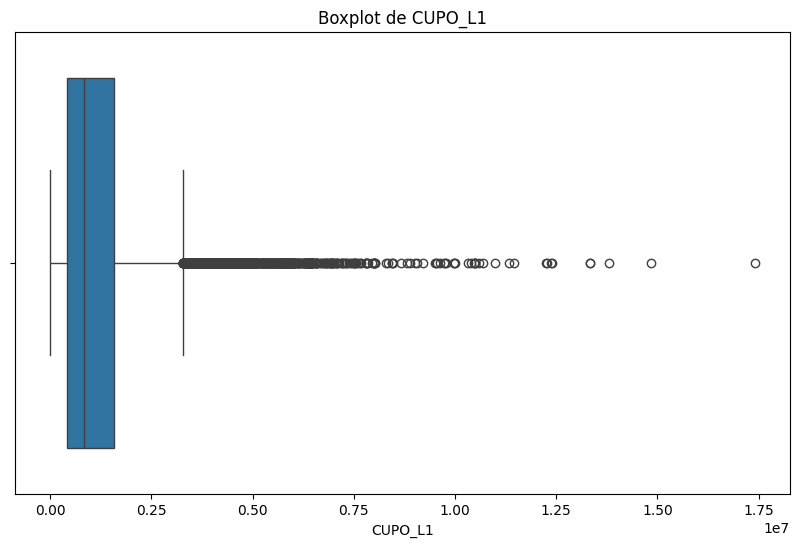

Outliers detectados en 'CUPO_MX': 1803


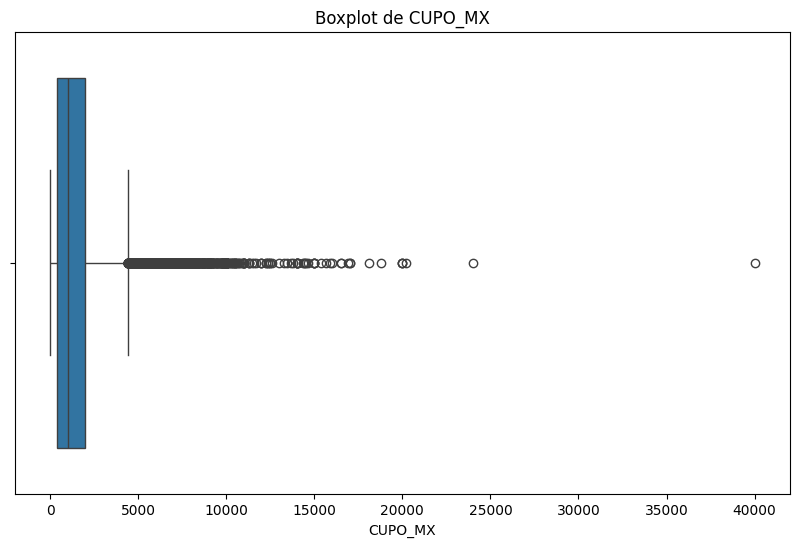

Filas después de eliminar outliers: 28362


,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual
1,2,46,143640.0,H,1,1,69,750000.0,1000.0,0,81007.0,31912.0,972082.0,382939.0
2,3,45,929106.0,H,2,1,24,1350000.0,1500.0,0,140434.0,8548.0,1685212.0,102577.0
5,6,47,707664.0,H,2,1,67,1312500.0,714.0,0,60771.0,0.0,729254.0,0.0
6,7,48,1022833.0,H,2,2,21,813000.0,600.0,0,142519.0,0.0,1710229.0,0.0
7,8,46,NaN,H,3,2,69,1242000.0,1255.0,0,39668.0,0.0,476012.0,0.0
8,9,49,1171066.0,H,1,1,33,1996400.0,2000.0,1,21788.0,5715.0,261459.0,68584.0
9,10,44,964387.0,M,3,1,23,672000.0,1000.0,0,47572.0,0.0,570867.0,0.0
12,13,36,1263238.0,H,1,1,80,500000.0,1500.0,0,34997.0,0.0,244980.0,0.0
14,15,48,592541.0,H,1,1,13,400000.0,1000.0,0,53748.0,0.0,644970.0,0.0
15,16,46,NaN,H,2,2,7,800000.0,1200.0,0,38073.0,57113.0,304585.0,456903.0


In [30]:
# Suponiendo que df_acotado_x_region es el dataframe original
df_acotado_x_region_v2 = df_acotado_x_region.copy()

# Listado de columnas numéricas relevantes para detectar outliers
num_columnas = ['Edad', 'Renta', 'Antiguedad', 'CUPO_L1', 'CUPO_MX']

# Función para detectar outliers con el método IQR en cualquier columna numérica
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    # Definir los límites para identificar los outliers
    outliers = df[(df[columna] < (Q1 - 1.5 * IQR)) | (df[columna] > (Q3 + 1.5 * IQR))]
    return outliers

# Visualización de outliers con gráficos de caja para una columna
def visualizar_outliers(df, columna):
    plt.figure(figsize=(10, 6))
    sb.boxplot(x=df[columna])
    plt.title(f'Boxplot de {columna}')
    plt.show()

# Detección, visualización y eliminación de outliers para todas las columnas numéricas
all_outliers = pd.DataFrame()  # Para acumular todos los outliers detectados

for columnas in num_columnas:
    # Detectar outliers en la columna actual
    outliers_col = detectar_outliers(df_acotado_x_region_v2, columnas)
    print(f"Outliers detectados en '{columnas}': {outliers_col.shape[0]}")
    
    # Visualizar los outliers en la columna actual
    visualizar_outliers(df_acotado_x_region_v2, columnas)
    
    # Acumular los outliers detectados
    all_outliers = pd.concat([all_outliers, outliers_col])

# Eliminar los outliers detectados de todas las columnas
df_acotado_x_region_v2 = df_acotado_x_region_v2[~df_acotado_x_region_v2.index.isin(all_outliers.index)]

# Mostrar el número de filas después de eliminar los outliers
print(f"Filas después de eliminar outliers: {df_acotado_x_region_v2.shape[0]}")

# Ver los primeros 25 registros después de eliminar outliers
df_acotado_x_region_v2.head(25)


### Imputamos con el modelo Regresión Lineal, porque es más confiable que la imputación con la media o mediana, y se basa en las relaciones entre múltiples variables del dataset, haciendo que las imputaciones sean más precisas.

In [31]:
# Separar los datos con y sin valores faltantes en la columna 'Renta'
con_renta = df_acotado_x_region_v2[df_acotado_x_region_v2['Renta'].notnull()]
sin_renta = df_acotado_x_region_v2[df_acotado_x_region_v2['Renta'].isnull()]

# Definir las columnas predictoras (excluimos 'Renta', 'Unnamed: 0', 'target')
predictores = ['Edad', 'Sexo', 'Cuentas', 'Antiguedad']

# Separar las variables predictoras y la variable objetivo ('Renta')
X = con_renta[predictores]
y = con_renta['Renta']

# Preprocesamiento: OneHotEncoding para la columna 'Sexo' (es categórica)
preprocesador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), ['Sexo'])
], remainder='passthrough')

# Crear un pipeline que combine preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocesador),
    ('model', LinearRegression())
])

# Entrenar el modelo de regresión
pipeline.fit(X, y)

# Ahora usamos este modelo para predecir los valores faltantes de 'Renta'
X_faltantes = sin_renta[predictores]

# Predecir los valores de Renta faltantes
renta_pred = pipeline.predict(X_faltantes)

# Imputar los valores predichos en el dataframe original
df_acotado_x_region_v2.loc[df_acotado_x_region_v2['Renta'].isnull(), 'Renta'] = renta_pred

# Mostrar el dataframe con la columna 'Renta' imputada
df_acotado_x_region_v2.head(50)

,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual
1,2,46,1.436400e+05,H,1,1,69,750000.0,1000.0,0,81007.0,31912.0,972082.0,382939.0
2,3,45,9.291060e+05,H,2,1,24,1350000.0,1500.0,0,140434.0,8548.0,1685212.0,102577.0
5,6,47,7.076640e+05,H,2,1,67,1312500.0,714.0,0,60771.0,0.0,729254.0,0.0
6,7,48,1.022833e+06,H,2,2,21,813000.0,600.0,0,142519.0,0.0,1710229.0,0.0
7,8,46,6.896734e+05,H,3,2,69,1242000.0,1255.0,0,39668.0,0.0,476012.0,0.0
8,9,49,1.171066e+06,H,1,1,33,1996400.0,2000.0,1,21788.0,5715.0,261459.0,68584.0
9,10,44,9.643870e+05,M,3,1,23,672000.0,1000.0,0,47572.0,0.0,570867.0,0.0
12,13,36,1.263238e+06,H,1,1,80,500000.0,1500.0,0,34997.0,0.0,244980.0,0.0
14,15,48,5.925410e+05,H,1,1,13,400000.0,1000.0,0,53748.0,0.0,644970.0,0.0
15,16,46,6.449081e+05,H,2,2,7,800000.0,1200.0,0,38073.0,57113.0,304585.0,456903.0


### Vamos a borrar y verificar los nulos en las columnas del Array.

In [32]:
columnas_a_checkear = ['Edad', 'Renta', 'Sexo', 'TC', 'Cuentas', 'Antiguedad', 'CUPO_L1', 'CUPO_MX', 'target']

# Mostrar la cantidad de filas antes de la limpieza
filas_iniciales = df_acotado_x_region_v2.shape[0]

# Eliminar las filas que contengan valores nulos en las columnas seleccionadas
df_acotado_x_region_v2 = df_acotado_x_region_v2.dropna(subset=columnas_a_checkear)

# Mostrar la cantidad de filas después de la limpieza
filas_limpias = df_acotado_x_region_v2.shape[0]

print(f"Filas iniciales: {filas_iniciales}")
print(f"Filas después de eliminar valores nulos en las columnas seleccionadas: {filas_limpias}")

porcentaje_reduccion = ((filas_iniciales / filas_limpias) * 100) - 100
porcentaje_reduccion_redondeado = round(porcentaje_reduccion, 1)

print(f"Porcentaje de reducción de datos: {porcentaje_reduccion_redondeado}%")

df_acotado_x_region_v2.head(50)

Filas iniciales: 28362
Filas después de eliminar valores nulos en las columnas seleccionadas: 28362
Porcentaje de reducción de datos: 0.0%


,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual
1,2,46,1.436400e+05,H,1,1,69,750000.0,1000.0,0,81007.0,31912.0,972082.0,382939.0
2,3,45,9.291060e+05,H,2,1,24,1350000.0,1500.0,0,140434.0,8548.0,1685212.0,102577.0
5,6,47,7.076640e+05,H,2,1,67,1312500.0,714.0,0,60771.0,0.0,729254.0,0.0
6,7,48,1.022833e+06,H,2,2,21,813000.0,600.0,0,142519.0,0.0,1710229.0,0.0
7,8,46,6.896734e+05,H,3,2,69,1242000.0,1255.0,0,39668.0,0.0,476012.0,0.0
8,9,49,1.171066e+06,H,1,1,33,1996400.0,2000.0,1,21788.0,5715.0,261459.0,68584.0
9,10,44,9.643870e+05,M,3,1,23,672000.0,1000.0,0,47572.0,0.0,570867.0,0.0
12,13,36,1.263238e+06,H,1,1,80,500000.0,1500.0,0,34997.0,0.0,244980.0,0.0
14,15,48,5.925410e+05,H,1,1,13,400000.0,1000.0,0,53748.0,0.0,644970.0,0.0
15,16,46,6.449081e+05,H,2,2,7,800000.0,1200.0,0,38073.0,57113.0,304585.0,456903.0


## Codificación de Variables Categóricas
### Para poder utilizar las variables categóricas en modelos de Machine Learning, es necesario transformarlas en representaciones numéricas. Para esto, utilizamos **Label Encoding** para variables categóricas con pocos valores (como 'Sexo')

In [33]:
# Ver los valores únicos de la columna 'Region'
print(df_acotado_x_region_v2['Sexo'].unique())

# Ver la cantidad de valores únicos
print(f"Cantidad de valores únicos: {df_acotado_x_region_v2['Sexo'].nunique()}")

# Revisar si hay valores nulos en la columna 'Region'
print(f"Cantidad de valores nulos: {df_acotado_x_region_v2['Sexo'].isnull().sum()}")

# Hacer un conteo de la cantidad de veces que aparece cada valor único en la columna 'Region'
print(df_acotado_x_region_v2['Sexo'].value_counts())

['H' 'M']
Cantidad de valores únicos: 2
Cantidad de valores nulos: 0
Sexo
H    14685
M    13677
Name: count, dtype: int64


In [34]:
# Usamos Label Encoding para 'Sexo', ya que solo tiene unos pocos valores
label_encoder = LabelEncoder()
df_acotado_x_region_v2['Sexo'] = label_encoder.fit_transform(df_acotado_x_region_v2['Sexo'])
df_preparado = df_acotado_x_region_v2

df_preparado.head(20)

,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual
1,2,46,1.436400e+05,0,1,1,69,750000.0,1000.0,0,81007.0,31912.0,972082.0,382939.0
2,3,45,9.291060e+05,0,2,1,24,1350000.0,1500.0,0,140434.0,8548.0,1685212.0,102577.0
5,6,47,7.076640e+05,0,2,1,67,1312500.0,714.0,0,60771.0,0.0,729254.0,0.0
6,7,48,1.022833e+06,0,2,2,21,813000.0,600.0,0,142519.0,0.0,1710229.0,0.0
7,8,46,6.896734e+05,0,3,2,69,1242000.0,1255.0,0,39668.0,0.0,476012.0,0.0
8,9,49,1.171066e+06,0,1,1,33,1996400.0,2000.0,1,21788.0,5715.0,261459.0,68584.0
9,10,44,9.643870e+05,1,3,1,23,672000.0,1000.0,0,47572.0,0.0,570867.0,0.0
12,13,36,1.263238e+06,0,1,1,80,500000.0,1500.0,0,34997.0,0.0,244980.0,0.0
14,15,48,5.925410e+05,0,1,1,13,400000.0,1000.0,0,53748.0,0.0,644970.0,0.0
15,16,46,6.449081e+05,0,2,2,7,800000.0,1200.0,0,38073.0,57113.0,304585.0,456903.0


### Ahora salió una incógnita, ya que utilizamos el label encoding para las columnas, necesitamos primeramente identificar qué valores entre 0 y 1 serán los sexos "Masculino" y "Femenino"

In [35]:
columnas_interes = ['Sexo']

conteo_ceros = df_preparado[columnas_interes].apply(lambda x: (x == True).sum())
conteo_unos = df_preparado[columnas_interes].apply(lambda x: (x == False).sum())
conteo_dos = df_preparado[columnas_interes].apply(lambda x: (x.isna()).sum())

resultados_conteo = pd.DataFrame({
    '0': conteo_ceros, # Femenino
    '1': conteo_unos, # Masculino
    '2': conteo_dos # EN el caso de haber quedado valores nulos.

})

print(resultados_conteo)
print("El valor con mayor cantidad serán los hombres ya que logramos apreciar anteriormente que hay más clientes de sexo masculino")
resultados_conteo.head(50)

          0      1  2
0                    
Sexo  13677  14685  0
El valor con mayor cantidad serán los hombres ya que logramos apreciar anteriormente que hay más clientes de sexo masculino


,0,1,2
0,,,
Sexo,13677,14685,0


In [36]:
df_preparado.apply(lambda col: print(f"\nDescripción de la columna '{col.name}':\n", col.describe()))


Descripción de la columna 'Id':
 count    28362.000000
mean     24463.597877
std      14294.476796
min          2.000000
25%      12375.250000
50%      23842.000000
75%      35716.250000
max      51124.000000
Name: Id, dtype: float64

Descripción de la columna 'Edad':
 count    28362.000000
mean        36.684543
std         11.344304
min         19.000000
25%         28.000000
50%         33.000000
75%         43.000000
max         71.000000
Name: Edad, dtype: float64

Descripción de la columna 'Renta':
 count    2.836200e+04
mean     5.998911e+05
std      2.351658e+05
min      1.000000e+00
25%      4.495662e+05
50%      5.675099e+05
75%      7.022698e+05
max      1.414396e+06
Name: Renta, dtype: float64

Descripción de la columna 'Sexo':
 count    28362.000000
mean         0.482230
std          0.499693
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Sexo, dtype: float64

Descripción de la columna 'TC':
 count    283

0
Id               None
Edad             None
Renta            None
Sexo             None
TC               None
Cuentas          None
Antiguedad       None
CUPO_L1          None
CUPO_MX          None
target           None
FacCN_mensual    None
FacCI_mensual    None
FacCN_anual      None
FacCI_anual      None
dtype: object

In [37]:
# Filtrar filas que no contengan valores negativos
df_filtrado = df_preparado[(df_preparado >= 0).all(axis=1)]


# Mostrar las primeras filas del dataframe filtrado
df_filtrado.head(50)

,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual
1,2,46,1.436400e+05,0,1,1,69,750000.0,1000.0,0,81007.0,31912.0,972082.0,382939.0
2,3,45,9.291060e+05,0,2,1,24,1350000.0,1500.0,0,140434.0,8548.0,1685212.0,102577.0
5,6,47,7.076640e+05,0,2,1,67,1312500.0,714.0,0,60771.0,0.0,729254.0,0.0
6,7,48,1.022833e+06,0,2,2,21,813000.0,600.0,0,142519.0,0.0,1710229.0,0.0
7,8,46,6.896734e+05,0,3,2,69,1242000.0,1255.0,0,39668.0,0.0,476012.0,0.0
8,9,49,1.171066e+06,0,1,1,33,1996400.0,2000.0,1,21788.0,5715.0,261459.0,68584.0
9,10,44,9.643870e+05,1,3,1,23,672000.0,1000.0,0,47572.0,0.0,570867.0,0.0
12,13,36,1.263238e+06,0,1,1,80,500000.0,1500.0,0,34997.0,0.0,244980.0,0.0
14,15,48,5.925410e+05,0,1,1,13,400000.0,1000.0,0,53748.0,0.0,644970.0,0.0
15,16,46,6.449081e+05,0,2,2,7,800000.0,1200.0,0,38073.0,57113.0,304585.0,456903.0


In [38]:
df_filtrado.apply(lambda col: print(f"\nDescripción de la columna '{col.name}':\n", col.describe()))


Descripción de la columna 'Id':
 count    28360.000000
mean     24462.838822
std      14294.437992
min          2.000000
25%      12374.250000
50%      23838.500000
75%      35714.750000
max      51124.000000
Name: Id, dtype: float64

Descripción de la columna 'Edad':
 count    28360.000000
mean        36.683992
std         11.343668
min         19.000000
25%         28.000000
50%         33.000000
75%         43.000000
max         71.000000
Name: Edad, dtype: float64

Descripción de la columna 'Renta':
 count    2.836000e+04
mean     5.998892e+05
std      2.351695e+05
min      1.000000e+00
25%      4.495568e+05
50%      5.675099e+05
75%      7.022452e+05
max      1.414396e+06
Name: Renta, dtype: float64

Descripción de la columna 'Sexo':
 count    28360.000000
mean         0.482193
std          0.499692
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Sexo, dtype: float64

Descripción de la columna 'TC':
 count    283

0
Id               None
Edad             None
Renta            None
Sexo             None
TC               None
Cuentas          None
Antiguedad       None
CUPO_L1          None
CUPO_MX          None
target           None
FacCN_mensual    None
FacCI_mensual    None
FacCN_anual      None
FacCI_anual      None
dtype: object

In [39]:
# Revisamos cuántos valores faltantes hay por columna
# Iterar por cada columna del DataFrame
for columna in df_filtrado.columns:
    total_faltantes = df_filtrado[columna].isna().sum()
    porcentaje_faltantes = (df_filtrado[columna].isna().mean() * 100)
    tipo_dato = df_filtrado[columna].dtype

    # Mostrar la información de la columna actual
    print(f"Columna: {columna}")
    print(f"  - Total Faltantes: {total_faltantes}")
    print(f"  - Porcentaje Faltantes: {porcentaje_faltantes:.2f}%")
    print(f"  - Tipo de Dato: {tipo_dato}")
    print("-" * 40)

df_filtrado.head(50)

Columna: Id
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Edad
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Renta
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: float64
----------------------------------------
Columna: Sexo
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int32
----------------------------------------
Columna: TC
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Cuentas
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: Antiguedad
  - Total Faltantes: 0
  - Porcentaje Faltantes: 0.00%
  - Tipo de Dato: int64
----------------------------------------
Columna: CUPO_L1
  - Total Faltantes: 0
  - Porcentaje

,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual
1,2,46,1.436400e+05,0,1,1,69,750000.0,1000.0,0,81007.0,31912.0,972082.0,382939.0
2,3,45,9.291060e+05,0,2,1,24,1350000.0,1500.0,0,140434.0,8548.0,1685212.0,102577.0
5,6,47,7.076640e+05,0,2,1,67,1312500.0,714.0,0,60771.0,0.0,729254.0,0.0
6,7,48,1.022833e+06,0,2,2,21,813000.0,600.0,0,142519.0,0.0,1710229.0,0.0
7,8,46,6.896734e+05,0,3,2,69,1242000.0,1255.0,0,39668.0,0.0,476012.0,0.0
8,9,49,1.171066e+06,0,1,1,33,1996400.0,2000.0,1,21788.0,5715.0,261459.0,68584.0
9,10,44,9.643870e+05,1,3,1,23,672000.0,1000.0,0,47572.0,0.0,570867.0,0.0
12,13,36,1.263238e+06,0,1,1,80,500000.0,1500.0,0,34997.0,0.0,244980.0,0.0
14,15,48,5.925410e+05,0,1,1,13,400000.0,1000.0,0,53748.0,0.0,644970.0,0.0
15,16,46,6.449081e+05,0,2,2,7,800000.0,1200.0,0,38073.0,57113.0,304585.0,456903.0


### Revisaremos con gráficas el dataframe para guiarnos en los siguientes pasos.

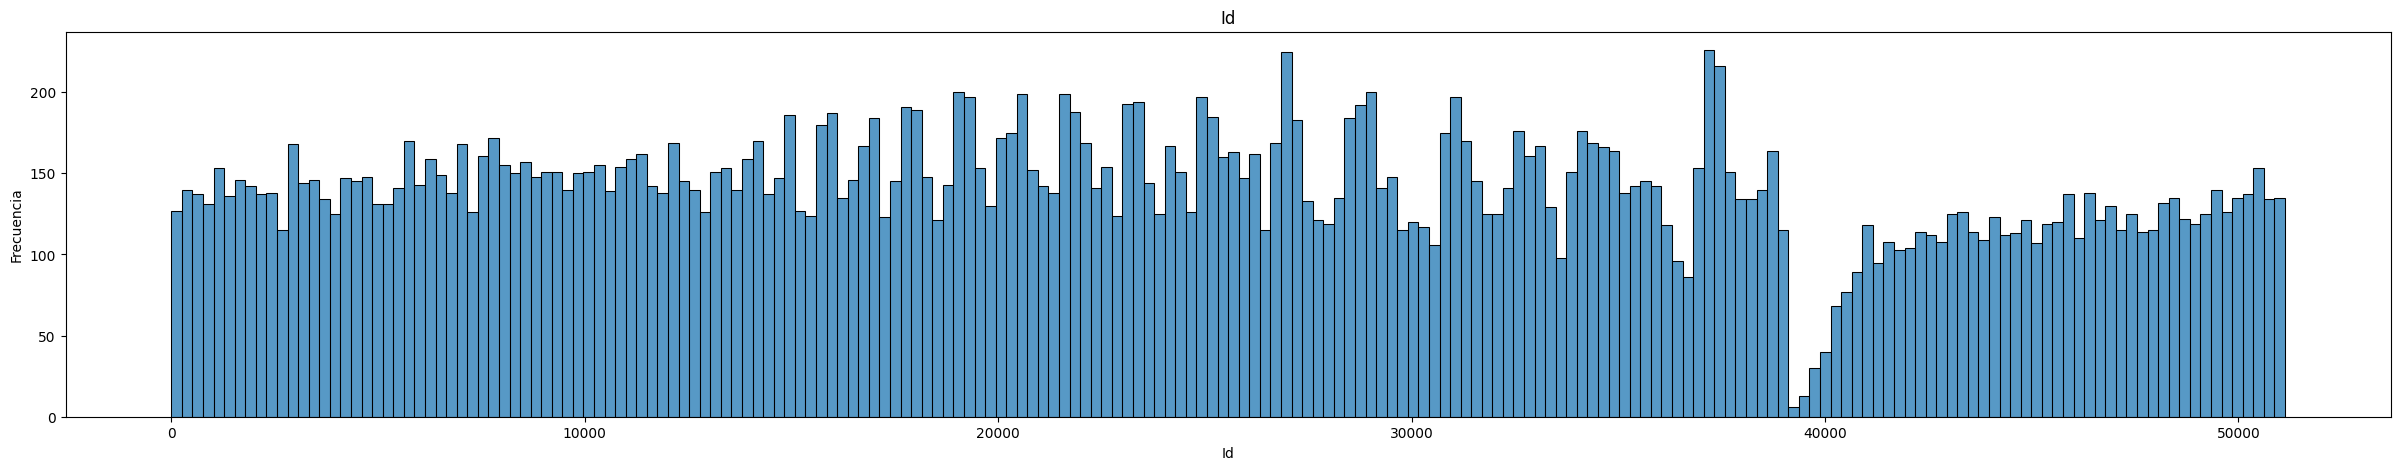

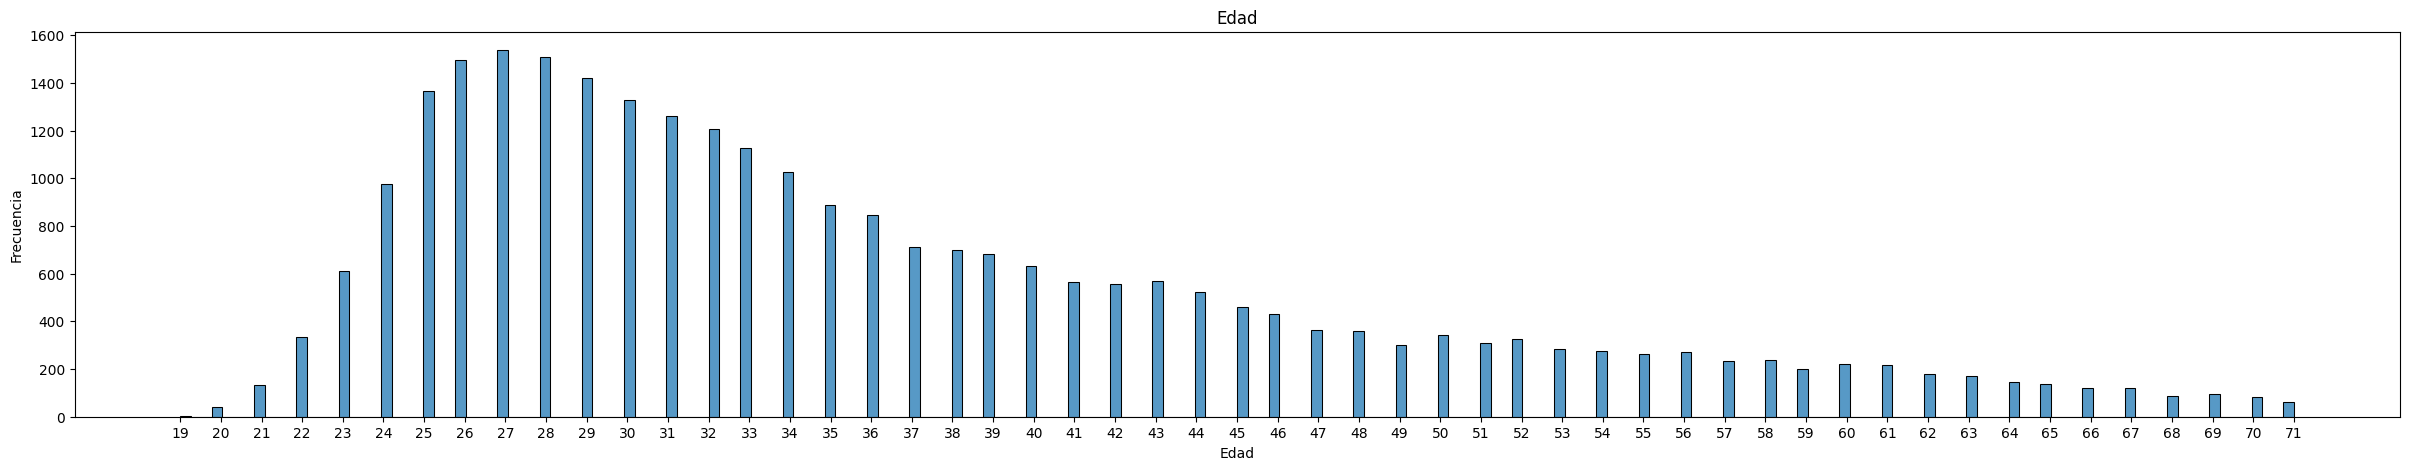

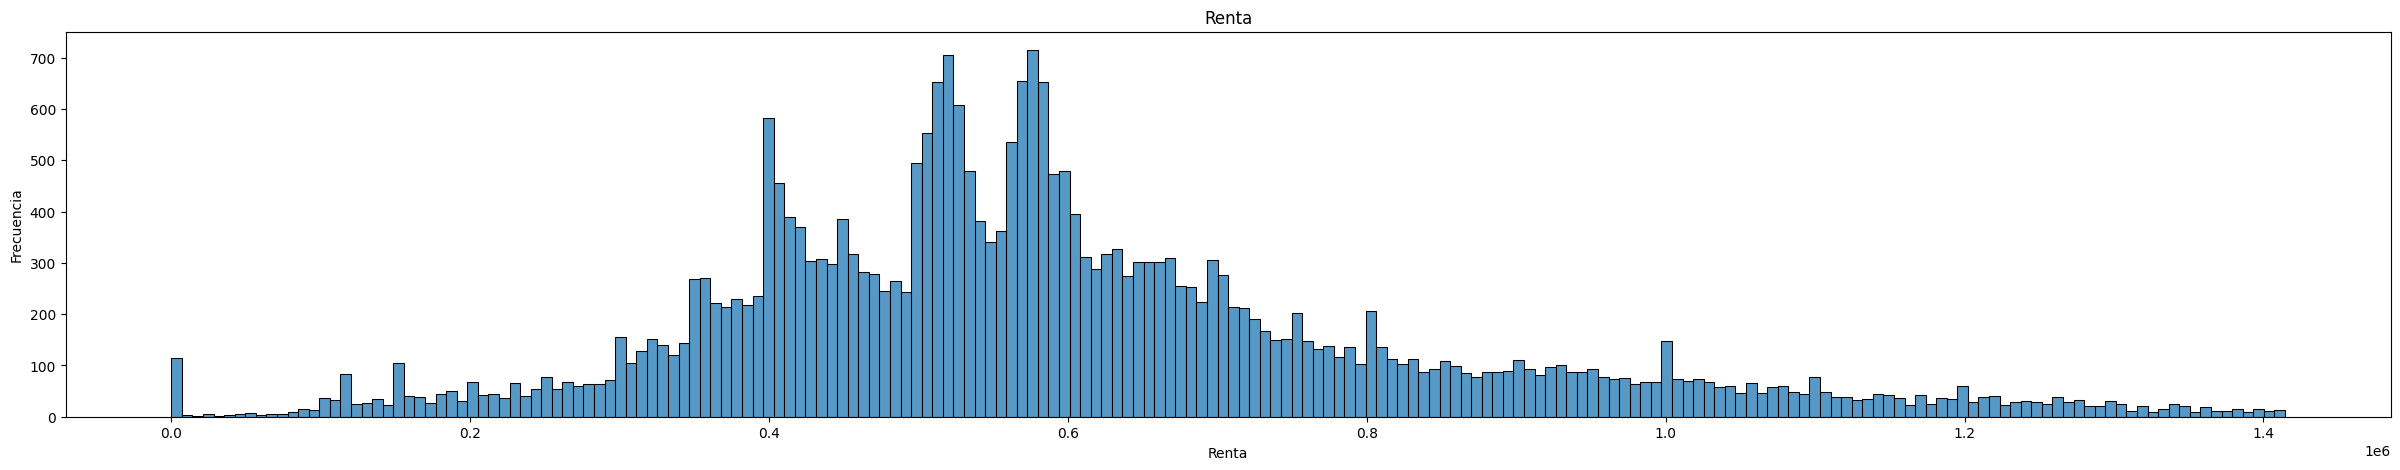

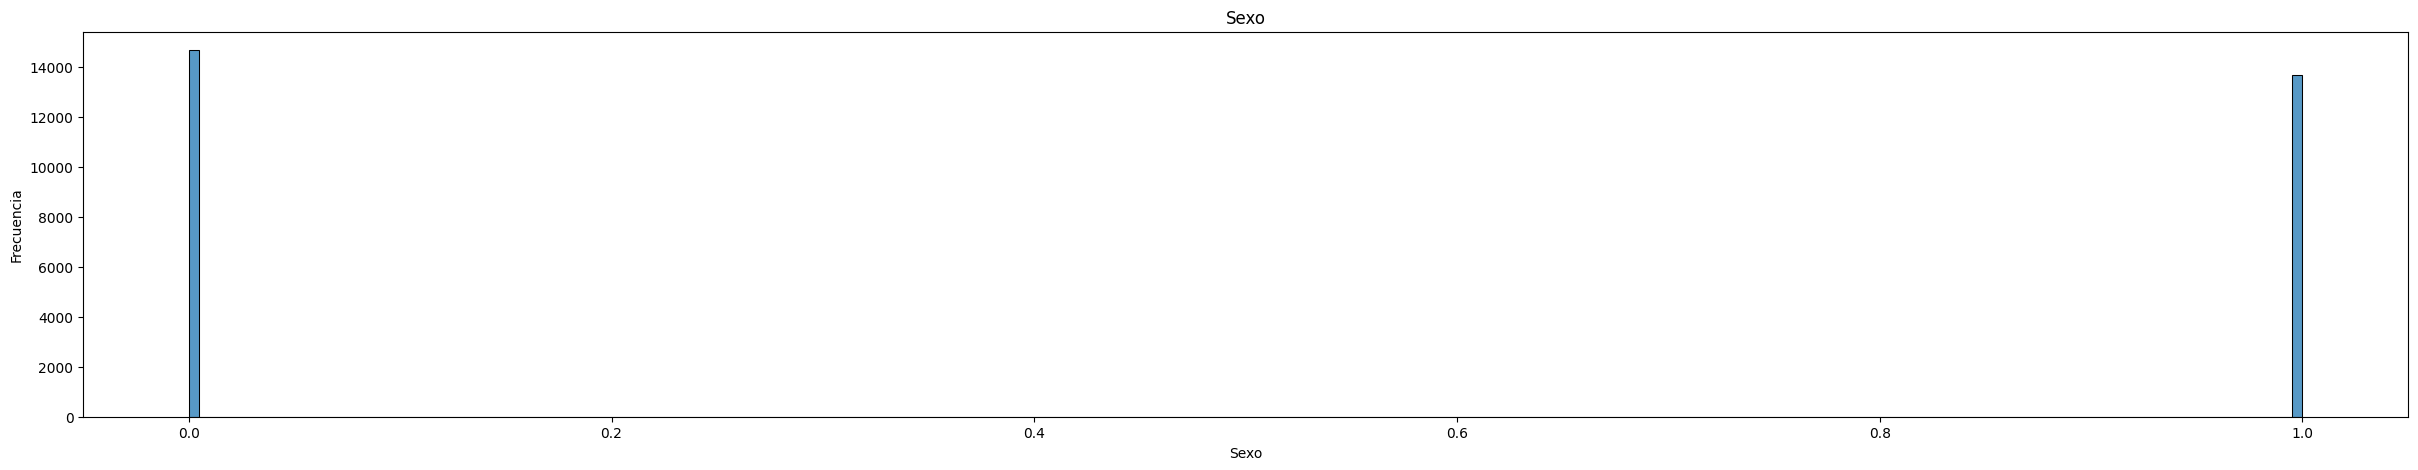

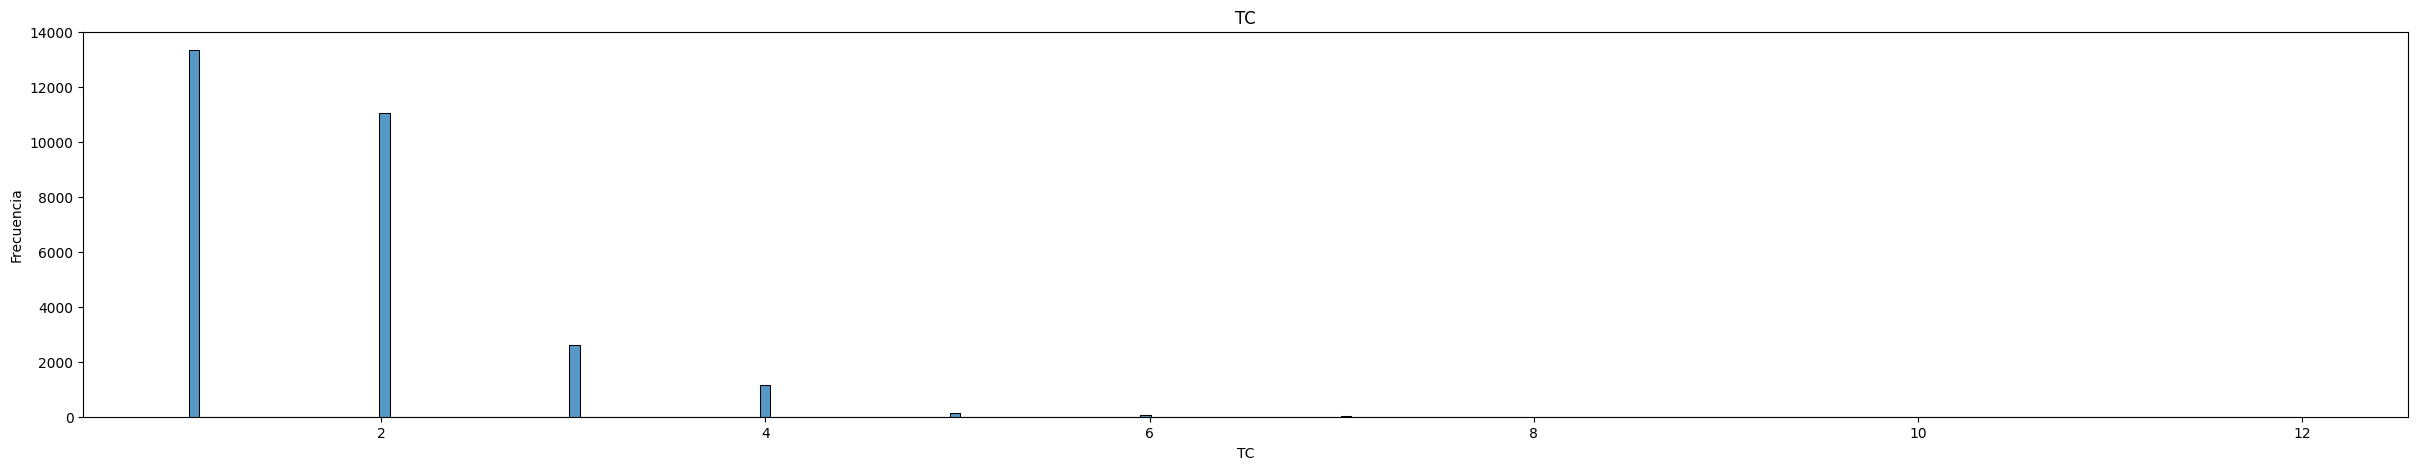

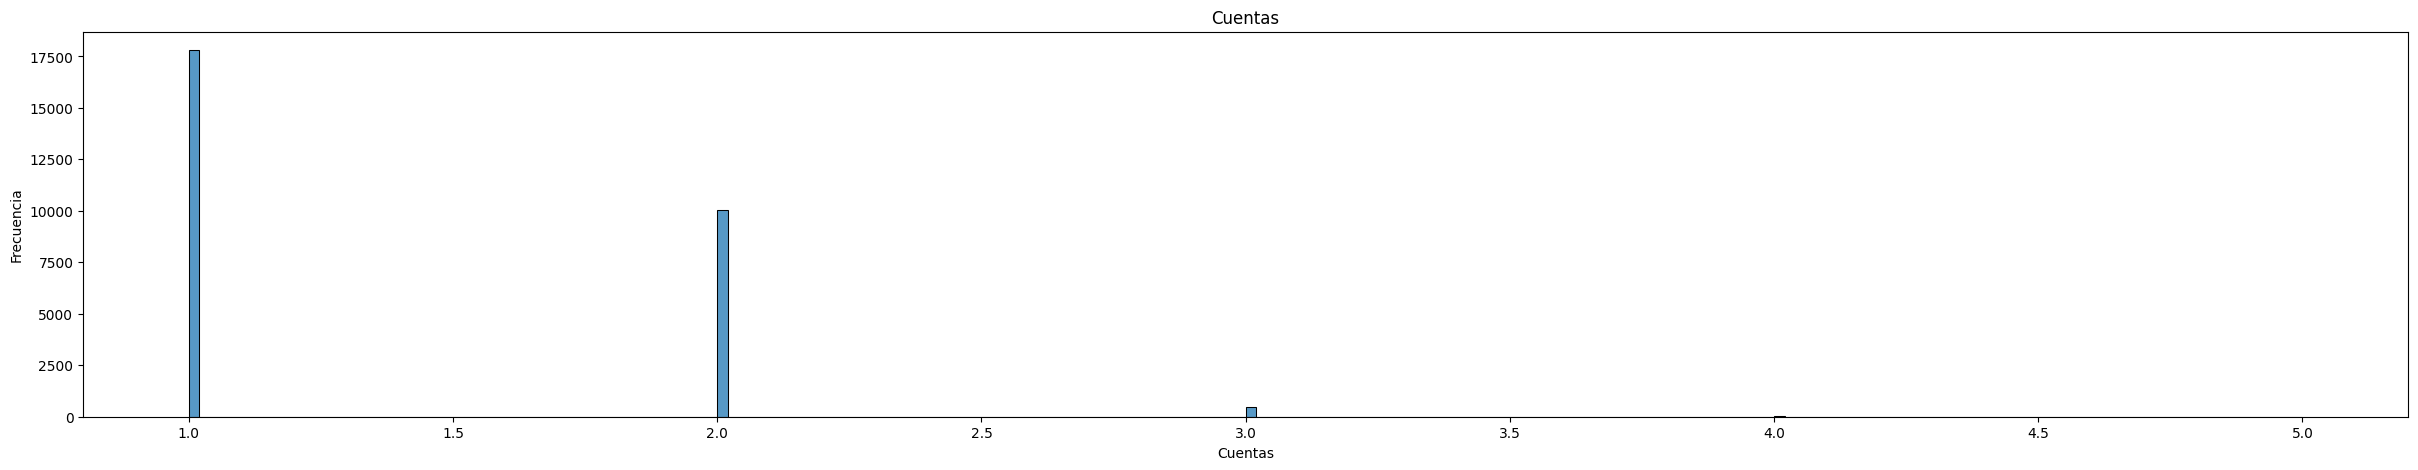

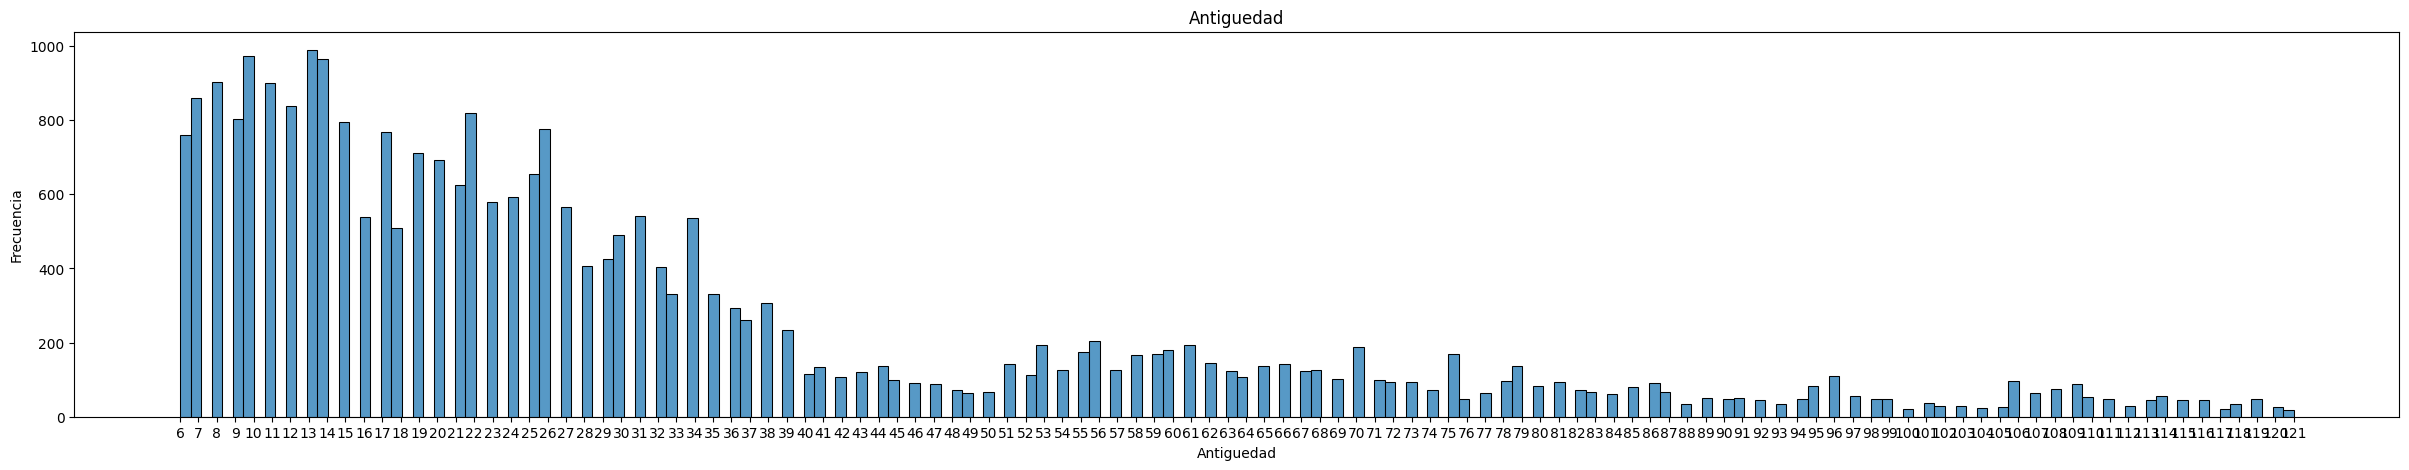

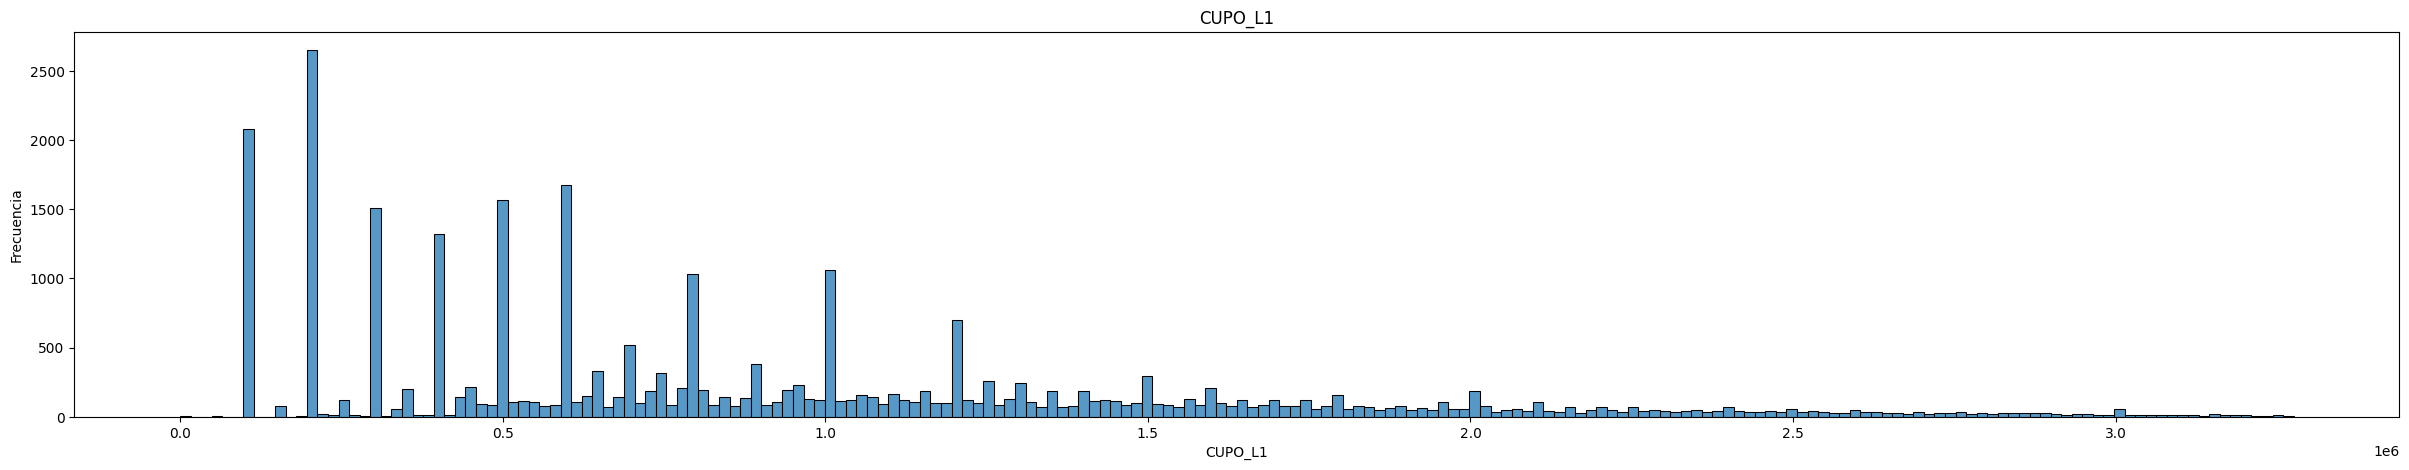

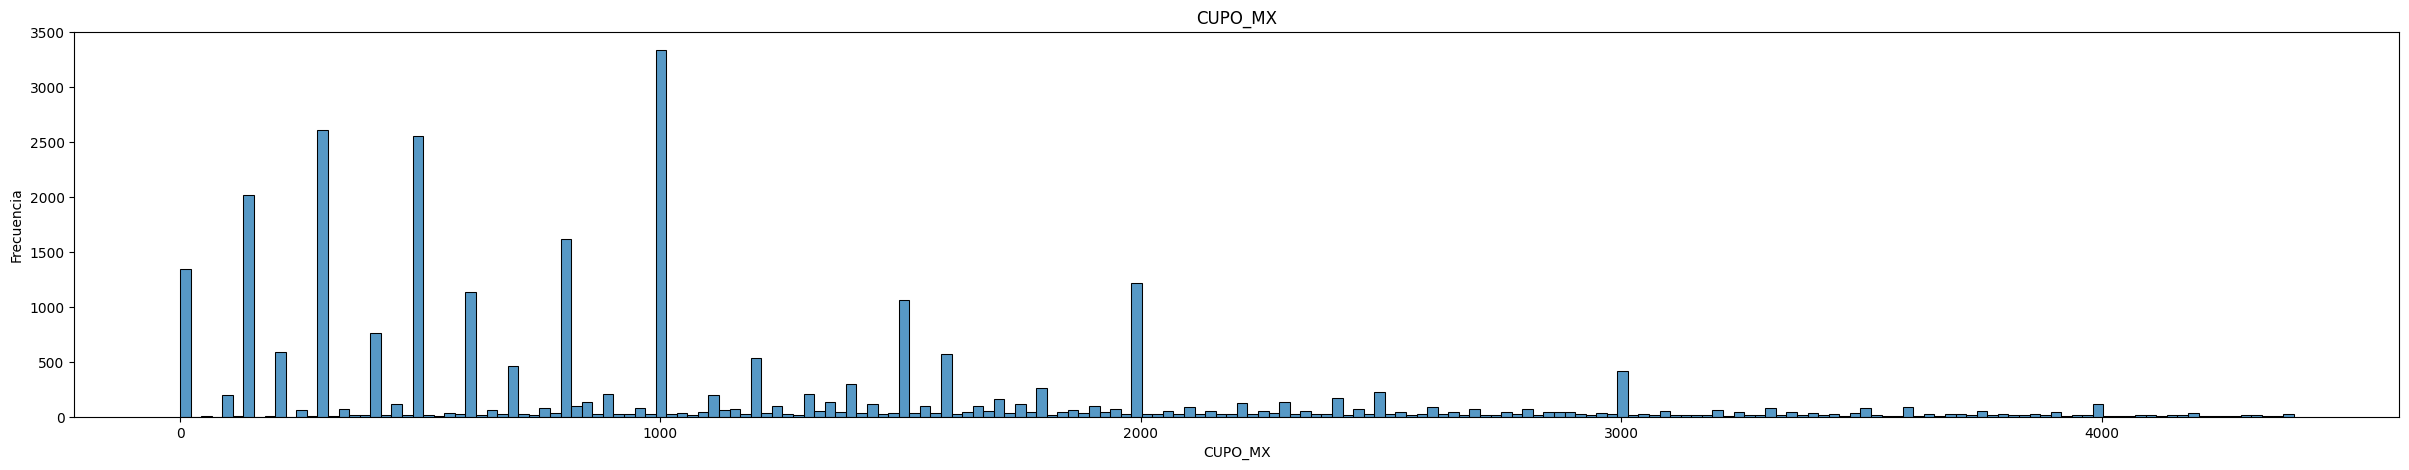

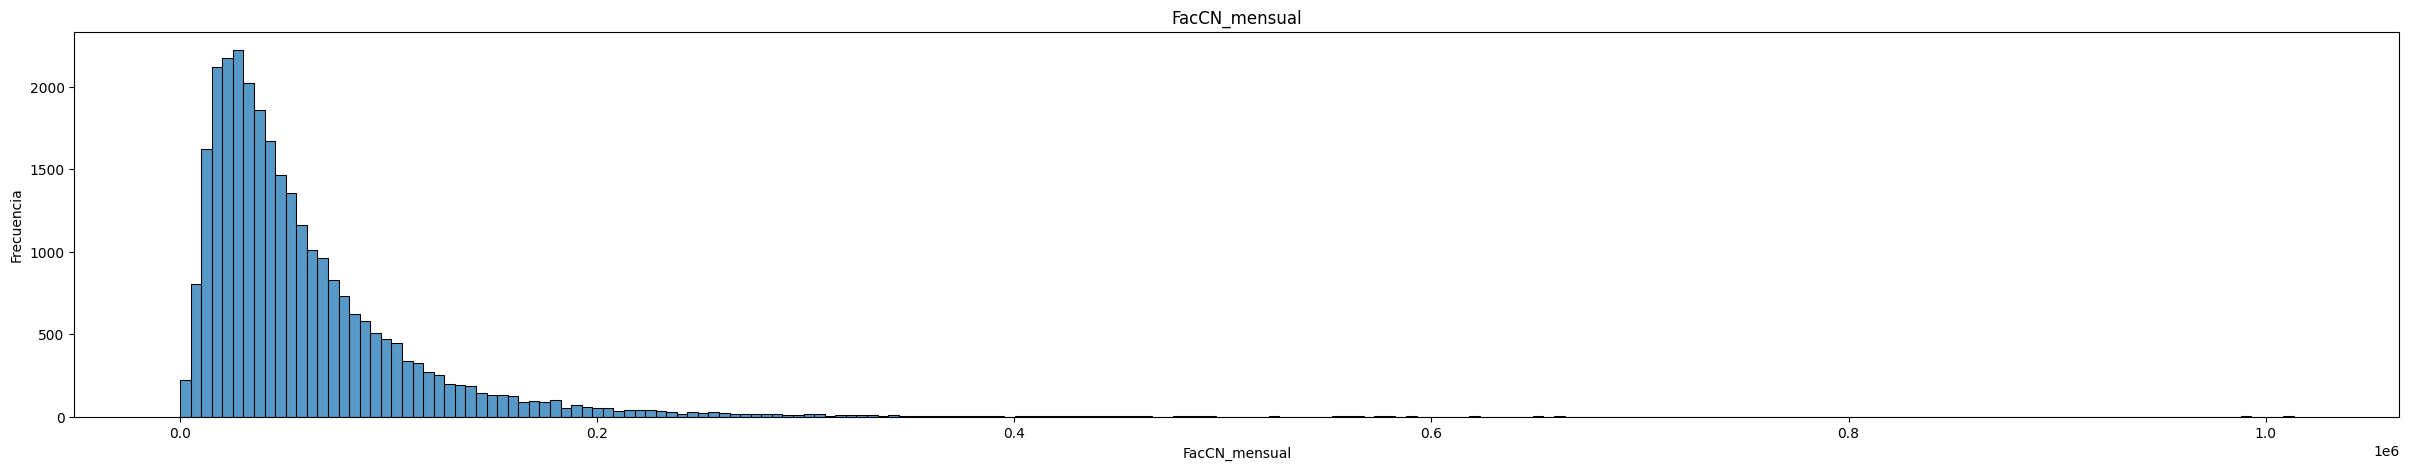

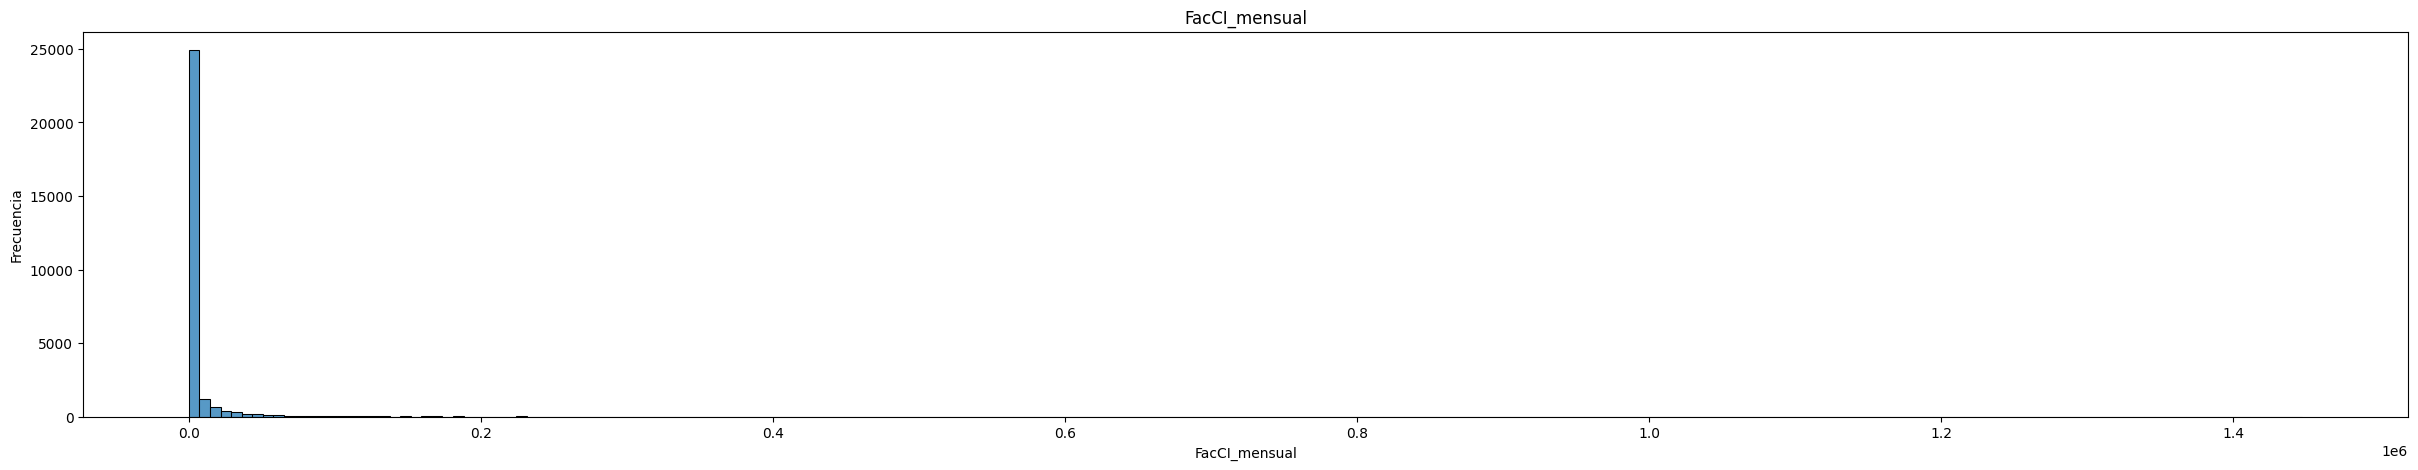

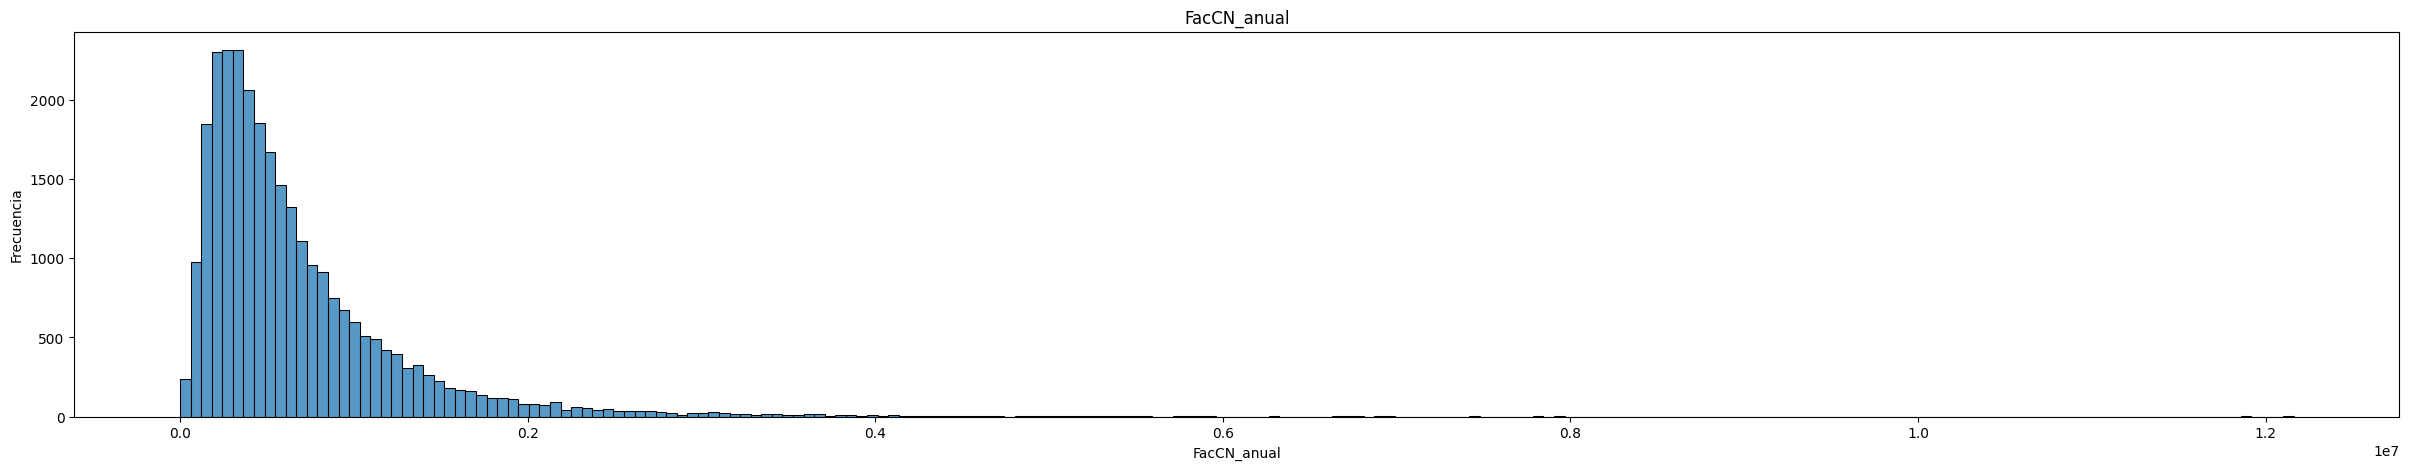

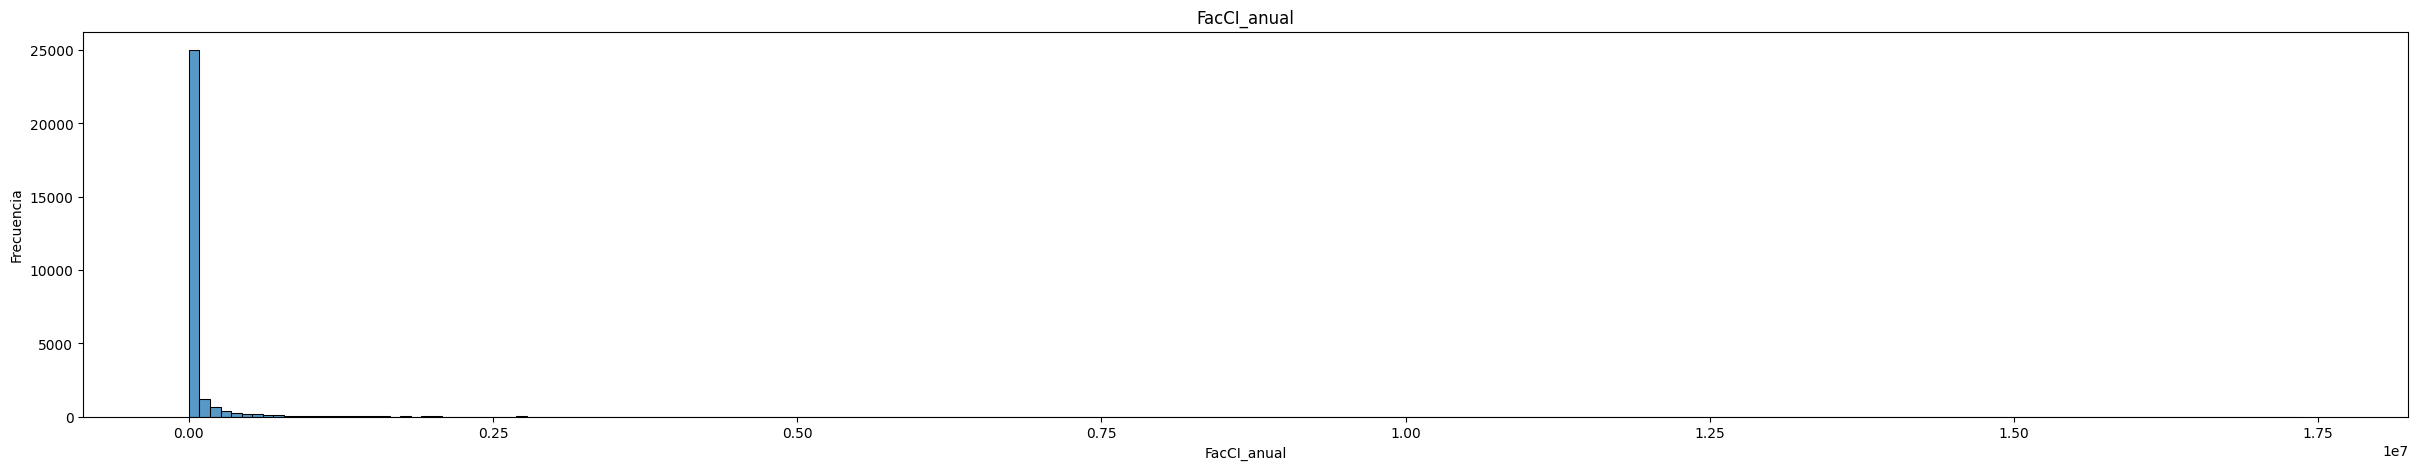

In [40]:
# Definimos las columnas que queremos analizar en detalle
columnas_para_filtrar = ['Edad', 'Region', 'Antiguedad']

# Iteramos sobre cada columna del DataFrame, excluyendo un gran conjunto de columnas
for columna in df_filtrado.drop(df_filtrado[['target']], axis=1):
    plt.figure(figsize=(30, 5))
    sb.histplot(df_filtrado[columna], bins=200)
    plt.title(columna)
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

    # Si la columna está en la lista de columnas a filtrar, ajustamos los límites de los ejes x
    if columna in columnas_para_filtrar:
        valor_max = df_filtrado[columna].max()
        valor_min = df_filtrado[columna].min()
        plt.xticks(np.arange(valor_min, valor_max + 1, step=1))
        plt.show()

## Seleccionaremos características, y convertiremos a enteros las que sean necesarias.

In [41]:
# Columnas faltantes para conversión
conversion_col_faltantes = ['Renta', 'Sexo', 'CUPO_L1', 'CUPO_MX']
# Aplicar la transformación a cada columna
for columna in conversion_col_faltantes:
    # Redondear y convertir a int64
    df_filtrado[columna] = np.round(df_filtrado[columna]).astype('int64')

C:\Users\herna\AppData\Local\Temp\ipykernel_21452\1185631893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado[columna] = np.round(df_filtrado[columna]).astype('int64')
C:\Users\herna\AppData\Local\Temp\ipykernel_21452\1185631893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado[columna] = np.round(df_filtrado[columna]).astype('int64')
C:\Users\herna\AppData\Local\Temp\ipykernel_21452\1185631893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [42]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28360 entries, 1 to 51123
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             28360 non-null  int64  
 1   Edad           28360 non-null  int64  
 2   Renta          28360 non-null  int64  
 3   Sexo           28360 non-null  int64  
 4   TC             28360 non-null  int64  
 5   Cuentas        28360 non-null  int64  
 6   Antiguedad     28360 non-null  int64  
 7   CUPO_L1        28360 non-null  int64  
 8   CUPO_MX        28360 non-null  int64  
 9   target         28360 non-null  int64  
 10  FacCN_mensual  28360 non-null  float64
 11  FacCI_mensual  28360 non-null  float64
 12  FacCN_anual    28360 non-null  float64
 13  FacCI_anual    28360 non-null  float64
dtypes: float64(4), int64(10)
memory usage: 3.2 MB


In [43]:
df_filtrado_v2 = df_filtrado.copy()

X = df_filtrado_v2.drop(columns=['Renta'])
y = df_filtrado_v2['Renta']

### Mostramos las características más relevantes para la predicción de la variable objetivo "y" en un conjunto de datos "X" utilizando una prueba estadística de regresión.

In [44]:
mejores_cat = SelectKBest(score_func=f_regression, k=12)
fit = mejores_cat.fit(X, y)

puntaje_df = pd.DataFrame(fit.scores_)
columnas_df = pd.DataFrame(X.columns)

puntajes_cat = pd.concat([columnas_df, puntaje_df], axis=1)
puntajes_cat.columns = ['Descripción', 'Resultado']

puntajes_cat.nlargest(12, 'Resultado')

,Descripción,Resultado
6,CUPO_L1,2419.529545
7,CUPO_MX,2018.089937
1,Edad,998.997383
11,FacCN_anual,640.557467
9,FacCN_mensual,596.048201
5,Antiguedad,565.134720
2,Sexo,406.195497
12,FacCI_anual,134.098556
10,FacCI_mensual,130.062537
3,TC,47.860297


### Obtenemos importancia de características.

In [45]:
modelo = ExtraTreesRegressor()
modelo.fit(X, y)

ExtraTreesRegressor()

In [46]:
print(modelo.feature_importances_)

[0.10438634 0.11179494 0.01599709 0.04895158 0.02676433 0.1204303
 0.15450366 0.12715844 0.02057062 0.09576325 0.0390508  0.09557032
 0.03905833]


Mostramos gráficamente.

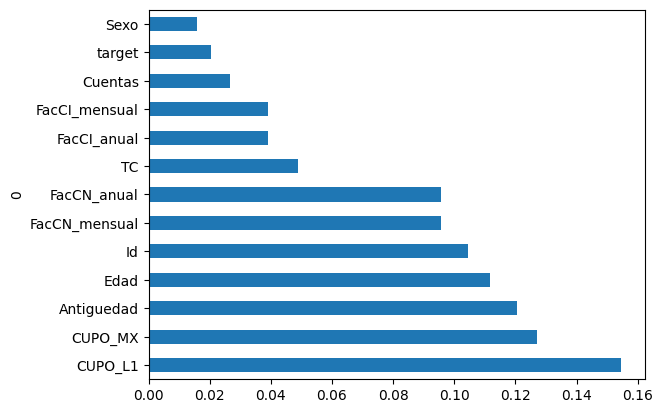

In [47]:
importancia_cat = pd.Series(modelo.feature_importances_, index=X.columns)
importancia_cat.nlargest(14).plot(kind='barh')
plt.show()

In [48]:
#df_normalizado.head(20)
df_filtrado_v2.head(25)
for i in df_filtrado_v2:
    print(f"{i} = {df_filtrado_v2[i].unique()} \n")

Id = [    2     3     6 ... 51121 51123 51124] 

Edad = [46 45 47 48 49 44 36 51 50 43 39 37 42 40 38 32 34 35 33 52 53 41 31 30
 55 29 54 59 69 56 62 60 27 63 28 26 64 25 61 57 67 65 24 22 58 23 71 21
 20 19 70 68 66] 

Renta = [143640 929106 707664 ... 625376 582536 840878] 

Sexo = [0 1] 

TC = [ 1  2  3  4  5  6  8  7 12] 

Cuentas = [1 2 3 4 5] 

Antiguedad = [ 69  24  67  21  33  23  80  13   7  22  18  49  14 109  72 105  27  78
  60  38  10  28  26  75  70  48  74  15  30  36   8  87  35  16  47  20
  61  39   9  84  73  92  50  19  65  25  99  96  94  83  59  32   6  68
  93  82 107  79  31  63  56  11  81  58  57  45 108  37  52  97  54  41
  66  34  29  44  43 110 120  85  98  12  51  42  53 101  17  77  95  88
 100  86 112  55  64 106 121 118 119  90  40  62 117  46 116  89 104 102
 113  91  71 115 114 111  76 103] 

CUPO_L1 = [ 750000 1350000 1312500 ... 2278125 2524600 2735424] 

CUPO_MX = [1000 1500  714 ...  819 3082 2558] 

target = [0 1] 

FacCN_mensual = [ 81007. 140

Procederemos a tomar la variable contínua Edad, creando una nueva variable de tipo categórica ('Rango_Edad) con nuevas 'Features'.

In [49]:
bins = [18, 30, 60, 100]
labels = ['Joven' , 'Adulto', 'Adulto Mayor']

df_filtrado_v2['Rango_Edad'] = pd.cut(df_filtrado_v2['Edad'], bins=bins, labels=labels)

orden_rangos = {'Joven': 0, 'Adulto': 1, 'Adulto Mayor': 2}

df_filtrado_v2['Rango_Edad'] = df_filtrado_v2['Rango_Edad'].map(orden_rangos)

df_filtrado_v2[['Edad', 'Rango_Edad']].head()

,Edad,Rango_Edad
1,46,1
2,45,1
5,47,1
6,48,1
7,46,1


In [50]:
def contar_rangos_edad(df_filtrado_v2 ):
    columna = 'Rango_Edad'
    if columna in df_filtrado_v2 .columns:
        conteos = df_filtrado_v2 [columna].value_counts()
        rangos_edad = [0, 1, 2]
        conteos_rangos = {rango: conteos.get(rango, 0) for rango in rangos_edad}
        return conteos_rangos
    else:
        raise ValueError(f"La columna '{columna}' no se encuentra en el DataFrame")

conteos_rangos_edad = contar_rangos_edad(df_filtrado_v2)
print(conteos_rangos_edad)

df_filtrado_v2.tail(50)

{0: 10759, 1: 16182, 2: 1419}


,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual,Rango_Edad
51034,51035,47,831047,1,1,1,26,400000,450,1,29107.0,0.0,349281.0,0.0,1
51036,51037,51,424733,1,2,1,44,1787500,1600,0,34885.0,0.0,418618.0,0.0,1
51041,51042,45,591648,0,1,1,63,1250000,3000,0,23942.0,0.0,287306.0,0.0,1
51042,51043,47,669099,0,1,1,54,800000,1000,0,81207.0,5165.0,974489.0,61978.0,1
51043,51044,47,739875,0,1,1,22,500000,1000,1,29407.0,0.0,352880.0,0.0,1
51045,51046,48,898717,1,3,2,83,2441500,1200,0,97116.0,0.0,1165397.0,0.0,1
51047,51048,50,859156,1,1,1,37,800000,1000,0,85463.0,0.0,1025558.0,0.0,1
51051,51052,50,657314,0,4,2,7,1000000,1400,0,193123.0,0.0,1351862.0,0.0,1
51053,51054,49,1184411,0,1,1,14,1000000,1500,0,47974.0,439.0,575688.0,5271.0,1
51055,51056,44,1018423,0,3,2,81,1000000,1000,0,41442.0,0.0,497304.0,0.0,1


In [51]:
df_filtrado_v2.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
df_filtrado_v2

,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual,Rango_Edad
1,2,46,143640,0,1,1,69,750000,1000,0,81007.0,31912.0,972082.0,382939.0,1
2,3,45,929106,0,2,1,24,1350000,1500,0,140434.0,8548.0,1685212.0,102577.0,1
5,6,47,707664,0,2,1,67,1312500,714,0,60771.0,0.0,729254.0,0.0,1
6,7,48,1022833,0,2,2,21,813000,600,0,142519.0,0.0,1710229.0,0.0,1
7,8,46,689673,0,3,2,69,1242000,1255,0,39668.0,0.0,476012.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51118,51119,44,414316,1,2,2,23,1020000,1600,0,22054.0,0.0,264654.0,0.0,1
51119,51120,51,364978,0,3,2,57,999000,550,0,68908.0,0.0,826895.0,0.0,1
51120,51121,51,625376,0,1,1,39,1744200,300,0,115407.0,0.0,1384888.0,0.0,1
51122,51123,47,582536,1,1,1,11,1612000,2300,0,40278.0,0.0,402782.0,0.0,1


In [52]:
df_filtrado_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28360 entries, 1 to 51123
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             28360 non-null  int64   
 1   Edad           28360 non-null  int64   
 2   Renta          28360 non-null  int64   
 3   Sexo           28360 non-null  int64   
 4   TC             28360 non-null  int64   
 5   Cuentas        28360 non-null  int64   
 6   Antiguedad     28360 non-null  int64   
 7   CUPO_L1        28360 non-null  int64   
 8   CUPO_MX        28360 non-null  int64   
 9   target         28360 non-null  int64   
 10  FacCN_mensual  28360 non-null  float64 
 11  FacCI_mensual  28360 non-null  float64 
 12  FacCN_anual    28360 non-null  float64 
 13  FacCI_anual    28360 non-null  float64 
 14  Rango_Edad     28360 non-null  category
dtypes: category(1), float64(4), int64(10)
memory usage: 3.3 MB


Pasamos la variable 'CUPO_MX', donde sus valores están reflejados en dólares estadounidenses, a pesos chilenos.

In [53]:
valor_cambio = 816.36
cupo_mean = df_filtrado_v2['CUPO_MX'] * valor_cambio

df_filtrado_v2['CUPO_MX_CLP'] = cupo_mean.round(0).astype('int64')

df_filtrado_v2.head(100)

,Id,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,target,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual,Rango_Edad,CUPO_MX_CLP
1,2,46,143640,0,1,1,69,750000,1000,0,81007.0,31912.0,972082.0,382939.0,1,816360
2,3,45,929106,0,2,1,24,1350000,1500,0,140434.0,8548.0,1685212.0,102577.0,1,1224540
5,6,47,707664,0,2,1,67,1312500,714,0,60771.0,0.0,729254.0,0.0,1,582881
6,7,48,1022833,0,2,2,21,813000,600,0,142519.0,0.0,1710229.0,0.0,1,489816
7,8,46,689673,0,3,2,69,1242000,1255,0,39668.0,0.0,476012.0,0.0,1,1024532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,178,46,835252,1,3,2,20,500000,1000,0,47894.0,1296.0,574734.0,15548.0,1,816360
179,180,49,999997,0,1,1,26,500000,800,0,122690.0,0.0,1472282.0,0.0,1,653088
181,182,46,749997,1,1,1,26,500000,800,0,42390.0,12360.0,296732.0,86522.0,1,653088
182,183,48,490340,1,4,3,68,2458000,1580,1,6830.0,0.0,81955.0,0.0,1,1289849


In [54]:
df_filtrado_v2 = df_filtrado_v2.drop(columns=['target', 'Id'])
df_filtrado_v2

,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual,Rango_Edad,CUPO_MX_CLP
1,46,143640,0,1,1,69,750000,1000,81007.0,31912.0,972082.0,382939.0,1,816360
2,45,929106,0,2,1,24,1350000,1500,140434.0,8548.0,1685212.0,102577.0,1,1224540
5,47,707664,0,2,1,67,1312500,714,60771.0,0.0,729254.0,0.0,1,582881
6,48,1022833,0,2,2,21,813000,600,142519.0,0.0,1710229.0,0.0,1,489816
7,46,689673,0,3,2,69,1242000,1255,39668.0,0.0,476012.0,0.0,1,1024532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51118,44,414316,1,2,2,23,1020000,1600,22054.0,0.0,264654.0,0.0,1,1306176
51119,51,364978,0,3,2,57,999000,550,68908.0,0.0,826895.0,0.0,1,448998
51120,51,625376,0,1,1,39,1744200,300,115407.0,0.0,1384888.0,0.0,1,244908
51122,47,582536,1,1,1,11,1612000,2300,40278.0,0.0,402782.0,0.0,1,1877628


In [55]:
df_filtrado_v2['FacCN_anual'] = df_filtrado_v2['FacCN_anual'].astype('int64')
df_filtrado_v2['FacCN_mensual'] = df_filtrado_v2['FacCN_mensual'].astype('int64')
df_filtrado_v2['FacCI_anual'] = df_filtrado_v2['FacCI_anual'].astype('int64')
df_filtrado_v2['FacCI_mensual'] = df_filtrado_v2['FacCI_mensual'].astype('int64')
df_filtrado_v2['Rango_Edad'] = df_filtrado_v2['Rango_Edad'].astype('int64')
df_filtrado_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28360 entries, 1 to 51123
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Edad           28360 non-null  int64
 1   Renta          28360 non-null  int64
 2   Sexo           28360 non-null  int64
 3   TC             28360 non-null  int64
 4   Cuentas        28360 non-null  int64
 5   Antiguedad     28360 non-null  int64
 6   CUPO_L1        28360 non-null  int64
 7   CUPO_MX        28360 non-null  int64
 8   FacCN_mensual  28360 non-null  int64
 9   FacCI_mensual  28360 non-null  int64
 10  FacCN_anual    28360 non-null  int64
 11  FacCI_anual    28360 non-null  int64
 12  Rango_Edad     28360 non-null  int64
 13  CUPO_MX_CLP    28360 non-null  int64
dtypes: int64(14)
memory usage: 3.2 MB


In [56]:
# Filtrar columnas cuyo nombre comienza con 'FacC'
fac_columns = [col for col in df_filtrado_v2.columns if col.startswith('FacC')]

# Crear una copia del dataframe original para evitar modificarlo directamente
df_limpio_nuevo = df_filtrado_v2.copy()

# Eliminar outliers utilizando el rango intercuartílico (IQR)
for col in fac_columns:
    Q1 = df_limpio_nuevo[col].quantile(0.25)  # Primer cuartil
    Q3 = df_limpio_nuevo[col].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartílico
    lower_bound = Q1 - 1.5 * IQR  # Límite inferior
    upper_bound = Q3 + 1.5 * IQR  # Límite superior
    
    # Filtrar valores dentro de los límites
    df_limpio_nuevo = df_limpio_nuevo[(df_limpio_nuevo[col] >= lower_bound) & (df_limpio_nuevo[col] <= upper_bound)]

# Mostrar la forma del nuevo dataframe sin outliers
print(f"Dataframe original: {df_filtrado_v2.shape}")
print(f"Dataframe sin outliers: {df_limpio_nuevo.shape}")

Dataframe original: (28360, 14)
Dataframe sin outliers: (20123, 14)


### Normalizaremos el dataset.

In [57]:
# Copia del DataFrame original
df_normalizado = df_limpio_nuevo.copy()

# Separar las columnas que van a usarse con un Escalador/Estandarizador
col_minmax = ['Edad', 'Renta', 'Antiguedad', 'CUPO_L1', 'CUPO_MX', 'FacCN_mensual', 'FacCI_mensual', 'FacCN_anual', 'FacCI_anual', 'CUPO_MX_CLP']

# Inicializar los escaladores
#scaler_standard = MinMaxScalerScaler()
scaler_minmax = MinMaxScaler()

# Aplicar StandardScaler
#df_normalizado[col_standard] = scaler_standard.fit_transform(df_normalizado[col_standard])

# Aplicar MinMaxScaler
df_normalizado[col_minmax] = scaler_minmax.fit_transform(df_normalizado[col_minmax])
df_normalizado.head()

,Edad,Renta,Sexo,TC,Cuentas,Antiguedad,CUPO_L1,CUPO_MX,FacCN_mensual,FacCI_mensual,FacCN_anual,FacCI_anual,Rango_Edad,CUPO_MX_CLP
5,0.538462,0.500686,0,2,1,0.530435,0.400641,0.162273,0.409762,0.0,0.494390,0.0,1,0.162273
7,0.519231,0.487957,0,3,2,0.547826,0.379121,0.285227,0.267470,0.0,0.322707,0.0,1,0.285227
9,0.480769,0.682323,1,3,1,0.147826,0.205128,0.227273,0.320765,0.0,0.387013,0.0,1,0.227273
12,0.326923,0.893766,0,1,1,0.643478,0.152625,0.340909,0.235975,0.0,0.166081,0.0,1,0.340909
14,0.557692,0.419234,0,1,1,0.060870,0.122100,0.227273,0.362408,0.0,0.437250,0.0,1,0.227273


### Definición de variables objetivo.

In [58]:
# Regresión
Xr = df_normalizado.drop(['FacCN_mensual'], axis=1)
yr = df_normalizado['FacCN_mensual']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(Xr, yr, test_size=0.2)

# Clasificación
Xc = df_normalizado.drop(['Sexo'], axis=1)
yc = df_normalizado['Sexo']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(Xc, yc, test_size=0.2)

# Modeling

##Primero, utilizaremos algoritmos para modelado de datos numéricos.

Regresión Lineal

In [59]:
from sklearn.linear_model import LinearRegression
LiR = LinearRegression()
LiR.fit(X_train_r, y_train_r)

LiR_pred = LiR.predict(X_test_r)

Decision tree

In [60]:
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor()
DTR.fit(X_train_r, y_train_r)

DTR_pred = DTR.predict(X_test_r)

Support Vector Machine

In [61]:
from sklearn import svm
SVMSVR = svm.SVR()
SVMSVR.fit(X_train_r, y_train_r)

SVMSVR_pred = SVMSVR.predict(X_test_r)

Random Forest Regressor

In [62]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()
RFR.fit(X_train_r, y_train_r)

RFR_pred = RFR.predict(X_test_r)

Implementamos la búsqueda de hiperparámetros utilizando GridSearchCV a los modelos más prometedores de regresión, con el fin de maximizar el desempeño.

In [63]:
# Decision Tree Regressor
param_grid_dtr = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dtr = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=param_grid_dtr,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_dtr.fit(X_train_r, y_train_r)

# Random Forest Regressor
param_grid_rfr = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rfr = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid_rfr,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_rfr.fit(X_train_r, y_train_r)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error', verbose=1)

Con los hiperparámetros y el mejor estimador encontrados, procedemos a evaluar nuevamente el desempeño del modelo ajustado.

In [64]:
y_pred_r = grid_rfr.best_estimator_.predict(X_test_r)

##Ahora, realizaremos el modelado de datos de clasificación.

Gaussian Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train_c, y_train_c)

GNB_pred = GNB.predict(X_test_c)

Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=4)
RF.fit(X_train_c, y_train_c)

RF_pred = RF.predict(X_test_c)

Regresión Logística

In [67]:
from sklearn.linear_model import LogisticRegression
LoR = LogisticRegression()
LoR.fit(X_train_c, y_train_c)

LoR_pred = LoR.predict(X_test_c)

Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
DTC.fit(X_train_c, y_train_c)

DTC_pred = DTC.predict(X_test_c)

Support Vector Machine Classifier

In [116]:
from sklearn import svm
SVMSVC = svm.SVC(probability=True)
SVMSVC.fit(X_train_c, y_train_c)

SVMSVC_pred = SVMSVC.predict(X_test_c)

Aplicamos GridSearchCV para identificar los mejores hiperparámetros para los modelos de clasificación con mejor desempeño.

In [117]:
# Random Forest Classifier
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_rf.fit(X_train_c, y_train_c)

# Support Vector Machine Classifier
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid_svc = GridSearchCV(
    estimator=svm.SVC(probability=True),
    param_grid=param_grid_svc,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_svc.fit(X_train_c, y_train_c)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=1)

Evaluamos, con los hiperparámetros y el estimador obtenidos de GridSearchCV, el modelo ajustado.

In [91]:
#y_pred_c = grid_svc.best_estimator_.predict(X_test_c)
y_pred_c = grid_rf.best_estimator_.predict(X_test_c)

Utilizamos un último modelo para clasificación, XGBoost Classifier, incluyendo GridSearchCV.

In [96]:
# Definir hiperparámetros para GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'max_depth': [3, 5, 7],  # Profundidad máxima del árbol
    'subsample': [0.8, 1.0],  # Submuestreo de los datos de entrenamiento
    'colsample_bytree': [0.8, 1.0],  # Submuestreo de características
    'gamma': [0, 1, 5]  # Regularización de reducción
}

# Inicializar el modelo
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Realizar la búsqueda con GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='accuracy',  # Métrica de evaluación
    cv=5,  # Número de pliegues de validación cruzada
    verbose=1,
    n_jobs=-1
)

# Entrenar el modelo con el conjunto de entrenamiento
grid_xgb.fit(X_train_c, y_train_c)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\herna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [18:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

# Evaluation

## Modelos de Regresión

Regresión Lineal

In [73]:
print(f"Error Absoluto Medio:  \t\t{mean_absolute_error(y_test_r, LiR_pred)}  ")
print(f"Error Cuadratico Medio: \t{mean_squared_error(y_test_r, LiR_pred)}   ")
# mean_squared_log_error(y_test_r, LiR_pred)
print(f"R2 Score:    \t\t\t{r2_score(y_test_r, LiR_pred)}   ")

Error Absoluto Medio:  		0.029198649509141694  
Error Cuadratico Medio: 	0.002408353587122521   
R2 Score:    			0.9370569341533436   


Decision Tree Regressor

In [74]:
print(f"Error Absoluto Medio: \t\t\t{mean_absolute_error(y_test_r, DTR_pred)}")
print(f"Error Cuadratico Medio: \t\t{mean_squared_error(y_test_r, DTR_pred)}")
print(f"Logaritmo del Error Cuadrado Medio: \t{mean_squared_log_error(y_test_r, DTR_pred)}")
print(f"R2 Score:  \t\t\t\t{r2_score(y_test_r, DTR_pred)}")

Error Absoluto Medio: 			0.006450582864567392
Error Cuadratico Medio: 		0.0004836323440265985
Logaritmo del Error Cuadrado Medio: 	0.0002295231224353414
R2 Score:  				0.9873601191127379


Support Vector Machine Regressor

In [75]:
print(f"Error Absoluto Medio: \t\t{mean_absolute_error(y_test_r, SVMSVR_pred)}")
print(f"Error Cuadratico Medio:  \t{mean_squared_error(y_test_r, SVMSVR_pred)}")
# print(mean_squared_log_error(y_test_r, SVMSVR_pred))
print(f"R2 Score: \t\t\t{r2_score(y_test_r, SVMSVR_pred)}")

Error Absoluto Medio: 		0.05647656918846123
Error Cuadratico Medio:  	0.004323885936523211
R2 Score: 			0.8869939037725831


Random Forest Regressor

In [76]:
print(f"Error Absoluto Medio: \t\t{mean_absolute_error(y_test_r, RFR_pred)}")
print(f"Error Cuadratico Medio:  \t{mean_squared_error(y_test_r, RFR_pred)}")
# print(mean_squared_log_error(y_test_r, RFR_pred))
print(f"R2 Score: \t\t\t{r2_score(y_test_r, RFR_pred)}")

Error Absoluto Medio: 		0.006080549727217005
Error Cuadratico Medio:  	0.00029771027344357564
R2 Score: 			0.9922192499287557


Se muestran los mejores hiperparámetros obtenidos con GridSearchCV para Decision Tree Regressor.

In [77]:
print("Mejores parámetros para Decision Tree Regressor:")
print(grid_dtr.best_params_)
print("Mejor puntuación (neg_mean_squared_error):")
print(grid_dtr.best_score_)

Mejores parámetros para Decision Tree Regressor:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mejor puntuación (neg_mean_squared_error):
-0.0003671470075840997


Y para Random Forest Regressor.

In [78]:
print("Mejores parámetros para Random Forest Regressor:")
print(grid_rfr.best_params_)
print("Mejor puntuación (neg_mean_squared_error):")
print(grid_rfr.best_score_)

Mejores parámetros para Random Forest Regressor:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mejor puntuación (neg_mean_squared_error):
-0.00028657761006794515


Se muestran los resultados del modelo de regresión (Random Forest Regressor) ajustado.

In [79]:
print("MAE:", mean_absolute_error(y_test_r, y_pred_r))
print("MSE:", mean_squared_error(y_test_r, y_pred_r))
print("R²:", r2_score(y_test_r, y_pred_r))

MAE: 0.006290811928867838
MSE: 0.0002729237830160094
R²: 0.9928670525219595


## Modelos de Clasificación

Gaussian Naive Bayes

In [80]:
print(f"Accuracy Score: {accuracy_score(y_test_c, GNB_pred)}")
print(f"Classification Report:\n{classification_report(y_test_c, GNB_pred)}")
print(f"Matriz de Confusión: \n{confusion_matrix(y_test_c, GNB_pred)}")

Accuracy Score: 0.5391304347826087
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52      2093
           1       0.52      0.60      0.56      1932

    accuracy                           0.54      4025
   macro avg       0.54      0.54      0.54      4025
weighted avg       0.54      0.54      0.54      4025

Matriz de Confusión: 
[[1008 1085]
 [ 770 1162]]


Random Forest Classifier

In [81]:
print(f"Accuracy Score: {accuracy_score(y_test_c, RF_pred)}")
print(f"Classification Report: \n{classification_report(y_test_c, RF_pred)}")
print(f"Matriz de Confusión: \n {confusion_matrix(y_test_c, RF_pred)} \n\n")

Accuracy Score: 0.6154037267080745
Classification Report: 
              precision    recall  f1-score   support

           0       0.61      0.74      0.67      2093
           1       0.63      0.48      0.54      1932

    accuracy                           0.62      4025
   macro avg       0.62      0.61      0.61      4025
weighted avg       0.62      0.62      0.61      4025

Matriz de Confusión: 
 [[1559  534]
 [1014  918]] 




Regresión Logística

In [82]:
print(f"Accuracy Score: {accuracy_score(y_test_c, LoR_pred)}")
print(f"Classification Report: \n{classification_report(y_test_c, LoR_pred)}")
print(f"Matriz de Confusión: \n{confusion_matrix(y_test_c, LoR_pred)}")

Accuracy Score: 0.5731677018633541
Classification Report: 
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      2093
           1       0.56      0.55      0.55      1932

    accuracy                           0.57      4025
   macro avg       0.57      0.57      0.57      4025
weighted avg       0.57      0.57      0.57      4025

Matriz de Confusión: 
[[1238  855]
 [ 863 1069]]


Decision Tree Classifier

In [83]:
print(f"Accuracy Score: {accuracy_score(y_test_c, DTC_pred)}")
print(f"Classification Report: \n{classification_report(y_test_c, DTC_pred)}")
print(f"Matriz de Confusión: \n{confusion_matrix(y_test_c, DTC_pred)}")

Accuracy Score: 0.586583850931677
Classification Report: 
              precision    recall  f1-score   support

           0       0.60      0.59      0.60      2093
           1       0.57      0.58      0.57      1932

    accuracy                           0.59      4025
   macro avg       0.59      0.59      0.59      4025
weighted avg       0.59      0.59      0.59      4025

Matriz de Confusión: 
[[1242  851]
 [ 813 1119]]


Support Vector Machine Classifier

In [118]:
print(f"Accuracy Score: {accuracy_score(y_test_c, SVMSVC_pred)}")
print(f"Classification Report: \n{classification_report(y_test_c, SVMSVC_pred)}")
print(f"Matriz de Confusión: \n{confusion_matrix(y_test_c, SVMSVC_pred)} \n\n")

Accuracy Score: 0.5483229813664596
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      0.56      0.56      2093
           1       0.53      0.54      0.53      1932

    accuracy                           0.55      4025
   macro avg       0.55      0.55      0.55      4025
weighted avg       0.55      0.55      0.55      4025

Matriz de Confusión: 
[[1163  930]
 [ 888 1044]] 




Se muestran los mejores hiperparámetros obtenidos por GridSearchCV para los modelos de clasificación con mejor desempeño, comenzando con Random Forest Classifier.

In [120]:
print("Mejores parámetros para Random Forest Classifier:")
print(grid_rf.best_params_)
print("Mejor puntuación (accuracy):")
print(grid_rf.best_score_)

Mejores parámetros para Random Forest Classifier:
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor puntuación (accuracy):
0.6380302512836244


Luego, continuamos con Support Vector Machine Classifier.

In [121]:
print("Mejores parámetros para Support Vector Machine Classifier:")
print(grid_svc.best_params_)
print("Mejor puntuación (accuracy):")
print(grid_svc.best_score_)

Mejores parámetros para Support Vector Machine Classifier:
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Mejor puntuación (accuracy):
0.5870297476744253


Se muestran los resultados del modelo de clasificación (Random Forest Classifier) ajustado corregido*.

In [122]:
print(f"Accuracy Score: {accuracy_score(y_test_c, y_pred_c)}")
print("Reporte de Clasificación:")
print(classification_report(y_test_c, y_pred_c))

print("Matriz de Confusión:")
print(confusion_matrix(y_test_c, y_pred_c))

Accuracy Score: 0.6260869565217392
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      2093
           1       0.62      0.58      0.60      1932

    accuracy                           0.63      4025
   macro avg       0.63      0.62      0.62      4025
weighted avg       0.63      0.63      0.63      4025

Matriz de Confusión:
[[1409  684]
 [ 821 1111]]


Vemos que los resultados del modelo ajustado no ha mejorado mucho, esto debido a que GridSearchCV toma el mejor desempeño promedio en los pliegues de validación cruzada, obteniendo un mejor puntaje en los datos de validación en comparación con otros modelos, incluso si no generaliza igual de bien en el conjunto de prueba. *Procedemos a cambiar el estimador por Random Forest Classifier.

Visualizamos los resultados para la regresión.

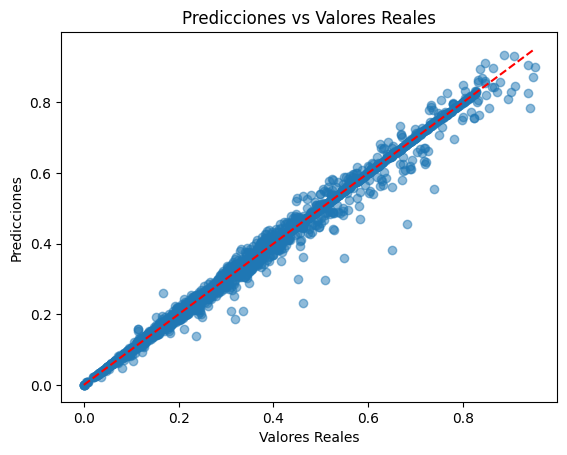

In [123]:
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([min(y_test_r), max(y_test_r)], [min(y_test_r), max(y_test_r)], color='red', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

Resultados para la clasificación.

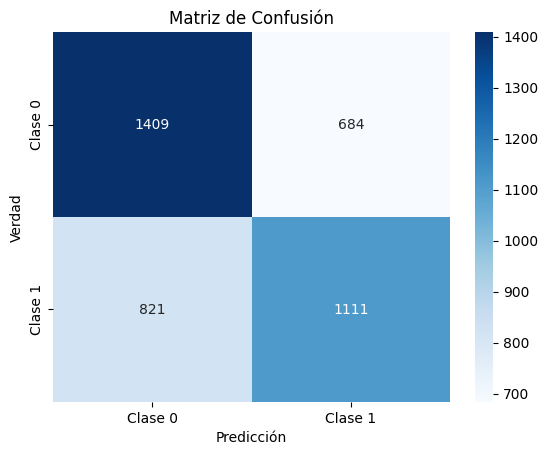

In [124]:
cm = confusion_matrix(y_test_c, y_pred_c)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.title('Matriz de Confusión')
plt.show()

Evaluación y visualización de la implementación del modelo XGBoost Classifier con GridSearchCV.

Mejores parámetros para XGBoost Classifier:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Mejor puntuación (accuracy):
0.6407629968799384

Reporte de Clasificación para XGBoost:
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      2093
           1       0.63      0.55      0.59      1932

    accuracy                           0.63      4025
   macro avg       0.63      0.63      0.62      4025
weighted avg       0.63      0.63      0.63      4025



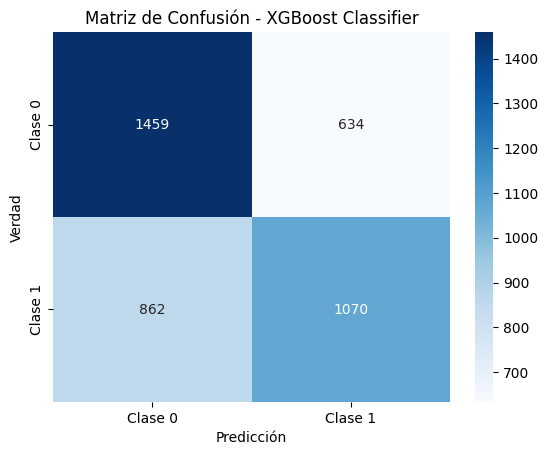

In [125]:
# Imprimir los mejores parámetros
print("Mejores parámetros para XGBoost Classifier:")
print(grid_xgb.best_params_)
print("Mejor puntuación (accuracy):")
print(grid_xgb.best_score_)

# Evaluar el mejor modelo en el conjunto de prueba
xgb_best = grid_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(X_test_c)

# Reporte de clasificación
print("\nReporte de Clasificación para XGBoost:")
print(classification_report(y_test_c, y_pred_xgb))

# Matriz de confusión
cm_xgb = confusion_matrix(y_test_c, y_pred_xgb)
sb.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.title('Matriz de Confusión - XGBoost Classifier')
plt.show()

### Curva ROC/AUC de los modelos de clasificación con mejor desempeño.

Random Forest Classifier

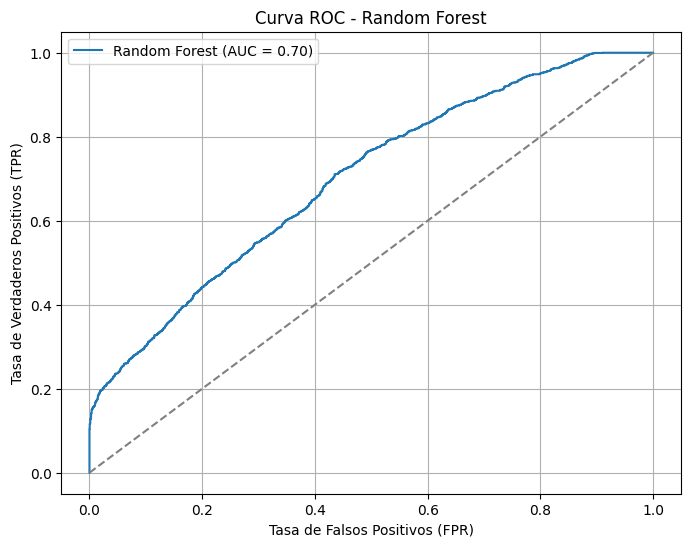

In [126]:
# Obtener las probabilidades para la clase positiva
y_prob_rf = grid_rf.predict_proba(X_test_c)[:, 1]

# Calcular las tasas FPR, TPR y los umbrales
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_c, y_prob_rf)

# Calcular el AUC
auc_rf = roc_auc_score(y_test_c, y_prob_rf)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.grid()
plt.show()

Support Vector Machine Classifier

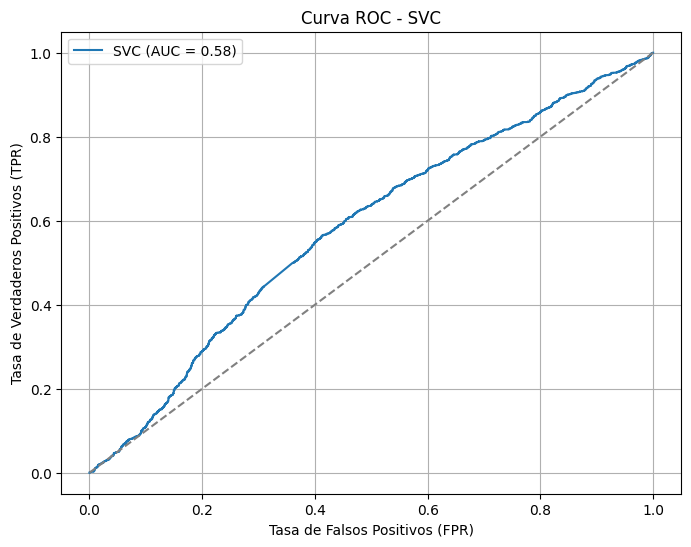

In [127]:
# Calcular probabilidades
y_prob_svc = grid_svc.predict_proba(X_test_c)[:, 1]

# Calcular FPR, TPR y AUC
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test_c, y_prob_svc)
auc_svc = roc_auc_score(y_test_c, y_prob_svc)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, label=f"SVC (AUC = {auc_svc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - SVC')
plt.legend()
plt.grid()
plt.show()

XGBoost Classifier

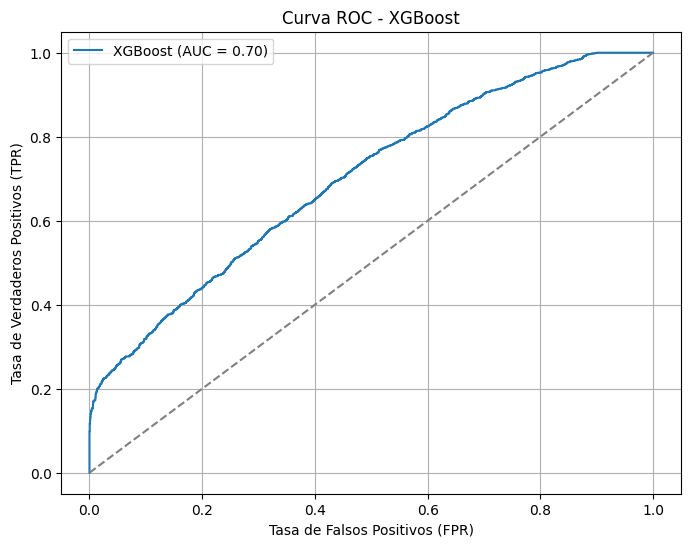

In [128]:
# Calcular probabilidades
y_prob_xgb = grid_xgb.predict_proba(X_test_c)[:, 1]

# Calcular FPR, TPR y AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test_c, y_prob_xgb)
auc_xgb = roc_auc_score(y_test_c, y_prob_xgb)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.grid()
plt.show()

### Comparativa entre modelos.

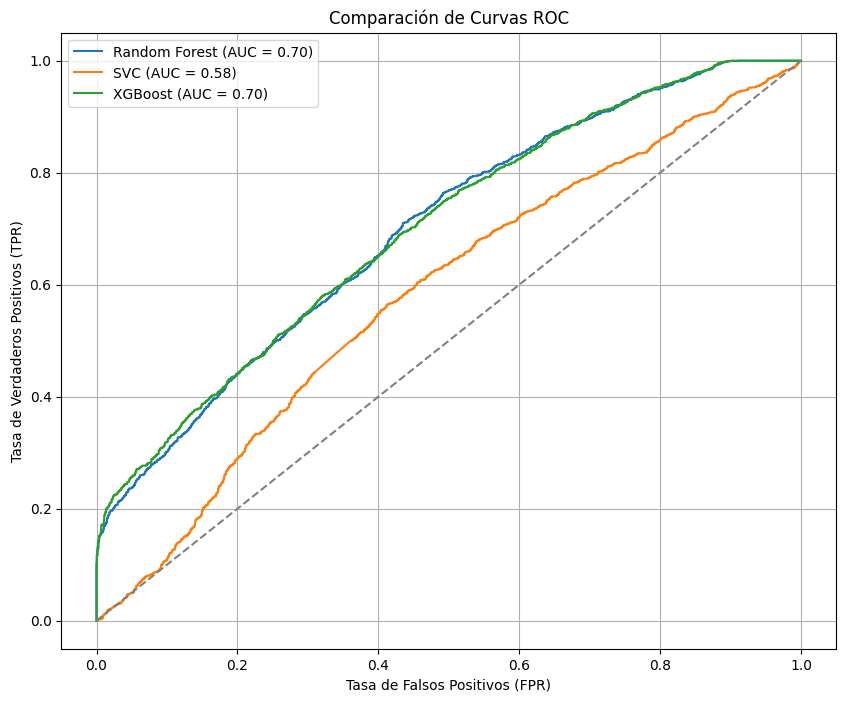

In [129]:
plt.figure(figsize=(10, 8))

# Random Forest
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")

# SVC
plt.plot(fpr_svc, tpr_svc, label=f"SVC (AUC = {auc_svc:.2f})")

# XGBoost
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")

# Línea base
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de Curvas ROC')
plt.legend()
plt.grid()
plt.show()


# Deployment